In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import os, csv, shapely, shapely.wkt, descartes, geopy, pickle, cloudpickle
from shapely.geometry import Point, Polygon
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import date, datetime, timedelta
from sklearn import preprocessing
from sklearn import metrics as skm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from fairlearn.metrics import MetricFrame
from fairlearn.reductions import BoundedGroupLoss, ExponentiatedGradient, AbsoluteLoss, GridSearch
from itertools import repeat
from sklearn.model_selection import KFold
from itertools import repeat

# pd.set_option('display.max_rows', 10)
# sns.set()
# sns.color_palette("ch:s=.25,rot=-.25")
np.set_printoptions(suppress=True)
# pd.options.display.float_format = '{:.2f}'.format

In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [4]:
DATA_PATH = 'preprocess/'

In [5]:
CITY = "N_"
save_dir = CITY + 'reg_res/'
save_dir_preprocess = os.path.join(save_dir, CITY + 'preprocess_fig/')
save_dir_models = os.path.join(save_dir, CITY + 'model_res/') 
save_dir_forecast = os.path.join(save_dir, CITY + 'forecast/')
save_dir_fairst = os.path.join(save_dir, CITY + 'fairst/')

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
if not os.path.exists(save_dir_preprocess):
    os.makedirs(save_dir_preprocess)

if not os.path.exists(save_dir_models):
    os.makedirs(save_dir_models)
    
if not os.path.exists(save_dir_forecast):
    os.makedirs(save_dir_forecast)
        
if not os.path.exists(save_dir_fairst):
    os.makedirs(save_dir_fairst)

In [6]:
df_census_raw = pd.read_csv(DATA_PATH + "cell_census.csv", index_col = 0)
df_walk_score_raw = pd.read_csv(DATA_PATH + "walk_score.csv", index_col = 0)
df_outflow_raw = pd.read_csv(DATA_PATH + 'df_outflow_monthly_cell.csv', index_col = 0)
df_outflow_raw

,cell_num,year,month,outflow
0,4605,2017,10,34
1,4784,2017,8,1143
2,4784,2017,9,1010
3,4784,2017,10,712
4,4784,2018,4,2
...,...,...,...,...
14102,7205,2019,11,28
14103,7205,2019,12,84
14104,7206,2019,12,55
14105,7298,2019,11,41


### load weather data

In [7]:
df_weather = pd.read_csv(DATA_PATH + "monthlyannualtemp.csv")
df_weather

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL
0,2015,29.9,23.9,38.1,54.3,68.5,71.2,78.8,79.0,74.5,58.0,52.8,50.8,56.7
1,2016,34.5,37.7,48.9,53.3,62.8,72.3,78.7,79.2,71.8,58.8,49.8,38.3,57.2
2,2017,38.0,41.6,39.2,57.2,61.1,72.0,76.8,74.0,70.5,64.1,46.6,33.4,56.3
3,2018,31.7,42.0,40.1,49.5,66.9,71.7,77.6,78.1,70.7,57.7,44.4,40.1,55.9
4,2019,32.5,36.2,41.7,55.5,62.2,71.7,79.6,75.5,70.4,59.9,43.9,38.3,55.6


In [8]:
df_weather.drop(columns = ["YEAR", "ANNUAL"], inplace = True)
df_weather

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,29.9,23.9,38.1,54.3,68.5,71.2,78.8,79.0,74.5,58.0,52.8,50.8
1,34.5,37.7,48.9,53.3,62.8,72.3,78.7,79.2,71.8,58.8,49.8,38.3
2,38.0,41.6,39.2,57.2,61.1,72.0,76.8,74.0,70.5,64.1,46.6,33.4
3,31.7,42.0,40.1,49.5,66.9,71.7,77.6,78.1,70.7,57.7,44.4,40.1
4,32.5,36.2,41.7,55.5,62.2,71.7,79.6,75.5,70.4,59.9,43.9,38.3


In [9]:
df_weather_sort = pd.DataFrame(df_weather.to_numpy().reshape(-1, 1))
df_weather_sort["year"] = [x for item in [2015, 2016, 2017, 2018, 2019] for x in repeat(item, 12)]
df_weather_sort["month"] = list(np.arange(12)+1)*5
df_weather_sort.rename(columns = {0 : "temp"}, inplace = True)
df_weather_sort

,temp,year,month
0,29.9,2015,1
1,23.9,2015,2
2,38.1,2015,3
3,54.3,2015,4
4,68.5,2015,5
5,71.2,2015,6
6,78.8,2015,7
7,79.0,2015,8
8,74.5,2015,9
9,58.0,2015,10


In [10]:
df_weather_sort.to_csv(DATA_PATH + "df_weather_sort.csv")

### walk score preprocess

In [11]:
df_walk_score = df_walk_score_raw[["cell_num", "walk_score",  "transit_score", "bike_score", "transit_summary"]]

In [12]:
# extract parts from "nearby"

df_walk_score['nearby_bus'] = 0
df_walk_score['nearby_rail'] = 0
df_walk_score['nearby_other'] = 0
df_walk_score['nearby_routes'] = 0

for row,col in df_walk_score.iterrows():
    # if nearby == NaN
    if type(df_walk_score.loc[row]['transit_summary']) == float:
        df_walk_score.at[row, 'nearby_bus'] = 0
        df_walk_score.at[row, 'nearby_rail'] = 0
        df_walk_score.at[row, 'nearby_other'] = 0
        
    else:
        routes = df_walk_score.loc[row]['transit_summary']
        routes = routes.split(' ')
        nearby_routes = routes[0]
        nearby_bus = routes[3]
        nearby_rail = routes[5]
        nearby_other = routes[7]

        df_walk_score.at[row, 'nearby_bus'] = nearby_bus
        df_walk_score.at[row, 'nearby_rail'] = nearby_rail
        df_walk_score.at[row, 'nearby_other'] = nearby_other
        df_walk_score.at[row, 'nearby_routes'] = nearby_routes
        
df_walk_score.drop(columns = ["transit_summary"], inplace = True)
df_walk_score.reset_index(drop = True, inplace = True)

/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on 

In [13]:
df_walk_score.to_csv(DATA_PATH + "df_walk_score.csv")
df_walk_score

,cell_num,walk_score,transit_score,bike_score,nearby_bus,nearby_rail,nearby_other,nearby_routes
0,94,36.0,57.0,43.0,11,2,0,13
1,95,62.0,63.0,49.0,11,2,0,13
2,186,18.0,44.0,44.0,5,0,0,5
3,187,47.0,56.0,53.0,11,2,0,13
4,188,72.0,61.0,51.0,11,2,0,13
...,...,...,...,...,...,...,...,...
3952,11216,68.0,53.0,52.0,8,0,0,8
3953,11305,77.0,56.0,54.0,13,0,0,13
3954,11306,75.0,58.0,59.0,14,0,0,14
3955,11307,70.0,59.0,60.0,13,0,0,13


In [14]:
df_census =  df_census_raw.merge(df_walk_score, on = 'cell_num')
df_census.to_csv(DATA_PATH + "df_census.csv")

In [15]:
df_census_copy = df_census.copy()
# make df_income for fairST
# training set
df_census_copy["income_group"] = 0
for row, col in df_census_copy.iterrows():
    if df_census_copy.loc[row]["median_hh_income"] > 50000:
        df_census_copy.at[row, "income_group"] = 1
df_census_copy[["cell_num", "income_group"]].to_csv(os.path.join(save_dir_fairst, "df_income.csv"))

### merge census and outflow

In [16]:
for row,col in df_census.iterrows():
    df_census.at[row, 'geometry'] = shapely.wkt.loads(df_census.loc[row]['geometry'])
    df_census.at[row, 'centroid'] = shapely.wkt.loads(df_census.loc[row]['centroid'])

In [17]:
df_census = gpd.GeoDataFrame(df_census, crs='EPSG:2956', geometry='geometry')
# type(pgh_grid_income.loc[0]['geometry'])

# df_geo.to_csv(os.path.join(save_dir_forecast, CITY + "df_geo.csv"))

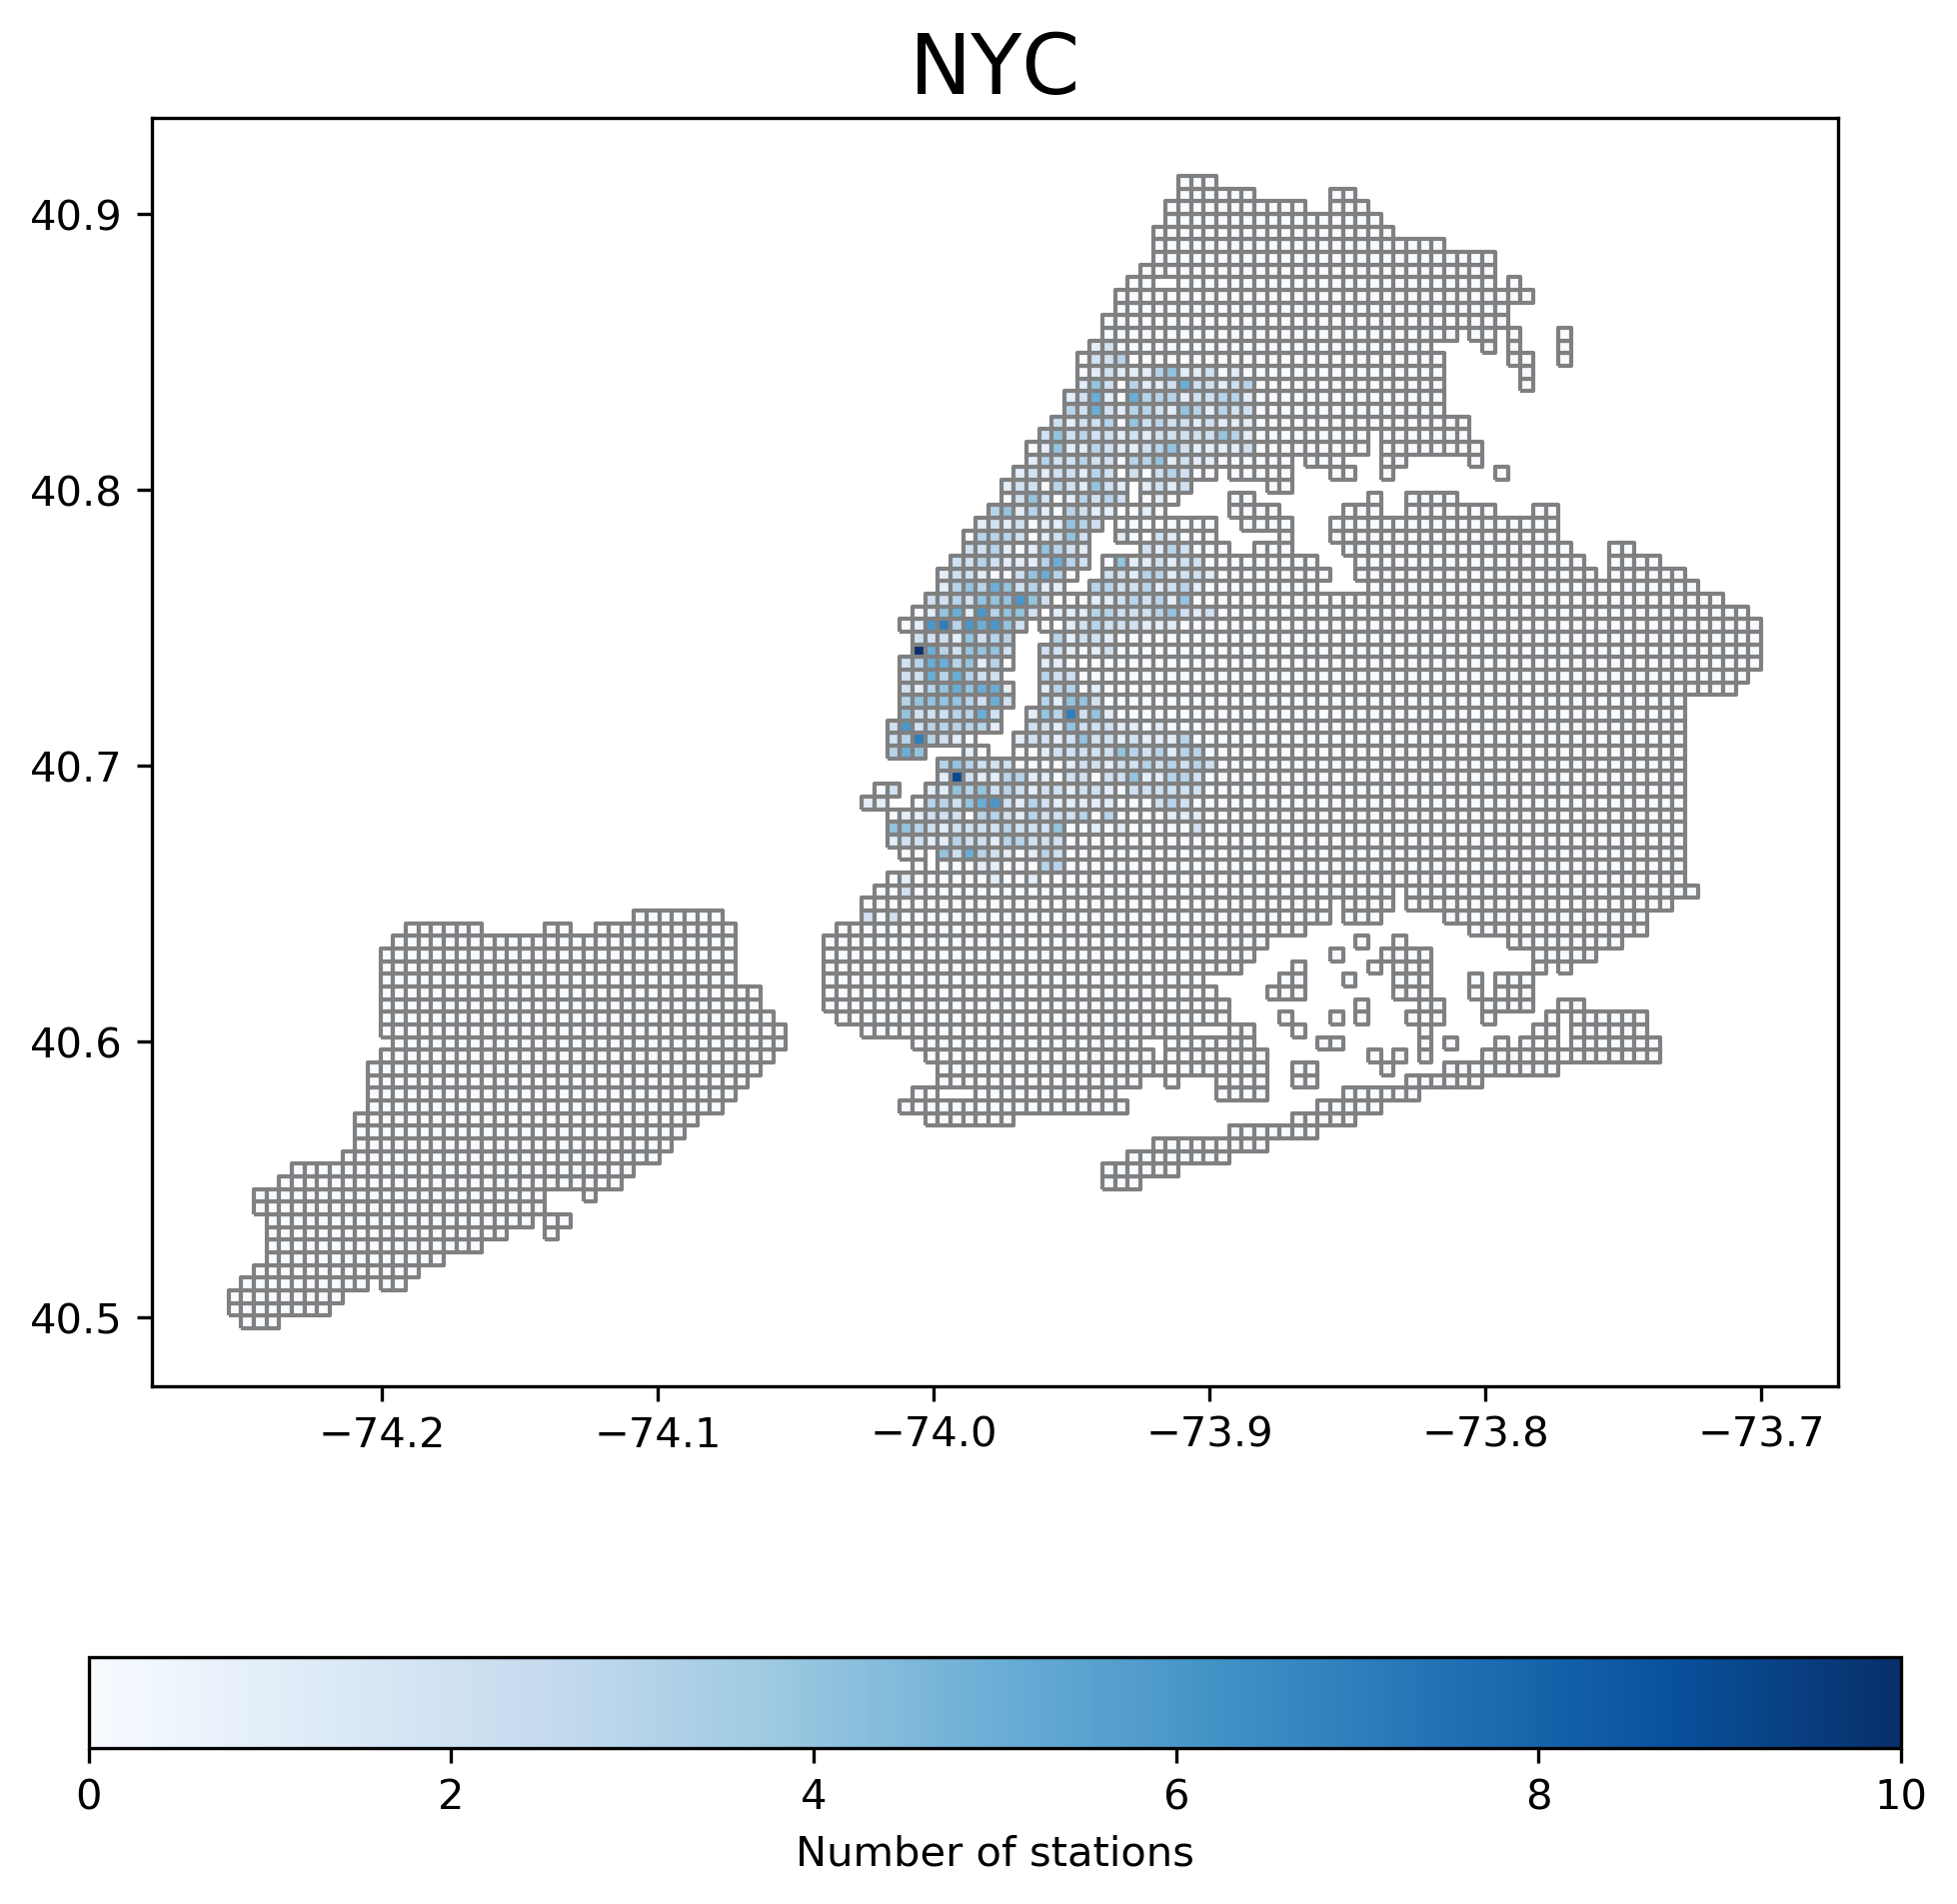

In [92]:
df_census.plot(column="stations", cmap='Blues',edgecolor = "grey", figsize=(12, 8),  
                    legend = True, legend_kwds={'shrink': 0.65, 'label': "Number of stations",'orientation': "horizontal",})
# plt.title("Distribution of stations in NYC", fontsize=20)
plt.title("NYC", fontsize = 20)
plt.savefig(os.path.join(save_dir_preprocess, CITY+"stations_dist"), facecolor = 'w')
plt.savefig("nyc_stations")

### merge outflow

In [19]:
df_census[df_census.stations > 0]

,cell_num,geometry,centroid,stations,stations_id_list,census_id,total_population,total_housing_units,population_over_16,population_over_16_in_labor,...,mean_travel_time_to_work,median_hh_income,mean_hh_income,walk_score,transit_score,bike_score,nearby_bus,nearby_rail,nearby_other,nearby_routes
794,4775,"POLYGON ((-74.02605 40.64303, -74.02605 40.647...",POINT (-74.02375807887353 40.64532422745739),2,"[4387, 4386]",36047001804,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,85.0,91.0,64.0,18,6,2,26
796,4784,"POLYGON ((-74.02605 40.68435, -74.02605 40.688...",POINT (-74.02375807887353 40.68664132429174),1,[3479],36061000500,0.0,40.0,0.0,0.0,...,0.0,0.0,0.0,16.0,38.0,32.0,10,0,2,12
809,4877,"POLYGON ((-74.02146 40.68435, -74.02146 40.688...",POINT (-74.01916729033638 40.68664132429174),1,[3182],36061000500,0.0,40.0,0.0,0.0,...,0.0,0.0,0.0,23.0,46.0,39.0,11,0,2,13
820,4961,"POLYGON ((-74.01687 40.64303, -74.01687 40.647...",POINT (-74.01457650179923 40.64532422745739),2,"[255, 3239]",36047007600,5151.0,1528.0,4120.0,2559.0,...,42.1,42950.0,76880.0,98.0,97.0,76.0,17,8,0,25
824,4967,"POLYGON ((-74.01687 40.67057, -74.01687 40.675...",POINT (-74.01457650179923 40.6728689586803),1,[3353],36047005301,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,74.0,51.0,92.0,11,4,1,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331,7603,"POLYGON ((-73.88833 40.81748, -73.88833 40.822...",POINT (-73.8860344227588 40.81977419186912),1,[4154],36005011502,4582.0,1495.0,3084.0,1608.0,...,48.4,17656.0,41956.0,89.0,98.0,78.0,10,7,0,17
2332,7604,"POLYGON ((-73.88833 40.82207, -73.88833 40.826...",POINT (-73.8860344227588 40.82436498040626),1,[4173],36005012300,4268.0,1709.0,3496.0,2048.0,...,40.6,31519.0,52270.0,79.0,100.0,72.0,13,7,0,20
2333,7605,"POLYGON ((-73.88833 40.82666, -73.88833 40.831...",POINT (-73.8860344227588 40.82895576894342),2,"[4180, 4252]",36005012300,4268.0,1709.0,3496.0,2048.0,...,40.6,31519.0,52270.0,86.0,100.0,74.0,12,7,0,19
2334,7606,"POLYGON ((-73.88833 40.83125, -73.88833 40.835...",POINT (-73.8860344227588 40.83354655748056),1,[4163],36005015700,4704.0,1748.0,3632.0,2206.0,...,43.1,33468.0,52895.0,82.0,100.0,73.0,16,8,0,24


In [20]:
df_outflow_raw

,cell_num,year,month,outflow
0,4605,2017,10,34
1,4784,2017,8,1143
2,4784,2017,9,1010
3,4784,2017,10,712
4,4784,2018,4,2
...,...,...,...,...
14102,7205,2019,11,28
14103,7205,2019,12,84
14104,7206,2019,12,55
14105,7298,2019,11,41


In [21]:
df_all_merge1 = df_outflow_raw.merge(df_census, on = 'cell_num', how = 'left')
df_all_merge1

,cell_num,year,month,outflow,geometry,centroid,stations,stations_id_list,census_id,total_population,...,mean_travel_time_to_work,median_hh_income,mean_hh_income,walk_score,transit_score,bike_score,nearby_bus,nearby_rail,nearby_other,nearby_routes
0,4605,2017,10,34,None,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4784,2017,8,1143,"POLYGON ((-74.02605 40.68435, -74.02605 40.688...",POINT (-74.02375807887353 40.68664132429174),1.0,[3479],3.606100e+10,0.0,...,0.0,0.0,0.0,16.0,38.0,32.0,10.0,0.0,2.0,12.0
2,4784,2017,9,1010,"POLYGON ((-74.02605 40.68435, -74.02605 40.688...",POINT (-74.02375807887353 40.68664132429174),1.0,[3479],3.606100e+10,0.0,...,0.0,0.0,0.0,16.0,38.0,32.0,10.0,0.0,2.0,12.0
3,4784,2017,10,712,"POLYGON ((-74.02605 40.68435, -74.02605 40.688...",POINT (-74.02375807887353 40.68664132429174),1.0,[3479],3.606100e+10,0.0,...,0.0,0.0,0.0,16.0,38.0,32.0,10.0,0.0,2.0,12.0
4,4784,2018,4,2,"POLYGON ((-74.02605 40.68435, -74.02605 40.688...",POINT (-74.02375807887353 40.68664132429174),1.0,[3479],3.606100e+10,0.0,...,0.0,0.0,0.0,16.0,38.0,32.0,10.0,0.0,2.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14102,7205,2019,11,28,"POLYGON ((-73.90669 40.69812, -73.90669 40.702...",POINT (-73.90439757690744 40.7004136899032),3.0,"[3878, 3896, 3884]",3.608106e+10,4244.0,...,44.0,75280.0,78006.0,99.0,98.0,78.0,16.0,4.0,0.0,20.0
14103,7205,2019,12,84,"POLYGON ((-73.90669 40.69812, -73.90669 40.702...",POINT (-73.90439757690744 40.7004136899032),3.0,"[3878, 3896, 3884]",3.608106e+10,4244.0,...,44.0,75280.0,78006.0,99.0,98.0,78.0,16.0,4.0,0.0,20.0
14104,7206,2019,12,55,"POLYGON ((-73.90669 40.70271, -73.90669 40.707...",POINT (-73.90439757690744 40.70500447844034),3.0,"[3877, 3902, 3909]",3.608106e+10,5296.0,...,42.9,62083.0,81005.0,96.0,96.0,74.0,17.0,4.0,0.0,21.0
14105,7298,2019,11,41,"POLYGON ((-73.90210 40.69812, -73.90210 40.702...",POINT (-73.89980678837027 40.7004136899032),2.0,"[3876, 3875]",3.608106e+10,4275.0,...,46.4,65799.0,73238.0,99.0,96.0,75.0,16.0,4.0,0.0,20.0


In [22]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_all_merge1.isna().sum())

cell_num                            0
year                                0
month                               0
outflow                             0
geometry                          324
centroid                          324
stations                          324
stations_id_list                  324
census_id                         324
total_population                 2326
total_housing_units              2326
population_over_16               2326
population_over_16_in_labor      2326
population_over_16_employed      2326
population_over_16_unemployed    2326
num_works_over_16                2326
car_truck_van_alone              2326
car_truck_van_carpooled          2326
public_transit                   2326
walked                           2326
other_means                      2326
wfh                              2326
mean_travel_time_to_work         2326
median_hh_income                 2326
mean_hh_income                   2326
walk_score                        324
transit_scor

In [23]:
df_all_merge1.drop(df_all_merge1[df_all_merge1.geometry.isnull()].index, inplace = True)

In [24]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_all_merge1.isna().sum())

cell_num                            0
year                                0
month                               0
outflow                             0
geometry                            0
centroid                            0
stations                            0
stations_id_list                    0
census_id                           0
total_population                 2002
total_housing_units              2002
population_over_16               2002
population_over_16_in_labor      2002
population_over_16_employed      2002
population_over_16_unemployed    2002
num_works_over_16                2002
car_truck_van_alone              2002
car_truck_van_carpooled          2002
public_transit                   2002
walked                           2002
other_means                      2002
wfh                              2002
mean_travel_time_to_work         2002
median_hh_income                 2002
mean_hh_income                   2002
walk_score                          0
transit_scor

In [25]:
df_all_merge1 = df_all_merge1.fillna(df_all_merge1.mean())
df_all_merge1

,cell_num,year,month,outflow,geometry,centroid,stations,stations_id_list,census_id,total_population,...,mean_travel_time_to_work,median_hh_income,mean_hh_income,walk_score,transit_score,bike_score,nearby_bus,nearby_rail,nearby_other,nearby_routes
1,4784,2017,8,1143,"POLYGON ((-74.02605 40.68435, -74.02605 40.688...",POINT (-74.02375807887353 40.68664132429174),1.0,[3479],3.606100e+10,0.0,...,0.0,0.0,0.0,16.0,38.0,32.0,10.0,0.0,2.0,12.0
2,4784,2017,9,1010,"POLYGON ((-74.02605 40.68435, -74.02605 40.688...",POINT (-74.02375807887353 40.68664132429174),1.0,[3479],3.606100e+10,0.0,...,0.0,0.0,0.0,16.0,38.0,32.0,10.0,0.0,2.0,12.0
3,4784,2017,10,712,"POLYGON ((-74.02605 40.68435, -74.02605 40.688...",POINT (-74.02375807887353 40.68664132429174),1.0,[3479],3.606100e+10,0.0,...,0.0,0.0,0.0,16.0,38.0,32.0,10.0,0.0,2.0,12.0
4,4784,2018,4,2,"POLYGON ((-74.02605 40.68435, -74.02605 40.688...",POINT (-74.02375807887353 40.68664132429174),1.0,[3479],3.606100e+10,0.0,...,0.0,0.0,0.0,16.0,38.0,32.0,10.0,0.0,2.0,12.0
5,4784,2018,5,624,"POLYGON ((-74.02605 40.68435, -74.02605 40.688...",POINT (-74.02375807887353 40.68664132429174),1.0,[3479],3.606100e+10,0.0,...,0.0,0.0,0.0,16.0,38.0,32.0,10.0,0.0,2.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14102,7205,2019,11,28,"POLYGON ((-73.90669 40.69812, -73.90669 40.702...",POINT (-73.90439757690744 40.7004136899032),3.0,"[3878, 3896, 3884]",3.608106e+10,4244.0,...,44.0,75280.0,78006.0,99.0,98.0,78.0,16.0,4.0,0.0,20.0
14103,7205,2019,12,84,"POLYGON ((-73.90669 40.69812, -73.90669 40.702...",POINT (-73.90439757690744 40.7004136899032),3.0,"[3878, 3896, 3884]",3.608106e+10,4244.0,...,44.0,75280.0,78006.0,99.0,98.0,78.0,16.0,4.0,0.0,20.0
14104,7206,2019,12,55,"POLYGON ((-73.90669 40.70271, -73.90669 40.707...",POINT (-73.90439757690744 40.70500447844034),3.0,"[3877, 3902, 3909]",3.608106e+10,5296.0,...,42.9,62083.0,81005.0,96.0,96.0,74.0,17.0,4.0,0.0,21.0
14105,7298,2019,11,41,"POLYGON ((-73.90210 40.69812, -73.90210 40.702...",POINT (-73.89980678837027 40.7004136899032),2.0,"[3876, 3875]",3.608106e+10,4275.0,...,46.4,65799.0,73238.0,99.0,96.0,75.0,16.0,4.0,0.0,20.0


### merge with weather

In [26]:
df_weather_sort

,temp,year,month
0,29.9,2015,1
1,23.9,2015,2
2,38.1,2015,3
3,54.3,2015,4
4,68.5,2015,5
5,71.2,2015,6
6,78.8,2015,7
7,79.0,2015,8
8,74.5,2015,9
9,58.0,2015,10


In [27]:
df_all_merge2 = df_all_merge1.merge(df_weather_sort, on = ["year", "month"])
df_all_merge2.head()

,cell_num,year,month,outflow,geometry,centroid,stations,stations_id_list,census_id,total_population,...,median_hh_income,mean_hh_income,walk_score,transit_score,bike_score,nearby_bus,nearby_rail,nearby_other,nearby_routes,temp
0,4784,2017,8,1143,"POLYGON ((-74.02605 40.68435, -74.02605 40.688...",POINT (-74.02375807887353 40.68664132429174),1.0,[3479],3.606100e+10,0.000000,...,0.000000,0.000000,16.0,38.0,32.0,10.0,0.0,2.0,12.0,74.0
1,4877,2017,8,1530,"POLYGON ((-74.02146 40.68435, -74.02146 40.688...",POINT (-74.01916729033638 40.68664132429174),1.0,[3182],3.606100e+10,0.000000,...,0.000000,0.000000,23.0,46.0,39.0,11.0,0.0,2.0,13.0,74.0
2,4967,2017,8,815,"POLYGON ((-74.01687 40.67057, -74.01687 40.675...",POINT (-74.01457650179923 40.6728689586803),1.0,[3353],3.604701e+10,4500.072065,...,98022.608437,148186.471946,74.0,51.0,92.0,11.0,4.0,1.0,16.0,74.0
3,4968,2017,8,1470,"POLYGON ((-74.01687 40.67516, -74.01687 40.679...",POINT (-74.01457650179923 40.67745974721744),4.0,"[3348, 3347, 3644, 3676]",3.604701e+10,4500.072065,...,98022.608437,148186.471946,88.0,50.0,94.0,11.0,0.0,2.0,13.0,74.0
4,4971,2017,8,1917,"POLYGON ((-74.01687 40.68894, -74.01687 40.693...",POINT (-74.01457650179923 40.6912321128289),2.0,"[3181, 3254]",3.606100e+10,0.000000,...,0.000000,0.000000,21.0,70.0,32.0,28.0,6.0,5.0,39.0,74.0


### income group

In [28]:
df_all_merge2["median_hh_income"].describe()

count     13783.000000
mean      98022.608437
std       51097.648781
min           0.000000
25%       61607.000000
50%       98022.608437
75%      133960.000000
max      250000.000000
Name: median_hh_income, dtype: float64

In [29]:
# training set
df_all_merge2["income_group"] = 0
for row, col in df_all_merge2.iterrows():
    if df_all_merge2.loc[row]["median_hh_income"] > 50000:
        df_all_merge2.at[row, "income_group"] = 1
df_all_merge2.drop(columns = ["median_hh_income"], inplace = True)

In [30]:
df_all_merge2

,cell_num,year,month,outflow,geometry,centroid,stations,stations_id_list,census_id,total_population,...,mean_hh_income,walk_score,transit_score,bike_score,nearby_bus,nearby_rail,nearby_other,nearby_routes,temp,income_group
0,4784,2017,8,1143,"POLYGON ((-74.02605 40.68435, -74.02605 40.688...",POINT (-74.02375807887353 40.68664132429174),1.0,[3479],3.606100e+10,0.000000,...,0.000000,16.0,38.0,32.0,10.0,0.0,2.0,12.0,74.0,0
1,4877,2017,8,1530,"POLYGON ((-74.02146 40.68435, -74.02146 40.688...",POINT (-74.01916729033638 40.68664132429174),1.0,[3182],3.606100e+10,0.000000,...,0.000000,23.0,46.0,39.0,11.0,0.0,2.0,13.0,74.0,0
2,4967,2017,8,815,"POLYGON ((-74.01687 40.67057, -74.01687 40.675...",POINT (-74.01457650179923 40.6728689586803),1.0,[3353],3.604701e+10,4500.072065,...,148186.471946,74.0,51.0,92.0,11.0,4.0,1.0,16.0,74.0,1
3,4968,2017,8,1470,"POLYGON ((-74.01687 40.67516, -74.01687 40.679...",POINT (-74.01457650179923 40.67745974721744),4.0,"[3348, 3347, 3644, 3676]",3.604701e+10,4500.072065,...,148186.471946,88.0,50.0,94.0,11.0,0.0,2.0,13.0,74.0,1
4,4971,2017,8,1917,"POLYGON ((-74.01687 40.68894, -74.01687 40.693...",POINT (-74.01457650179923 40.6912321128289),2.0,"[3181, 3254]",3.606100e+10,0.000000,...,0.000000,21.0,70.0,32.0,28.0,6.0,5.0,39.0,74.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13778,6552,2015,10,274,"POLYGON ((-73.93883 40.68894, -73.93883 40.693...",POINT (-73.93653309666753 40.6912321128289),1.0,[3058],3.604703e+10,2991.000000,...,95706.000000,90.0,95.0,77.0,14.0,7.0,0.0,21.0,58.0,1
13779,6553,2015,10,599,"POLYGON ((-73.93883 40.69353, -73.93883 40.698...",POINT (-73.93653309666753 40.69582290136605),2.0,"[3064, 3870]",3.604703e+10,3093.000000,...,85323.000000,97.0,99.0,78.0,15.0,7.0,0.0,22.0,58.0,0
13780,6563,2015,10,187,"POLYGON ((-73.93883 40.73944, -73.93883 40.744...",POINT (-73.93653309666753 40.74173078673755),2.0,"[3221, 3647]",3.608102e+10,4500.072065,...,148186.471946,77.0,99.0,74.0,10.0,13.0,0.0,23.0,58.0,1
13781,6564,2015,10,211,"POLYGON ((-73.93883 40.74403, -73.93883 40.748...",POINT (-73.93653309666753 40.74632157527471),1.0,[3123],3.608102e+10,4500.072065,...,148186.471946,88.0,100.0,85.0,16.0,21.0,0.0,37.0,58.0,1


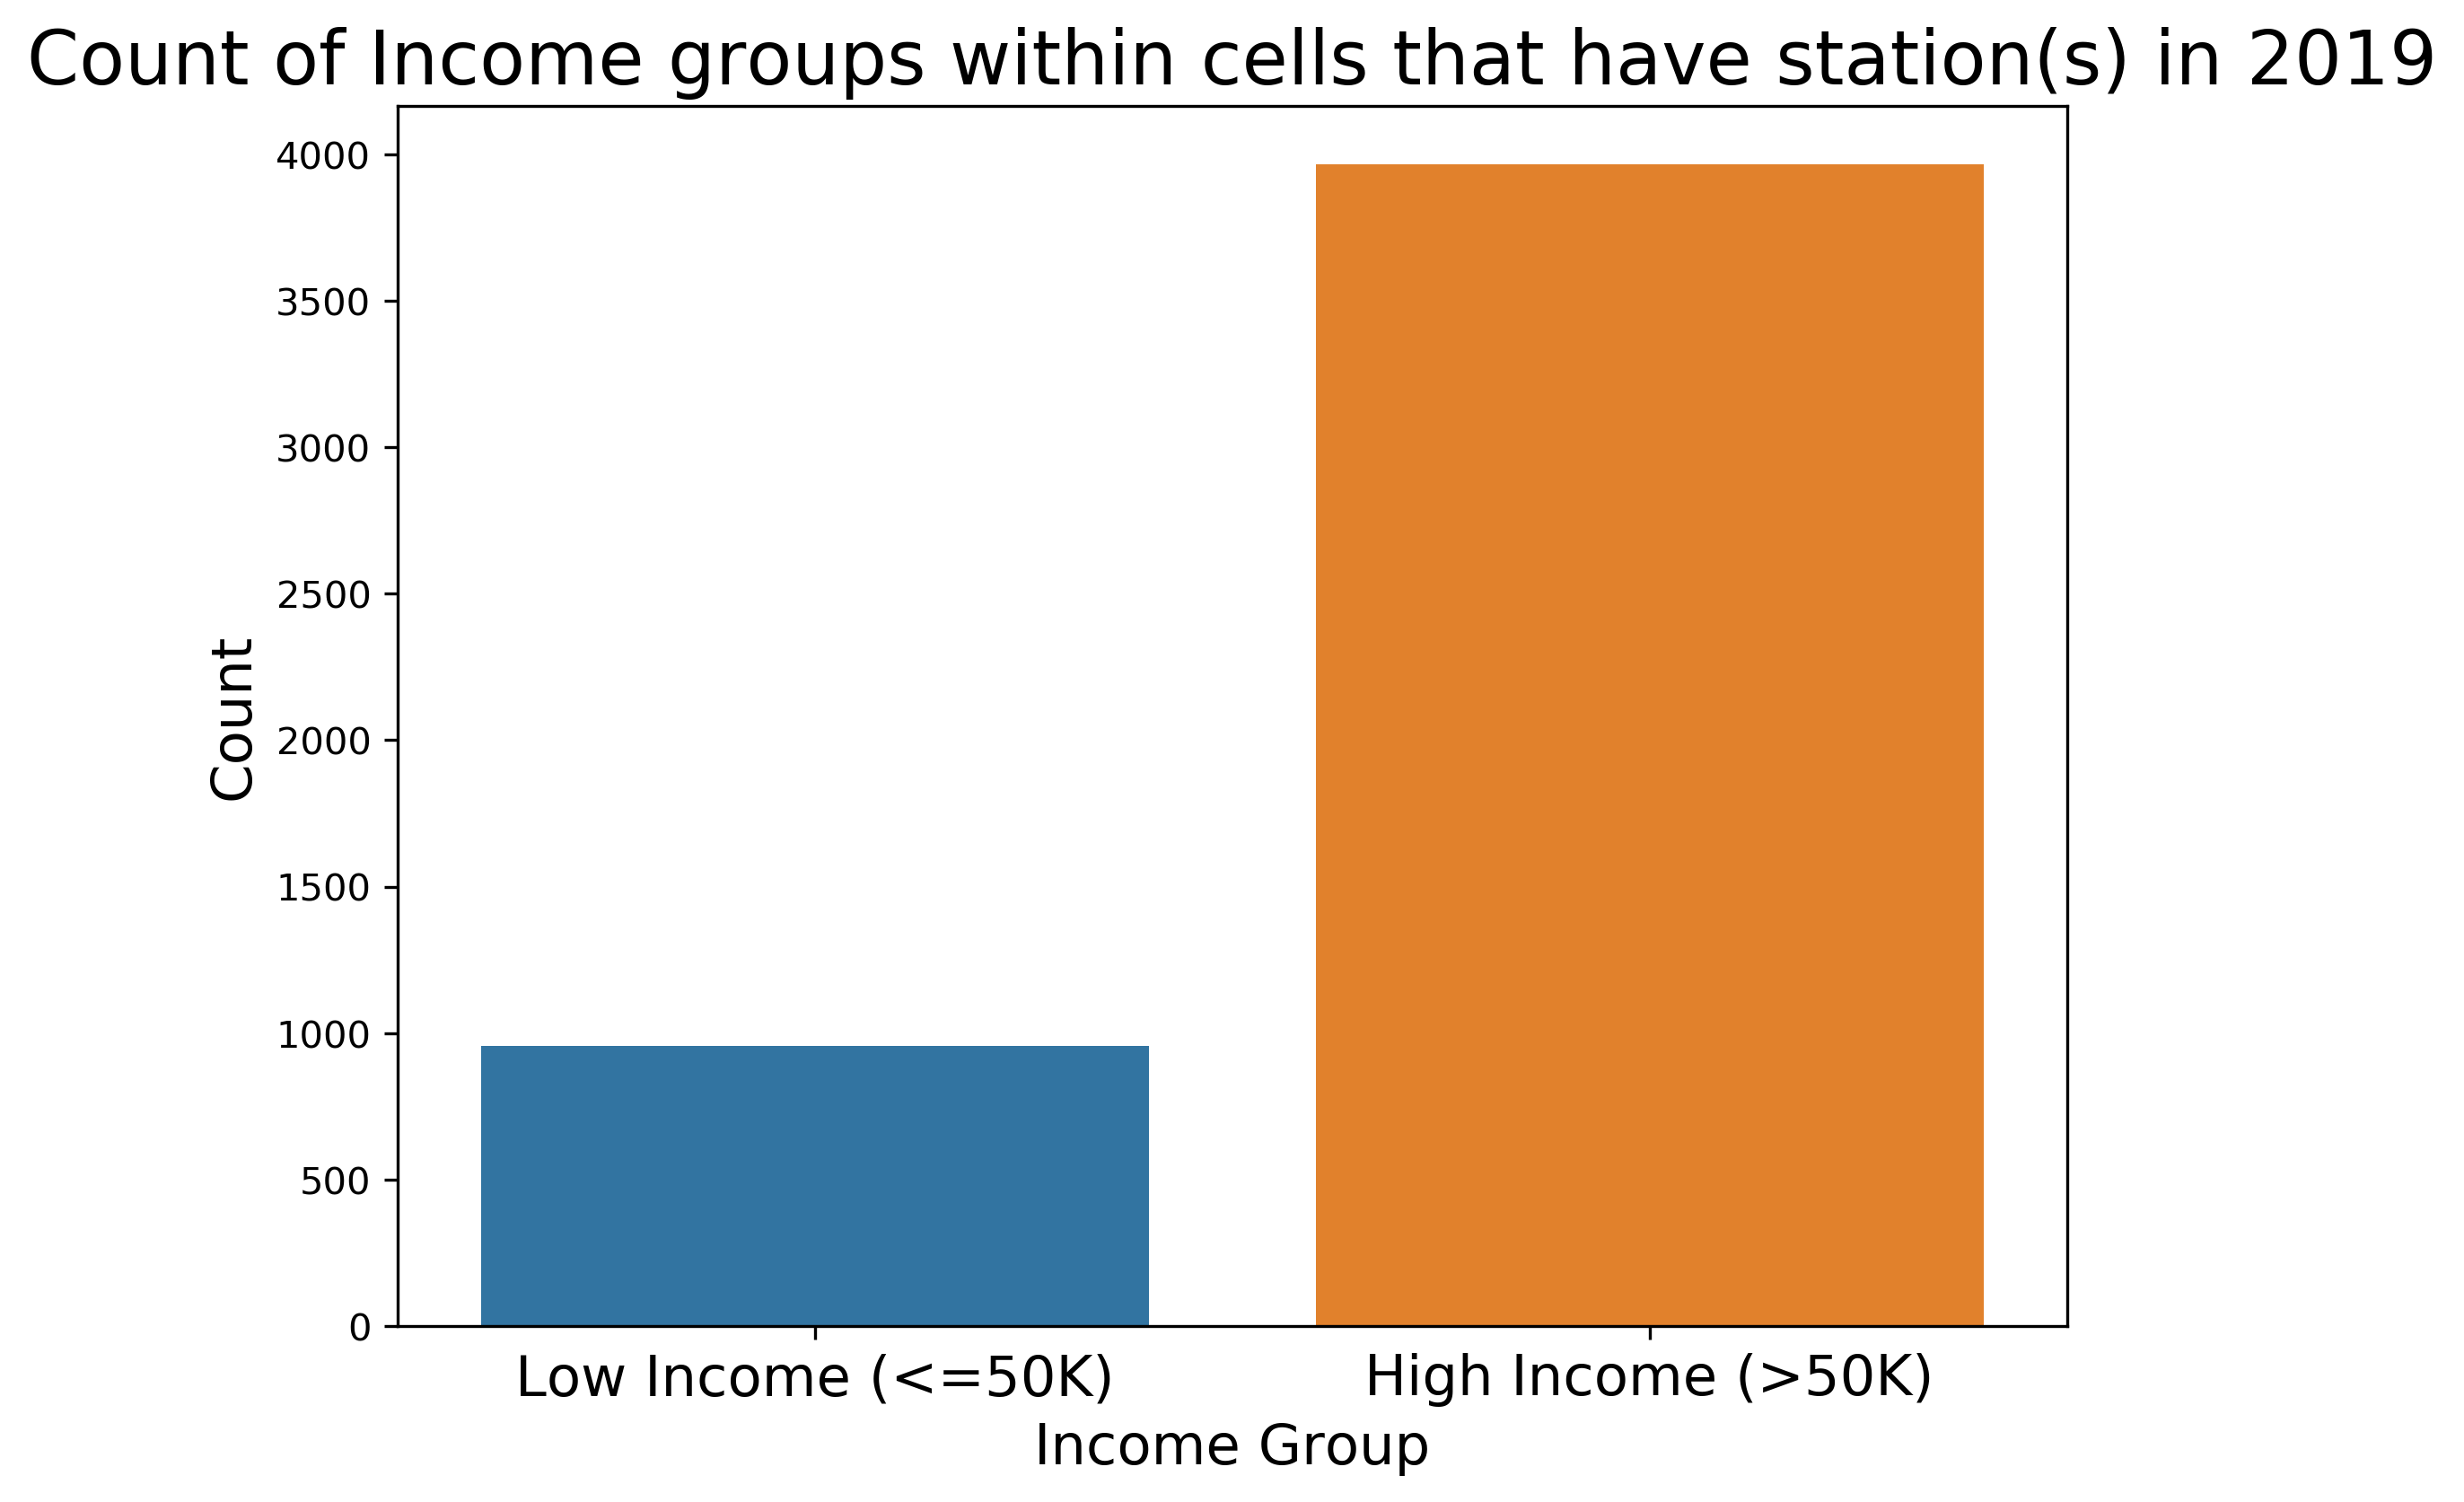

In [31]:
plt.figure(figsize = (8, 6))
sns.countplot(df_all_merge2[df_all_merge2.year == 2019]["income_group"])
plt.title("Count of Income groups within cells that have station(s) in 2019", fontsize = 20)
plt.xticks([0, 1], ["Low Income (<=50K)", "High Income (>50K)"], fontsize = 15)
plt.xlabel("Income Group", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.savefig(os.path.join(save_dir_preprocess, CITY +"income_group_2019"))

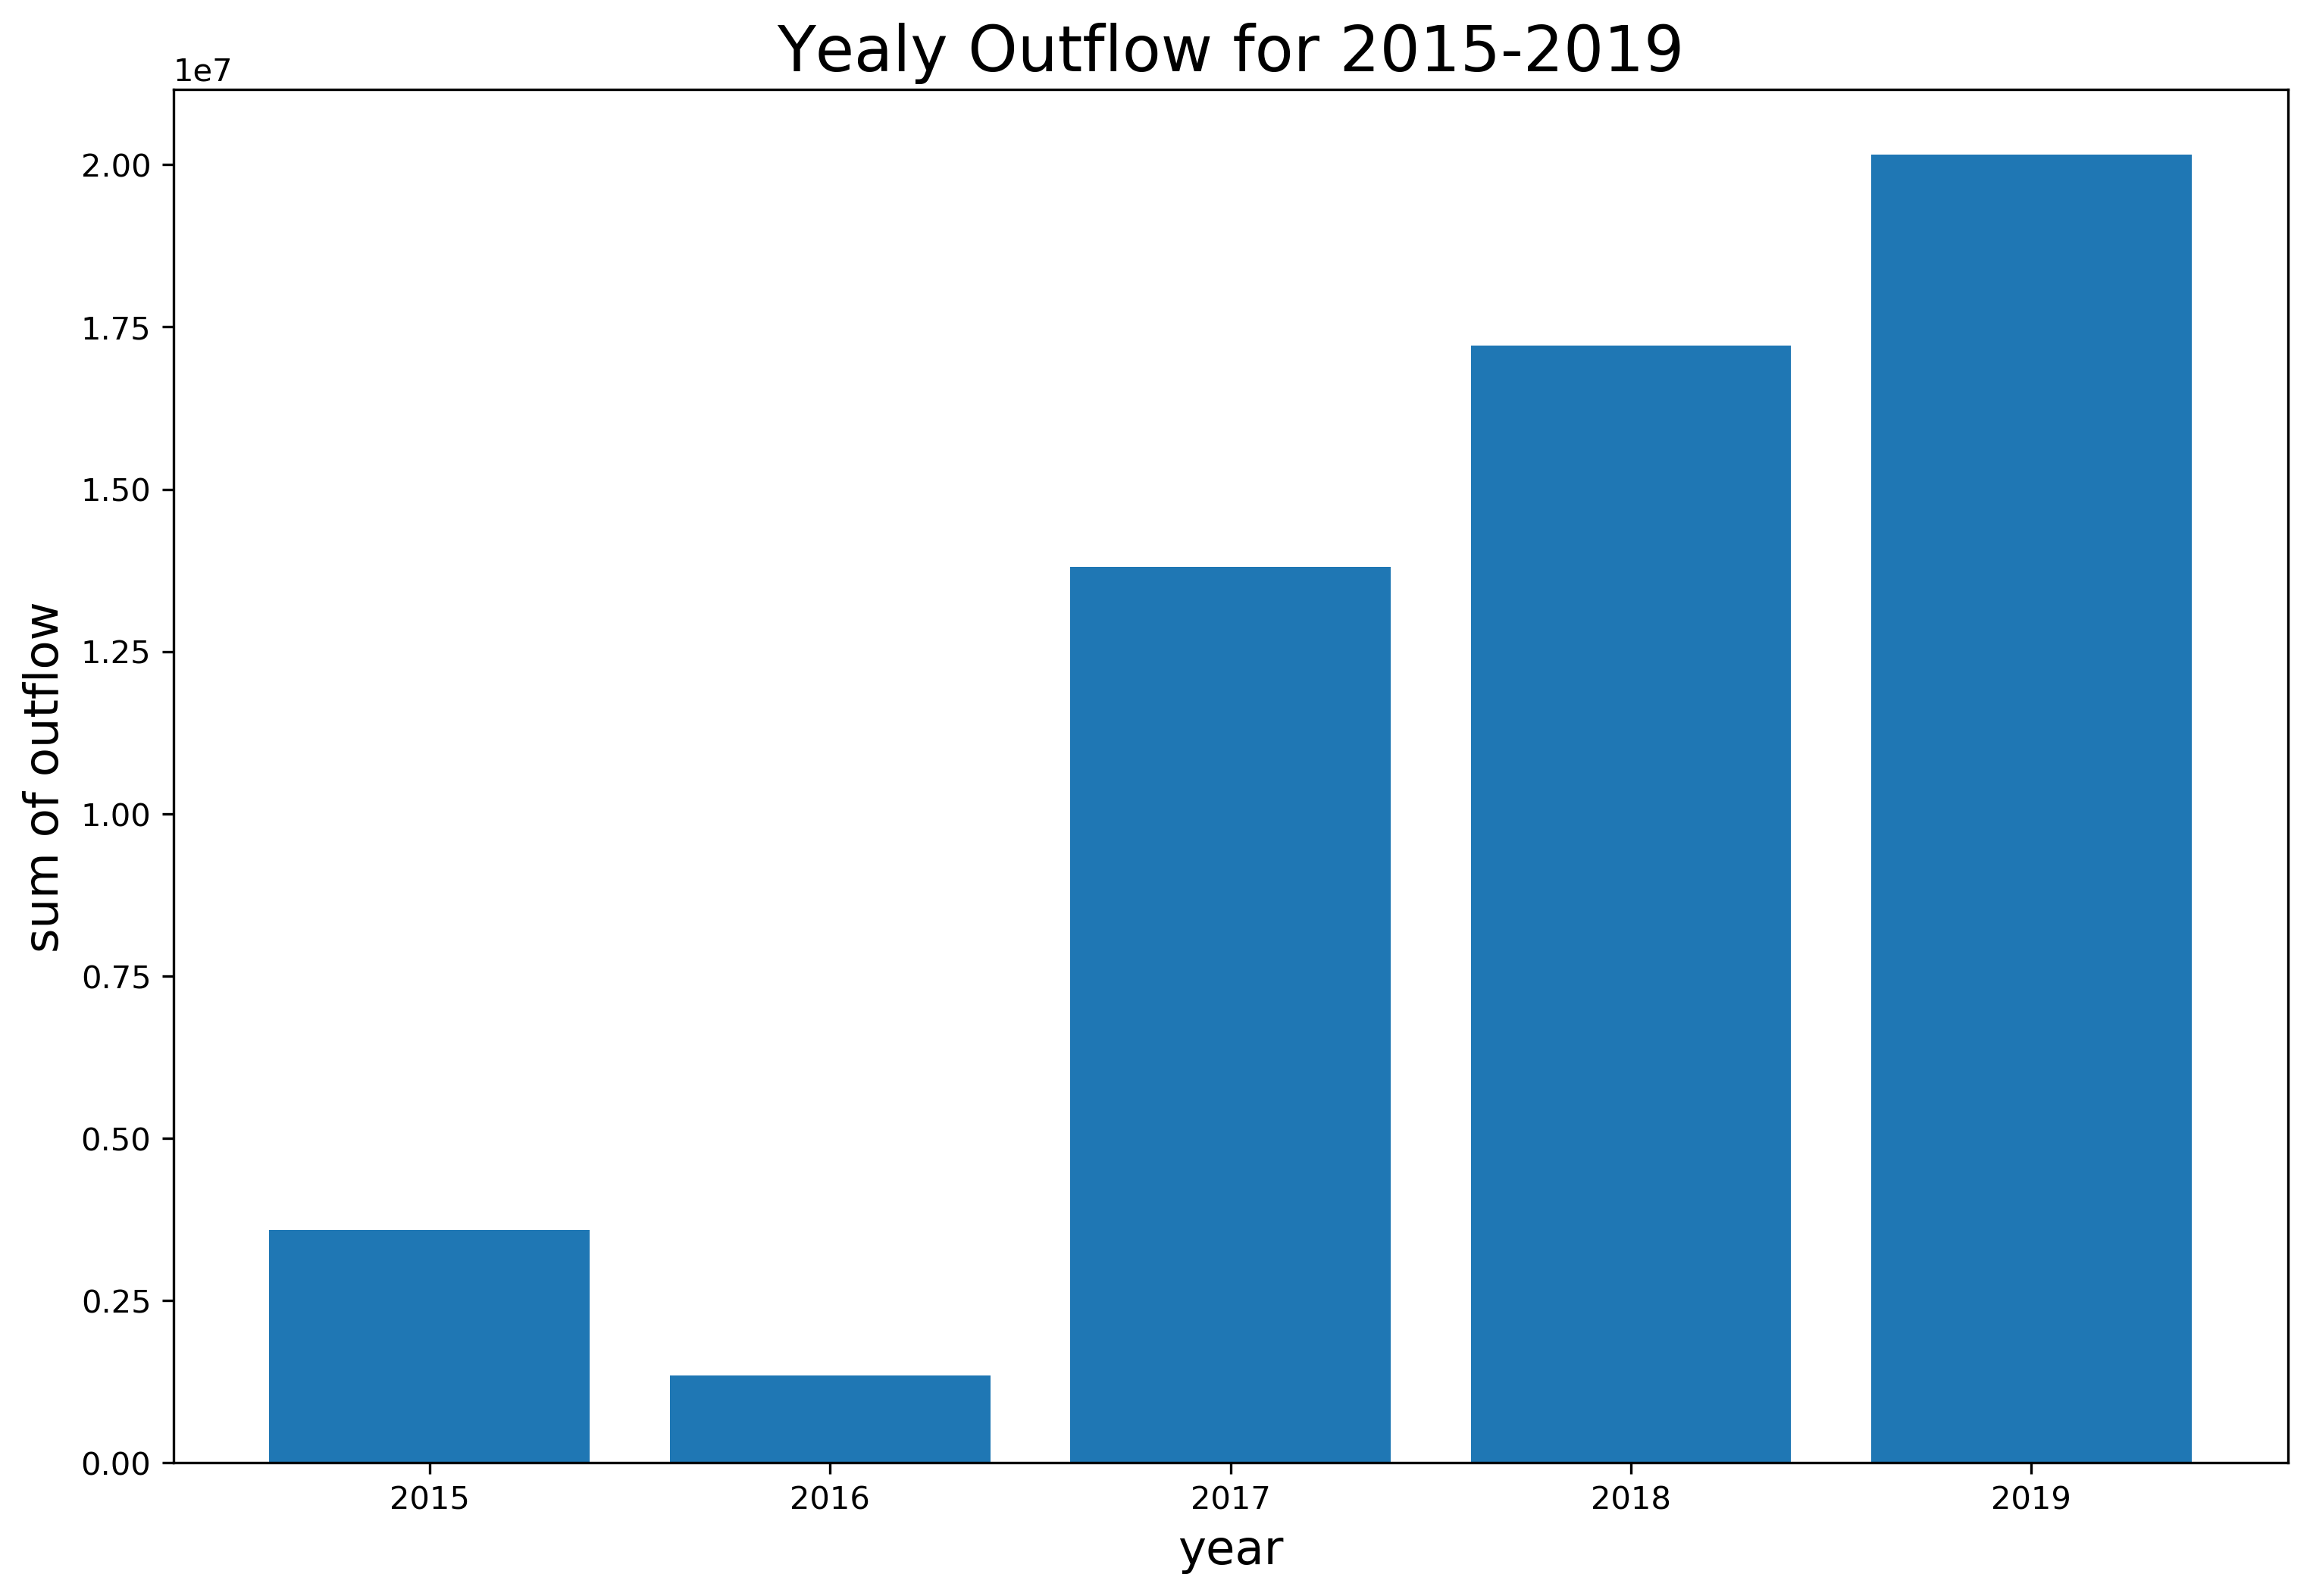

In [32]:
plt.figure(figsize = (12, 8))
plt.bar(height = 'outflow', x = "year", data = df_all_merge2.groupby("year").sum().reset_index()[["year", "outflow"]])
plt.title("Yealy Outflow for 2015-2019", fontsize = 20)
plt.xlabel("year", fontsize = 15)
plt.ylabel("sum of outflow", fontsize = 15)
plt.savefig(os.path.join(save_dir_preprocess, CITY +"yearly outflow"))

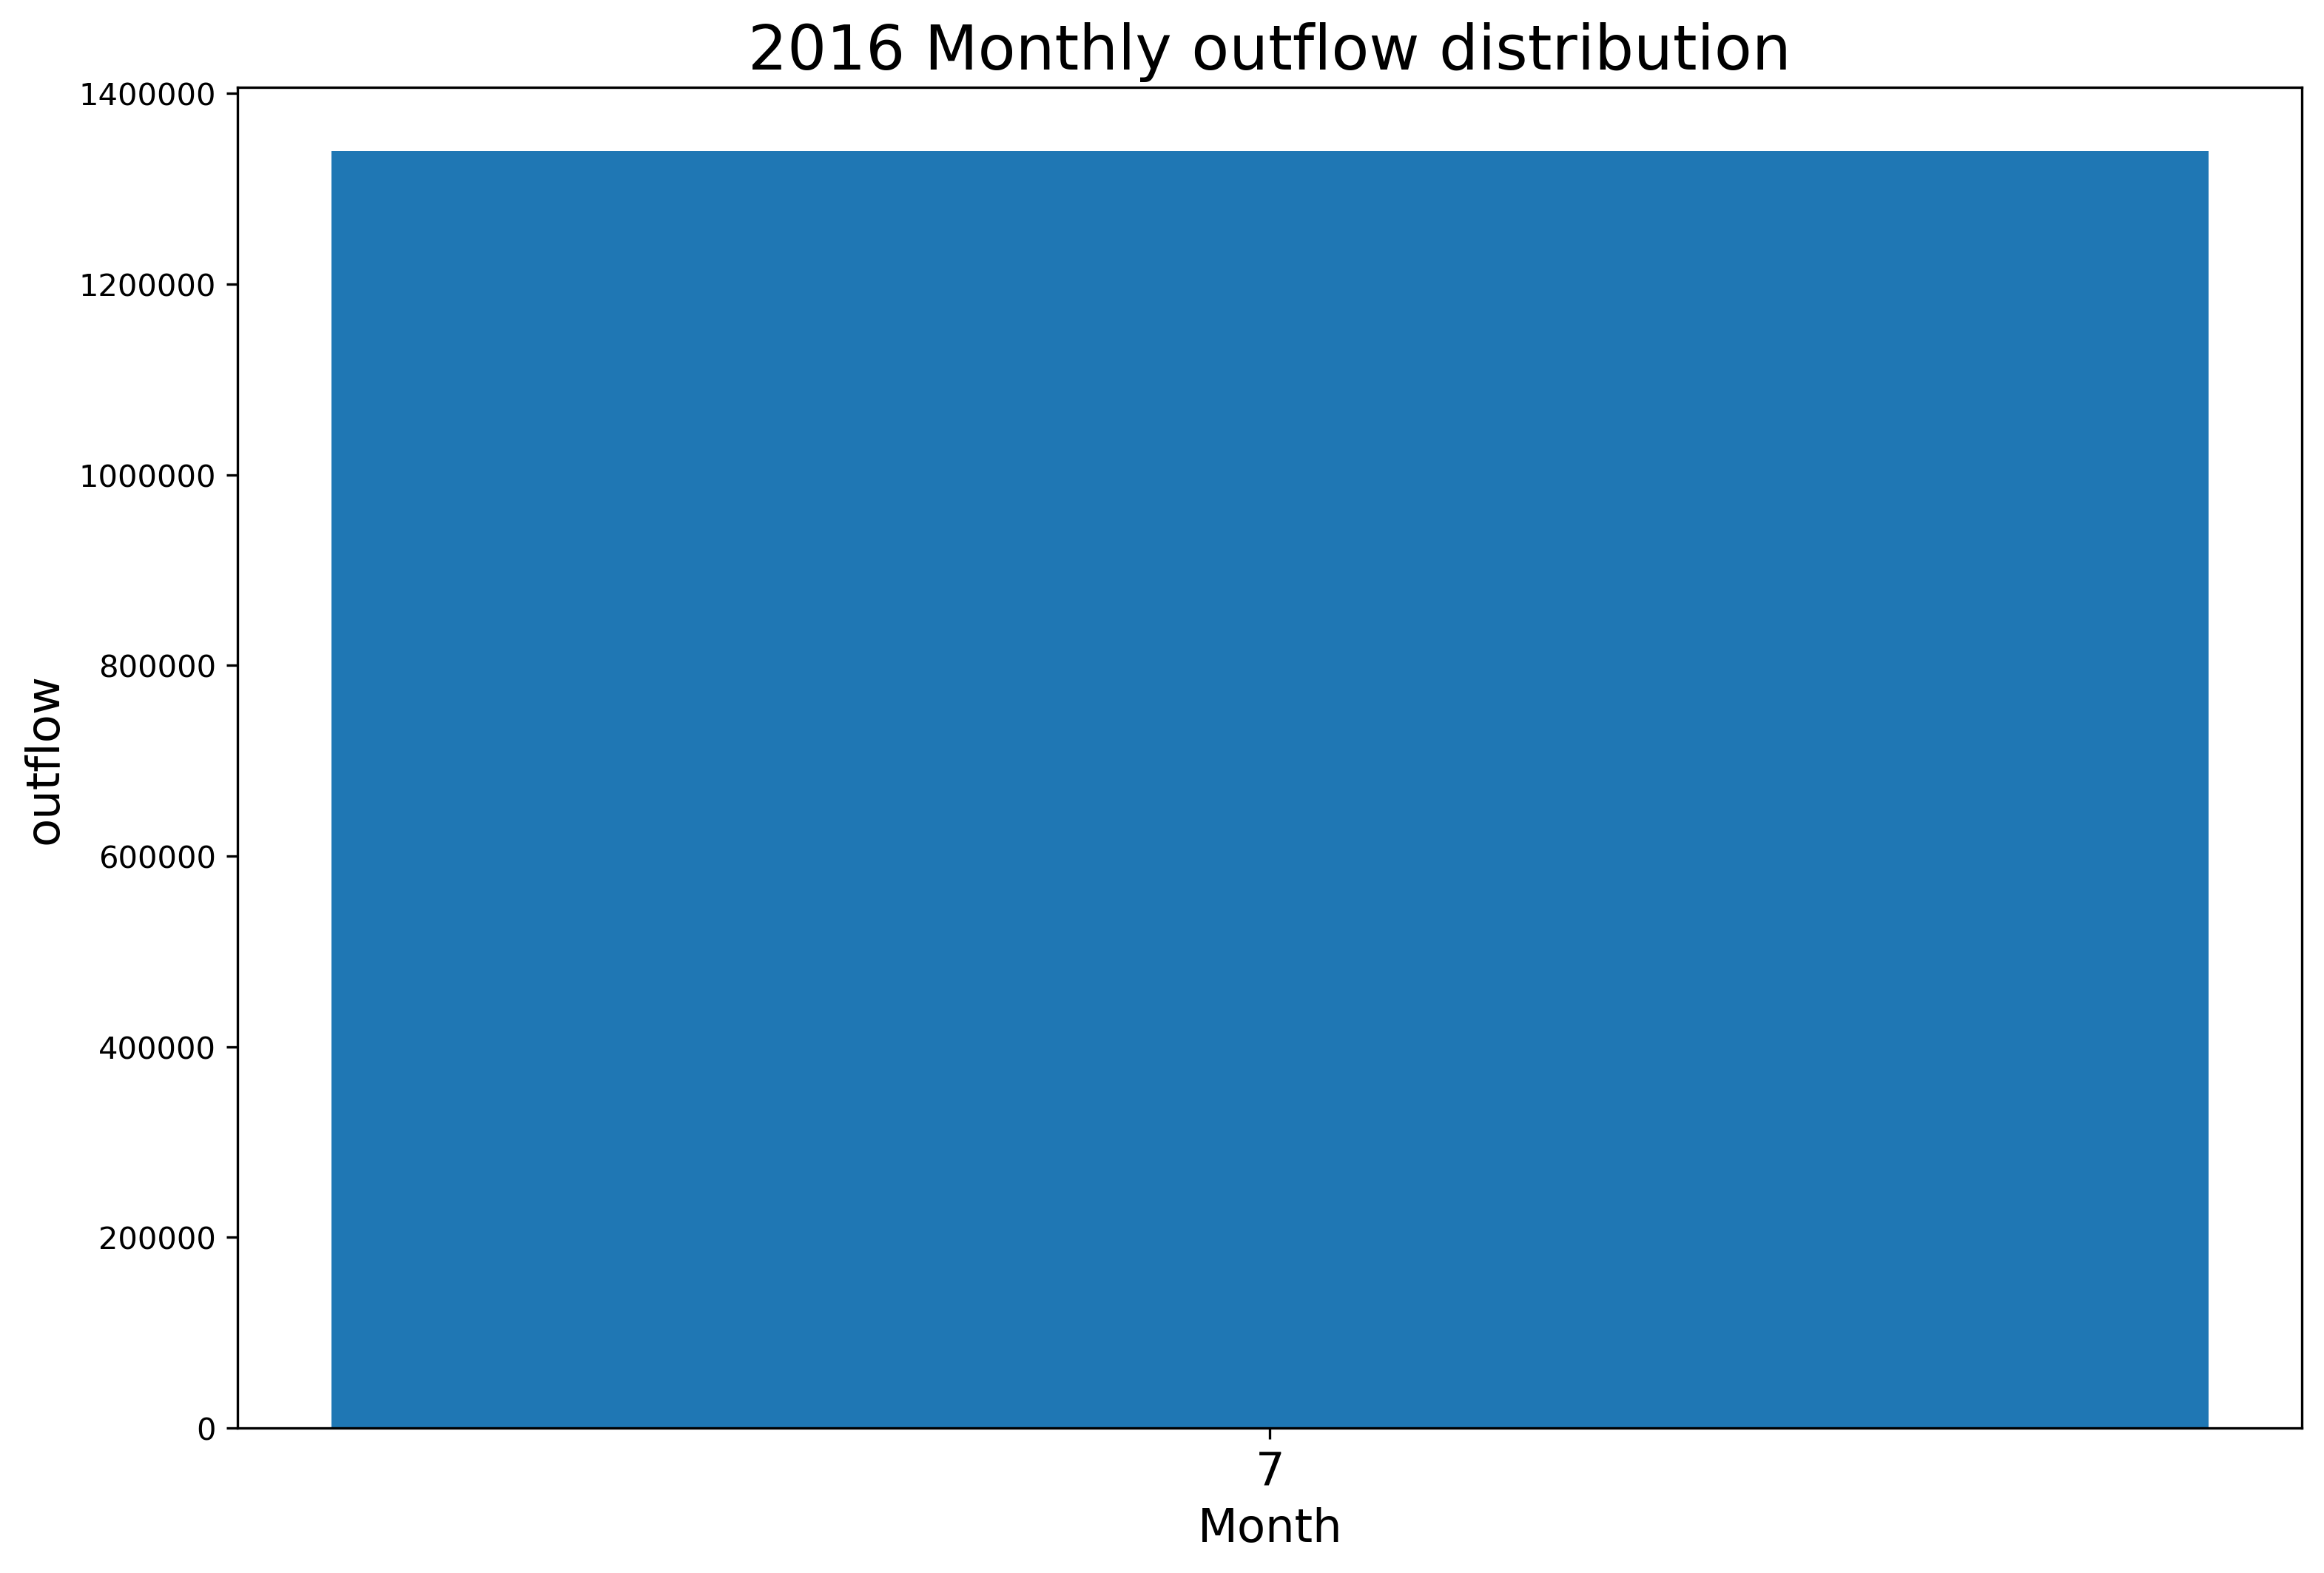

In [33]:
YEAR = 2016
plt.figure(figsize = (12, 8))
plt.bar(x = df_all_merge2[df_all_merge2.year == YEAR].groupby("month").sum()["outflow"].index , height = df_all_merge2[df_all_merge2.year == YEAR].groupby("month").sum()["outflow"].values)
plt.title("{} Monthly outflow distribution".format(YEAR), fontsize = 20)
plt.xlabel("Month", fontsize = 15)
plt.ylabel("outflow", fontsize = 15)
plt.xticks(df_all_merge2[df_all_merge2.year == YEAR].groupby("month").sum()["outflow"].index, fontsize = 15)
plt.savefig(os.path.join(save_dir_preprocess, CITY +"{}_monthly_outflow".format(YEAR)))

### feature selection

In [34]:
features_col = ["cell_num", 'year', 'month', 'outflow', 'stations', 
               'total_population', 'total_housing_units', 'population_over_16_employed',
               'population_over_16_unemployed', 'num_works_over_16',
               'car_truck_van_alone', 'car_truck_van_carpooled', 'public_transit',
               'walked', 'other_means', 'wfh', 'mean_travel_time_to_work',
                'walk_score', 'transit_score', 'bike_score', 'nearby_bus',
                'nearby_rail', 'nearby_other', 'nearby_routes', 'temp',
               'income_group']

In [35]:
df = df_all_merge2[features_col]
df

,cell_num,year,month,outflow,stations,total_population,total_housing_units,population_over_16_employed,population_over_16_unemployed,num_works_over_16,...,mean_travel_time_to_work,walk_score,transit_score,bike_score,nearby_bus,nearby_rail,nearby_other,nearby_routes,temp,income_group
0,4784,2017,8,1143,1.0,0.000000,40.000000,0.000000,0.000000,0.000000,...,0.000000,16.0,38.0,32.0,10.0,0.0,2.0,12.0,74.0,0
1,4877,2017,8,1530,1.0,0.000000,40.000000,0.000000,0.000000,0.000000,...,0.000000,23.0,46.0,39.0,11.0,0.0,2.0,13.0,74.0,0
2,4967,2017,8,815,1.0,4500.072065,2412.569052,2537.266701,129.944911,2489.129615,...,31.501053,74.0,51.0,92.0,11.0,4.0,1.0,16.0,74.0,1
3,4968,2017,8,1470,4.0,4500.072065,2412.569052,2537.266701,129.944911,2489.129615,...,31.501053,88.0,50.0,94.0,11.0,0.0,2.0,13.0,74.0,1
4,4971,2017,8,1917,2.0,0.000000,40.000000,0.000000,0.000000,0.000000,...,0.000000,21.0,70.0,32.0,28.0,6.0,5.0,39.0,74.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13778,6552,2015,10,274,1.0,2991.000000,1456.000000,1842.000000,79.000000,1788.000000,...,49.200000,90.0,95.0,77.0,14.0,7.0,0.0,21.0,58.0,1
13779,6553,2015,10,599,2.0,3093.000000,1303.000000,1442.000000,53.000000,1410.000000,...,43.900000,97.0,99.0,78.0,15.0,7.0,0.0,22.0,58.0,0
13780,6563,2015,10,187,2.0,4500.072065,2412.569052,2537.266701,129.944911,2489.129615,...,31.501053,77.0,99.0,74.0,10.0,13.0,0.0,23.0,58.0,1
13781,6564,2015,10,211,1.0,4500.072065,2412.569052,2537.266701,129.944911,2489.129615,...,31.501053,88.0,100.0,85.0,16.0,21.0,0.0,37.0,58.0,1


In [36]:
df.cell_num.to_csv("nyc_match_cell_num.csv")

In [37]:
# missing: capacity
df.columns

Index(['cell_num', 'year', 'month', 'outflow', 'stations', 'total_population',
       'total_housing_units', 'population_over_16_employed',
       'population_over_16_unemployed', 'num_works_over_16',
       'car_truck_van_alone', 'car_truck_van_carpooled', 'public_transit',
       'walked', 'other_means', 'wfh', 'mean_travel_time_to_work',
       'walk_score', 'transit_score', 'bike_score', 'nearby_bus',
       'nearby_rail', 'nearby_other', 'nearby_routes', 'temp', 'income_group'],
      dtype='object')

### Below are the same across cities

In [38]:
# Train Test split
df_1518 = df[df["year"].isin([2015, 2016, 2017, 2018])] # 1032
df_19 = df[df["year"].isin([2019]) & ~(df["month"] == 1)]

df_1518 = df_1518.drop(columns = ["year"])
df_19 = df_19.drop(columns = ["year"])

In [39]:
X_train = df_1518.drop(columns = ["outflow", "cell_num"])
X_test = df_19.drop(columns = ["outflow", "cell_num"])

y_train = df_1518["outflow"]
y_test = df_19["outflow"]

A_train = df_1518["income_group"]
A_test = df_19["income_group"]

X_train.to_csv(os.path.join(save_dir_forecast, CITY +"X_train.csv"))

y_test_cell_num = df_19[["cell_num", "income_group"]]
y_test_cell_num

,cell_num,income_group
3825,4784,0
3826,4877,0
3827,4968,1
3828,4971,0
3829,4974,1
...,...,...
13537,7203,1
13538,7204,1
13539,7205,1
13540,7206,1


In [40]:
# reset index
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)
A_train.reset_index(drop = True, inplace = True)
A_test.reset_index(drop = True, inplace = True)

In [41]:
# RFG calculation
def rfg_calc(y_pred, y_gt, normalized_pop_df, y_test_cell_num):
    normalized_pop_df["cell_num"] = normalized_pop_df.index
    cell2group_df = y_test_cell_num.groupby("cell_num").mean().reset_index()
    cell2group_df["income_group"] = cell2group_df["income_group"].astype(int)
    cell_pop_df = normalized_pop_df.merge(cell2group_df, on = "cell_num")
    
    g1_pop = cell_pop_df[cell_pop_df["income_group"] == 1].normalized_pop.sum()
    g2_pop = cell_pop_df[cell_pop_df["income_group"] == 0].normalized_pop.sum()
    
    group_index = A_test.reset_index(drop = True)
    g1_pred = y_pred[group_index[group_index == 1].index]
    g2_pred = y_pred[group_index[group_index == 0].index]

    bike_g1 = g1_pred.sum() / len(y_pred)
    bike_g2 = g2_pred.sum()/ len(y_pred)
    # print("bike_g1 ", bike_g1)
    # print("bike_g2 ", bike_g2)
    
    return bike_g1 /g1_pop - bike_g2 /g2_pop

In [42]:
# calculate normalized pop: for RFG
cell_num_ls = df[df.year == 2019].cell_num.unique()
normalized_pop_df = pd.DataFrame(0, columns = ['pop'] , index = cell_num_ls)
        
for cell in cell_num_ls:
    pop = df[df.year == 2019][df[df.year == 2019].cell_num == cell]['total_population'].reset_index(drop=True)[0]
    normalized_pop_df.loc[cell, 'pop'] = pop
    
normalized_pop_df["normalized_pop"] = normalized_pop_df["pop"] / normalized_pop_df["pop"].sum()
# normalized_pop_df.to_csv(os.path.join(save_dir_fairst, "normalized_pop_df.csv"))

### 3 Fairness models

In [43]:
# summary df
model_summary = pd.DataFrame(0, columns = ["r2", "r2_diff", "mae", "mae_diff", "rfg"], 
                             index = ["random_forest", "exp_grad", "grid_search"])

# model_summary.to_csv(os.path.join(save_dir_models, CITY +"model_summary.csv"))

In [44]:
# param_grid = { # 'bootstrap': [True, False],
#  'max_depth': [10, 20, 40, 50, 60],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [20, 40, 60, 80, 100]}

# # Create a based model
# rf = RandomForestRegressor(random_state = 42)
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, verbose = 1, scoring = 'neg_mean_absolute_error') # r2 / neg_mean_absolute_error
# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# # save grid search model
# with open(os.path.join(save_dir_models, CITY +"random_forest_gs_best.csv"), 'w') as f:
#     for key in grid_search.best_params_.keys():
#         f.write("%s,%s\n"%(key, grid_search.best_params_[key]))
#     f.write("%s, %s\n"%("scoring", grid_search.scoring))

In [45]:
# print(grid_search.best_estimator_)
# print(grid_search.best_score_)
# grid_search_all_res = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["neg_mean_absolute_error"])], axis=1)
# grid_search_all_res.to_csv(os.path.join(save_dir_models, CITY +"random_forest_gs_all.csv"))

In [46]:
rf_best = pickle.load(open(os.path.join(save_dir_models, CITY + "random_forest.pkl"), 'rb'))

R^2      0.992815
MAE    208.672948
dtype: object
------------------------------
                   R^2         MAE
income_group                      
0             0.992285    124.1349
1             0.992619  228.747635
R^2 diff: 0.00033
MAE diff: 104.61274
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f0bc715d0>],
      dtype=object)

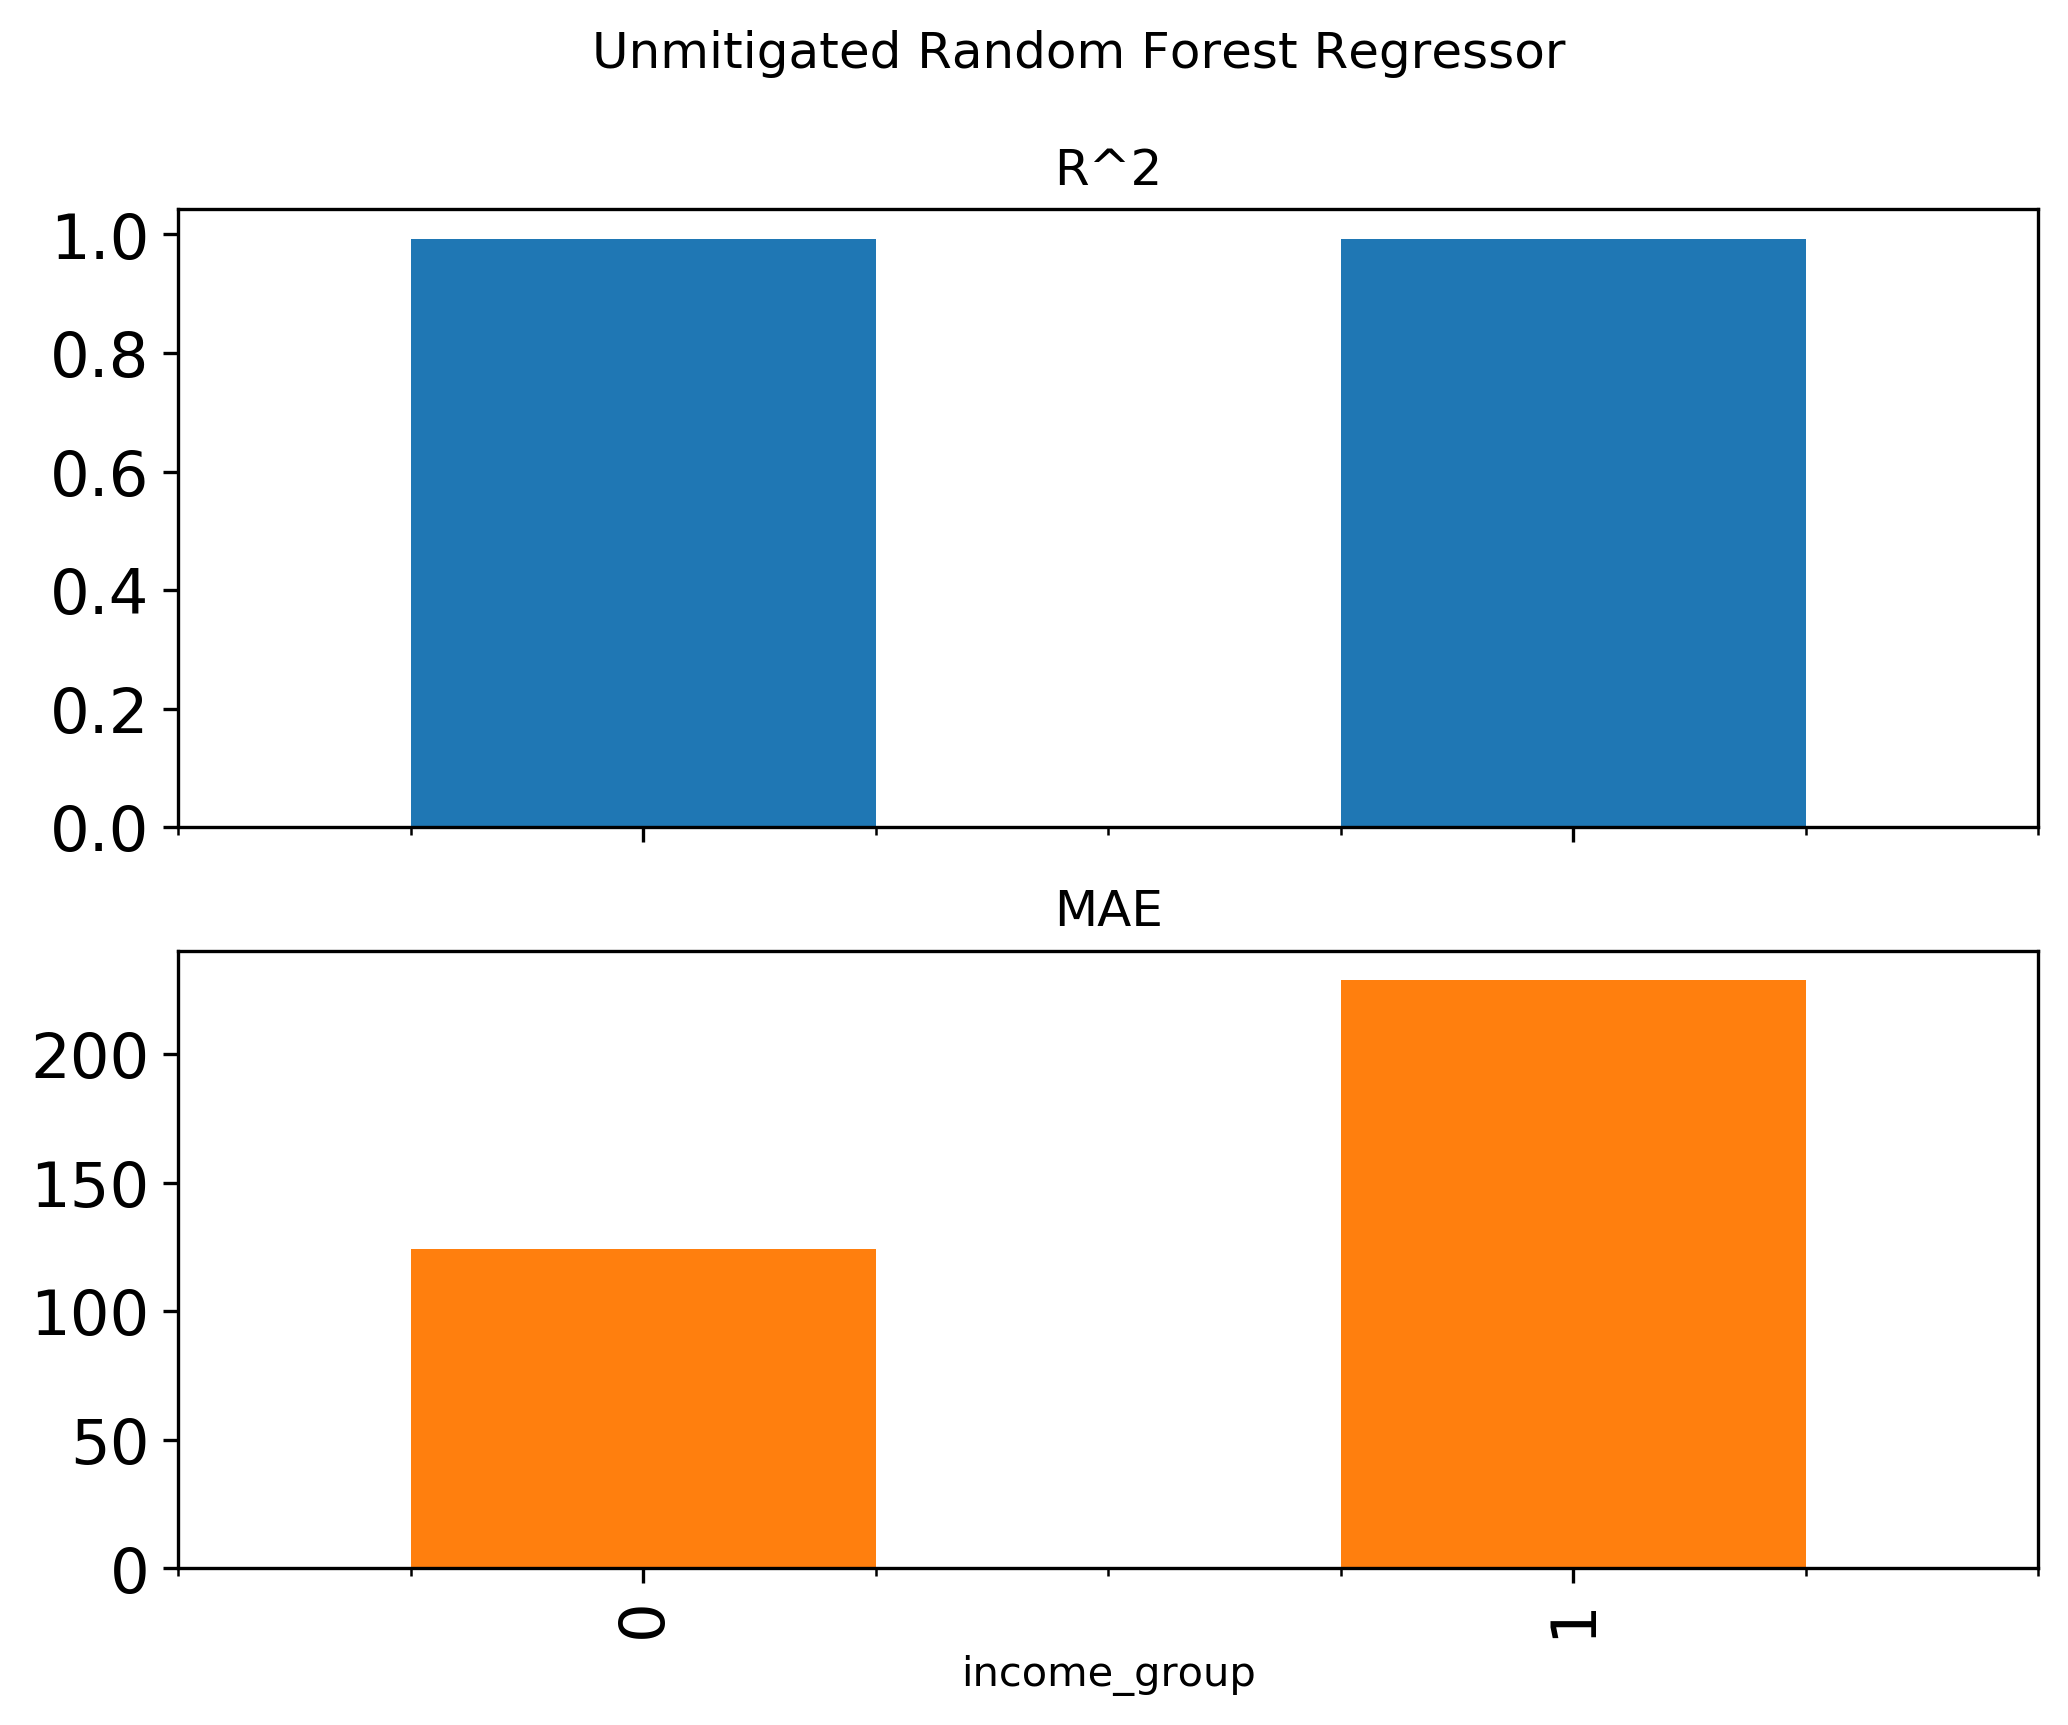

In [47]:
'''
Train set
'''

# rf_best = grid_search.best_estimator_
y_pred_rf_gs_train = rf_best.predict(X_train)

# Metric evaluation
metric_frame_rf_gs_train = MetricFrame(metric = 
                                    {"R^2": skm.r2_score,
                                    "MAE": skm.mean_absolute_error},
                                   sensitive_features = A_train,
                                   y_true = y_train,
                                   y_pred = y_pred_rf_gs_train)
print(metric_frame_rf_gs_train.overall)
print("-"*30)
print(metric_frame_rf_gs_train.by_group)
print("R^2 diff:", "{:.5f}".format(metric_frame_rf_gs_train.difference()["R^2"]))
print("MAE diff:", "{:.5f}".format(metric_frame_rf_gs_train.difference()["MAE"]))
print("-"*30)
# print("RFG:", rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num))

# # save model
# model_summary.loc["random_forest", "r2"] = metric_frame_rf_gs.overall["R^2"]
# model_summary.loc["random_forest", "mae"] = metric_frame_rf_gs.overall["MAE"]
# model_summary.loc["random_forest", "r2_diff"] = metric_frame_rf_gs.difference()["R^2"]
# model_summary.loc["random_forest", "mae_diff"] = metric_frame_rf_gs.difference()["MAE"]
# model_summary.loc["random_forest", "rfg"] = rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num)

# plot
metric_frame_rf_gs_train.by_group.plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='Unmitigated Random Forest Regressor', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY+"random_forest_metric"))

R^2       0.890693
MAE    1041.685093
dtype: object
------------------------------
                   R^2          MAE
income_group                       
0             0.839888   791.902347
1             0.892428  1102.043553
R^2 diff: 0.05254
MAE diff: 310.14121
------------------------------
RFG: 1270.553534181514


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ef9fad690>],
      dtype=object)

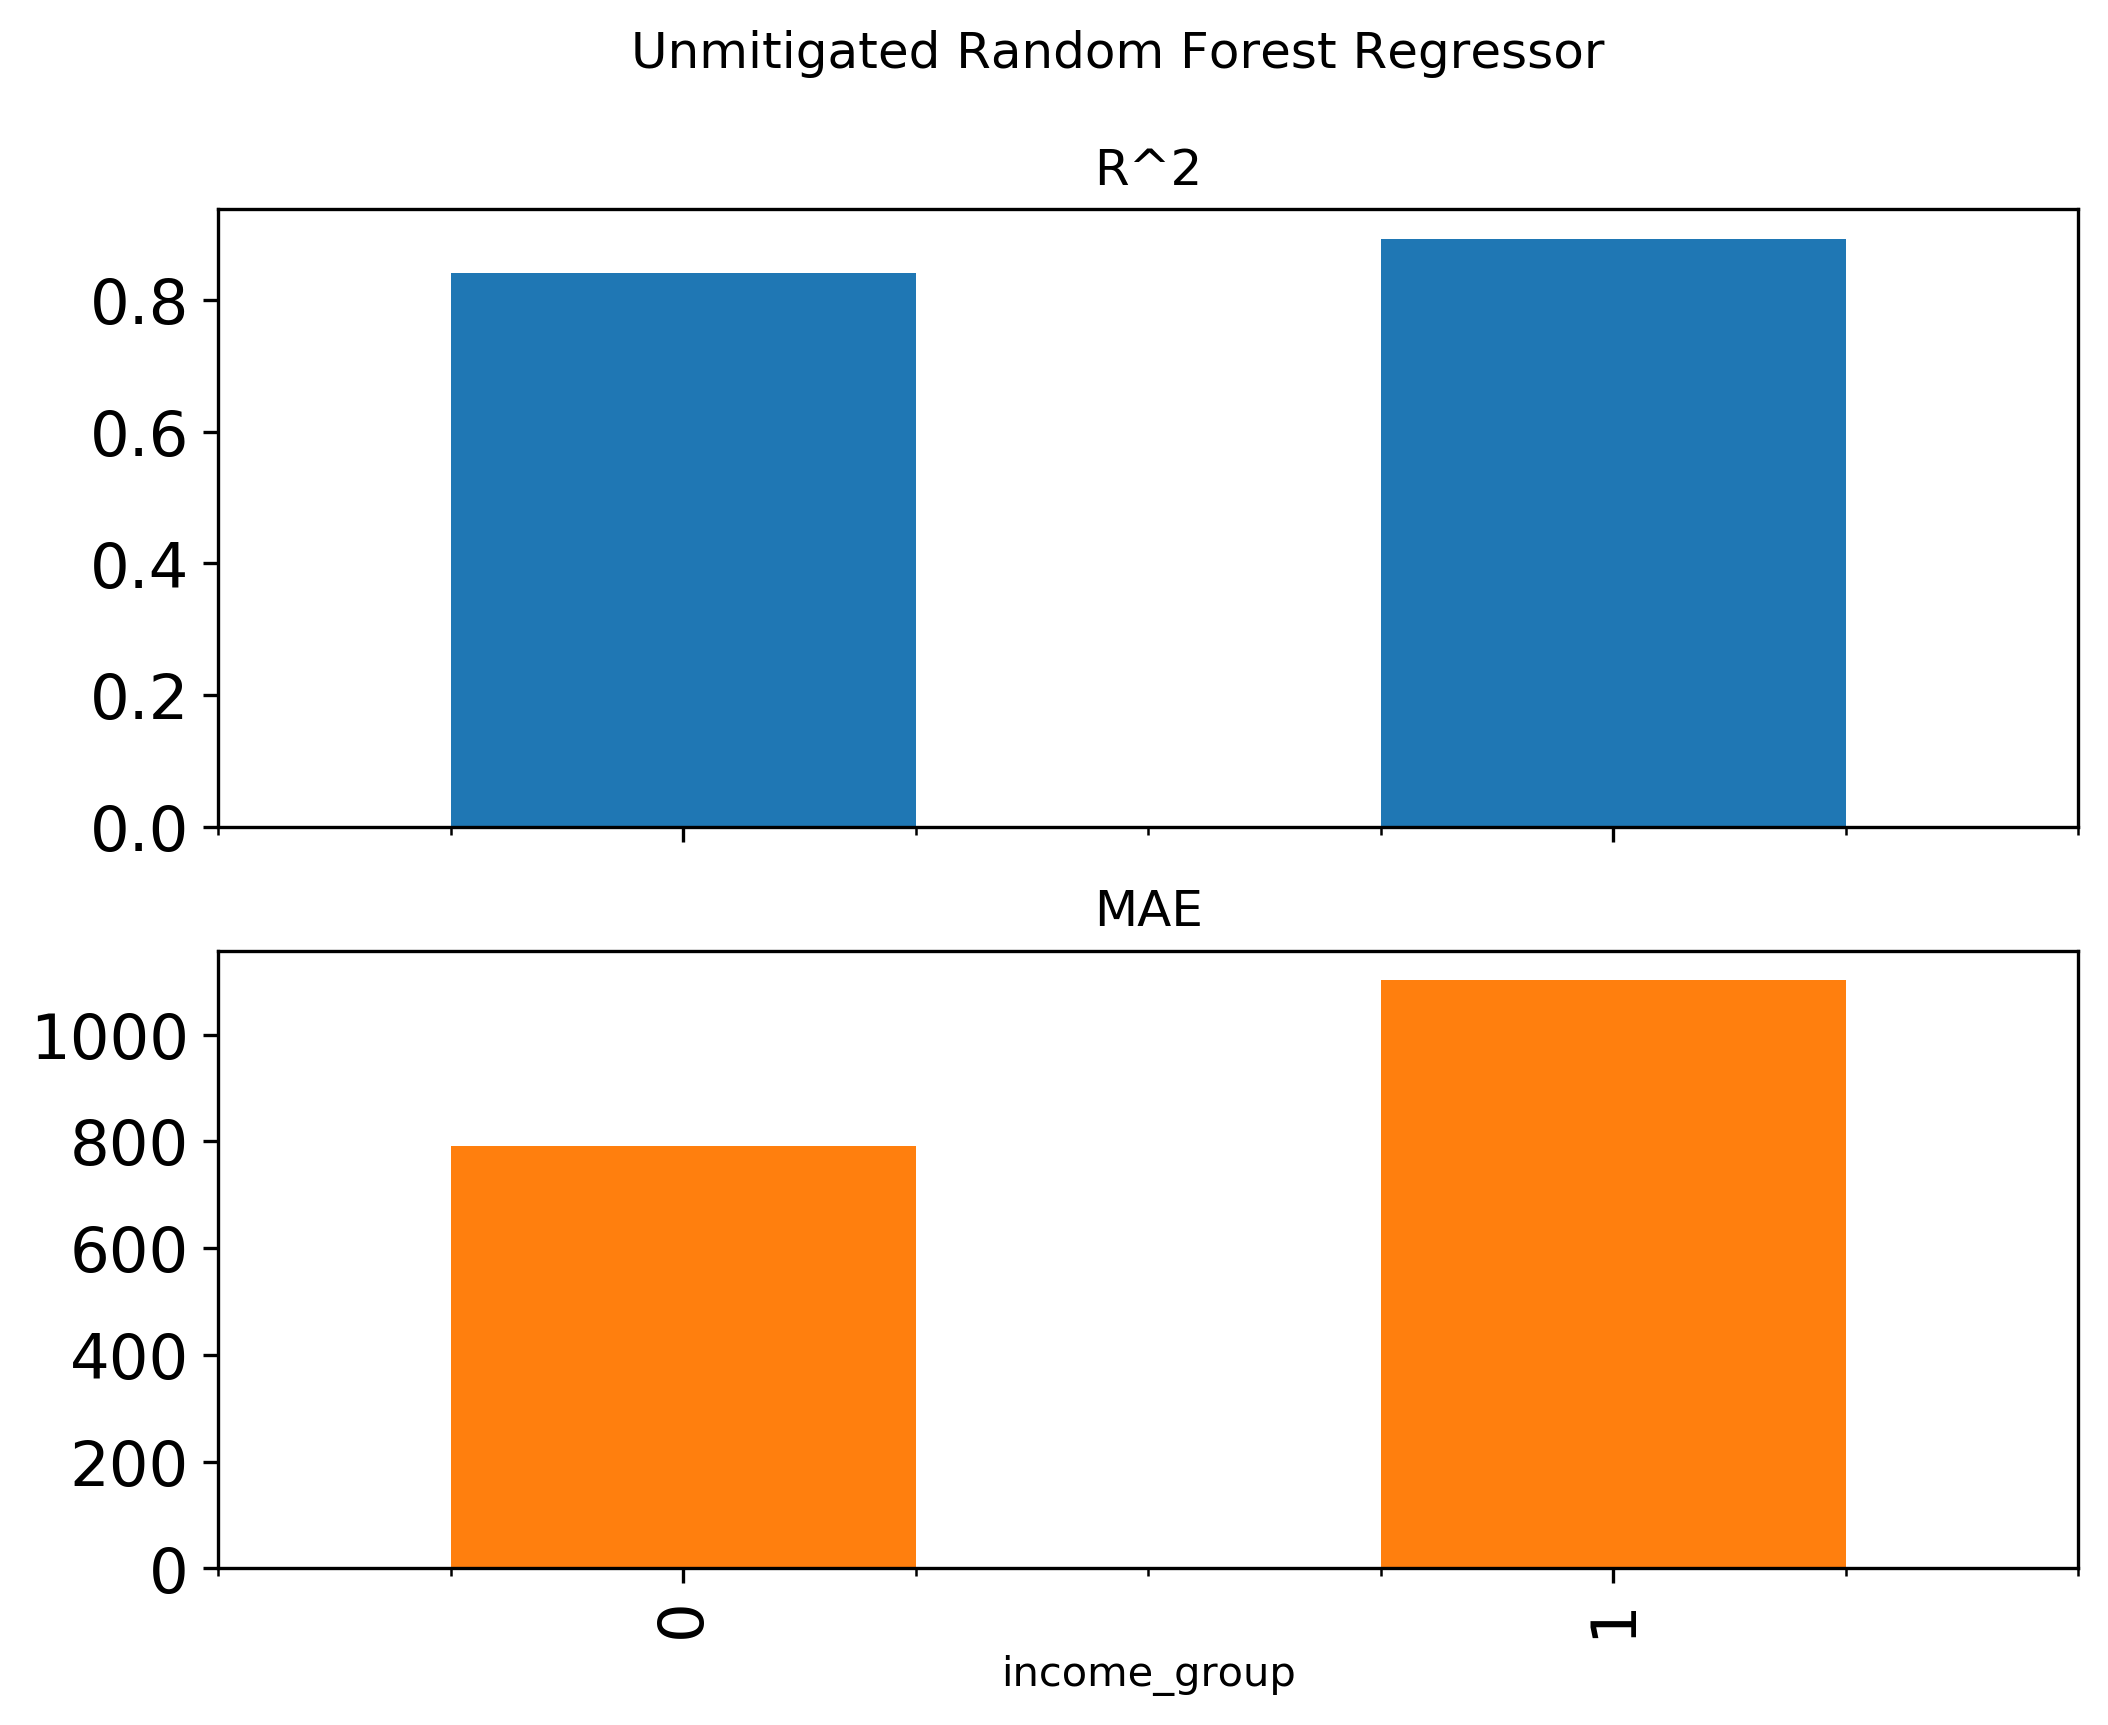

In [48]:
'''
Test set
'''
# rf_best = grid_search.best_estimator_
# rf_best = RandomForestRegressor(random_state = 42)
rf_best.fit(X_train, y_train)
y_pred_rf_gs = rf_best.predict(X_test)

# Metric evaluation
metric_frame_rf_gs = MetricFrame(metric = 
                                    {"R^2": skm.r2_score,
                                    "MAE": skm.mean_absolute_error},
                                   sensitive_features = A_test,
                                   y_true = y_test,
                                   y_pred = y_pred_rf_gs)
print(metric_frame_rf_gs.overall)
print("-"*30)
print(metric_frame_rf_gs.by_group)
print("R^2 diff:", "{:.5f}".format(metric_frame_rf_gs.difference()["R^2"]))
print("MAE diff:", "{:.5f}".format(metric_frame_rf_gs.difference()["MAE"]))
print("-"*30)
print("RFG:", rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num))

# save model
model_summary.loc["random_forest", "r2"] = metric_frame_rf_gs.overall["R^2"]
model_summary.loc["random_forest", "mae"] = metric_frame_rf_gs.overall["MAE"]
model_summary.loc["random_forest", "r2_diff"] = metric_frame_rf_gs.difference()["R^2"]
model_summary.loc["random_forest", "mae_diff"] = metric_frame_rf_gs.difference()["MAE"]
model_summary.loc["random_forest", "rfg"] = rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num)

# plot
metric_frame_rf_gs.by_group.plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='Unmitigated Random Forest Regressor', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY +"random_forest_metric"))

In [49]:
# without grid search
# R^2      0.892405
# MAE    997.766521
# dtype: object
# ------------------------------
#                    R^2          MAE
# income_group                       
# 0             0.838207   752.735919
# 1             0.894448  1056.639891
# R^2 diff: 0.05624
# MAE diff: 303.90397
# ------------------------------
# RFG: 1199.3840411041847

In [50]:
# # save model
# Pkl_Filename = "random_forest.pkl"  
# with open(os.path.join(save_dir_forecast, CITY +Pkl_Filename), 'wb') as file:  
#     pickle.dump(rf_best, file)

### 2) Exponentiated Gradient (constraint: BGL)

In [51]:
# # diff_bound_l = np.arange(0, 100000, 2000)/10000000
# # diff_bound_l = diff_bound_l[1:]
# # diff_bound_l = [0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5]

# # diff_bound_l = np.linspace(0.1, 2, 50)
# diff_bound_l = np.linspace(0, 500, 50)
# diff_bound_l

In [52]:
# # cross validation for EG
# # implement K-fold cross validation

# exp_grad_result = pd.DataFrame({"diff_bound": diff_bound_l})

# for i in range(len(diff_bound_l)):
#     cv_r2_ls = []
#     cv_mae_ls = []
#     cv_r2_diff_ls = []
#     cv_mae_diff_ls = []
    
#     print(i)
#     diff_bound = diff_bound_l[i]
    
#     # train-valid split
#     kfold = KFold(2, shuffle = True, random_state = 42)
#     for train, valid in kfold.split(X_train):
#         # print("CV")
#         X_train_exp = X_train.loc[train]
#         y_train_exp = y_train.loc[train]
#         A_train_exp = A_train.loc[train]

#         X_valid = X_train.loc[valid]
#         y_valid = y_train.loc[valid]
#         A_valid = A_train.loc[valid]

#         # avoid failure of optimization
#         try:
#             # train
#             constraint = BoundedGroupLoss(loss = AbsoluteLoss(-np.inf, np.inf), upper_bound = diff_bound)
#             exp_grad = ExponentiatedGradient(estimator = rf_best, constraints = constraint)
#             exp_grad.fit(X_train_exp, y_train_exp, sensitive_features = A_train_exp)
#             y_valid_pred = exp_grad.predict(X_valid, random_state = 42)

#             # performance validation #
#             metric_frame_eg_cv = MetricFrame(metric = {"R^2": skm.r2_score,  "MAE": skm.mean_absolute_error},
#                                             sensitive_features = A_valid, y_true = y_valid, y_pred = y_valid_pred)

#             cv_r2_ls.append(skm.r2_score(y_valid, y_valid_pred))
#             cv_mae_ls.append(skm.mean_absolute_error(y_valid, y_valid_pred))
#             cv_r2_diff_ls.append(metric_frame_eg_cv.difference()["R^2"])
#             cv_mae_diff_ls.append(metric_frame_eg_cv.difference()["MAE"])

#         except:
#             cv_r2_ls.append(np.nan)
#             cv_mae_ls.append(np.nan)
#             cv_r2_diff_ls.append(np.nan)
#             cv_mae_diff_ls.append(np.nan)

#     exp_grad_result.loc[i, "cv_avg_r2"] = np.nanmean(np.array(cv_r2_ls))
#     exp_grad_result.loc[i, "cv_avg_r2_diff"] = np.nanmean(np.array(cv_r2_diff_ls))
#     exp_grad_result.loc[i, "cv_avg_mae"] = np.nanmean(np.array(cv_mae_ls))
#     exp_grad_result.loc[i, "cv_avg_mae_diff"] = np.nanmean(np.array(cv_mae_diff_ls))

#     # exp_grad_result.to_csv(os.path.join(save_dir_models, CITY +"exp_grad_valid_res.csv"))

In [53]:
# array([183.67346939, 193.87755102, 204.08163265])
# array([234.69387755, 244.89795918, 255.10204082])
# array([275.51020408, 285.71428571])
# array([418.36734694, 428.57142857, 438.7755102 , 448.97959184,
#        459.18367347, 469.3877551 , 479.59183673, 489.79591837,
#        500.        ])

In [54]:
# best_eg_index = exp_grad_result[exp_grad_result.cv_avg_mae_diff == exp_grad_result.cv_avg_mae_diff.min()].index[0]
# print("best upper bound for BGL:", diff_bound_l[best_eg_index])

# # plot
# plt.figure(figsize = (25, 8))
# plt.plot(exp_grad_result.diff_bound, exp_grad_result.cv_avg_mae_diff)
# plt.scatter(exp_grad_result.iloc[exp_grad_result.cv_avg_mae_diff.argmin()].diff_bound, exp_grad_result.iloc[exp_grad_result.cv_avg_mae_diff.argmin()].cv_avg_mae_diff, color = "red")
# # plt.scatter(x = eg_result.diff_bound, y = eg_result.MSE_diff)
# plt.xlabel("upper bound in BGL", fontsize = 15)
# plt.ylabel("MAE difference", fontsize = 15)
# plt.text(x = exp_grad_result.iloc[exp_grad_result.cv_avg_mae_diff.argmin()].diff_bound+0.0005, y = exp_grad_result.iloc[exp_grad_result.cv_avg_mae_diff.argmin()].cv_avg_mae_diff, s = 'min', color = "red")
# plt.title("Cross Validation MAE diff for parameter 'upper_bound' \nin Bounded Group Loss for Exponentiated Gradient", fontsize = 18)
# plt.title("Exponentiated Gradient cross validation result: MAE difference vs. 'upper_bound' in BGL ", fontsize = 18)
# # plt.savefig(os.path.join(save_dir_models, CITY +"exp_grad_valid_res"))

____

In [1]:
exp_grad_result = pd.read_csv(os.path.join(save_dir_models, CITY +"exp_grad_valid_res.csv"), index_col = 0)

In [2]:
exp_grad_result_sorted = exp_grad_result.sort_values('cv_avg_mae_diff')
exp_grad_result_sorted.reset_index(drop = True, inplace = True)
exp_grad_result_sorted

### test

In [57]:
# eg_test = ExponentiatedGradient(estimator = rf_best, 
#                               constraints = BoundedGroupLoss(loss = AbsoluteLoss(-np.inf, np.inf), 
#                               upper_bound = 1000))
# eg_test.fit(X_train, y_train, sensitive_features = A_train)
# y_pred_eg_test = eg_test.predict(X_test, random_state = 42)

In [58]:
# metric_frame_eg_test = MetricFrame(metric = {"R^2": skm.r2_score,
#                                        "MAE": skm.mean_absolute_error},
#                            sensitive_features = A_test,
#                            y_true = y_test,
#                            y_pred = y_pred_eg_test)

# print(metric_frame_eg_test.overall)
# print("-"*30)
# print(metric_frame_eg_test.by_group)
# print()
# # print("R^2 diff:", "{:.5f}".format(metric_frame_eg.difference()["R^2"]))
# print("R^2 diff:",metric_frame_eg_test.difference()["R^2"])
# # print("MAE diff:", "{:.5f}".format(metric_frame_eg.difference()["MAE"]))
# print("MAE diff:", metric_frame_eg_test.difference()["MAE"])
# print("-"*30)
# print("RFG:", rfg_calc(y_pred_eg_test, y_test, normalized_pop_df, y_test_cell_num))

# # save model
# model_summary.loc["exp_grad", "r2"] = metric_frame_eg_test.overall["R^2"]
# model_summary.loc["exp_grad", "mae"] = metric_frame_eg_test.overall["MAE"]
# model_summary.loc["exp_grad", "r2_diff"] = metric_frame_eg_test.difference()["R^2"]
# model_summary.loc["exp_grad", "mae_diff"] = metric_frame_eg_test.difference()["MAE"]
# model_summary.loc["exp_grad", "rfg"] = rfg_calc(y_pred_eg_test, y_test, normalized_pop_df, y_test_cell_num)

# metric_frame_eg_test.by_group.plot.bar(
#         subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
#         title='Exponentiated Gradient w/ BGL', fontsize = 15)
# # plt.savefig(os.path.join(save_dir_models, CITY +"exp_grad_metric"))

______

In [59]:
# # predict on test set
# eg_best = ExponentiatedGradient(estimator = rf_best, 
#                               constraints = BoundedGroupLoss(loss = AbsoluteLoss(-np.inf, np.inf), 
#                               upper_bound = exp_grad_result_sorted.diff_bound[0]))

# eg_best.fit(X_train, y_train, sensitive_features = A_train)
# y_pred_eg = eg_best.predict(X_test, random_state = 42)

In [60]:
# # save model
# Pkl_Filename = "exp_grad.pkl"  
# with open(os.path.join(save_dir_forecast, CITY +Pkl_Filename), 'wb') as file:  
#     cloudpickle.dump(eg_best, file)

In [61]:
eg_best = cloudpickle.load(open(os.path.join(save_dir_models, CITY + "exp_grad.pkl"), 'rb'))
y_pred_eg = eg_best.predict(X_test, random_state = 42)

R^2       0.99284
MAE    208.140689
dtype: object
------------------------------
                   R^2         MAE
income_group                      
0              0.99224  124.609606
1             0.992649  227.976258

R^2 diff: 0.00040900800003718096
MAE diff: 103.36665197488966
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f0019b310>],
      dtype=object)

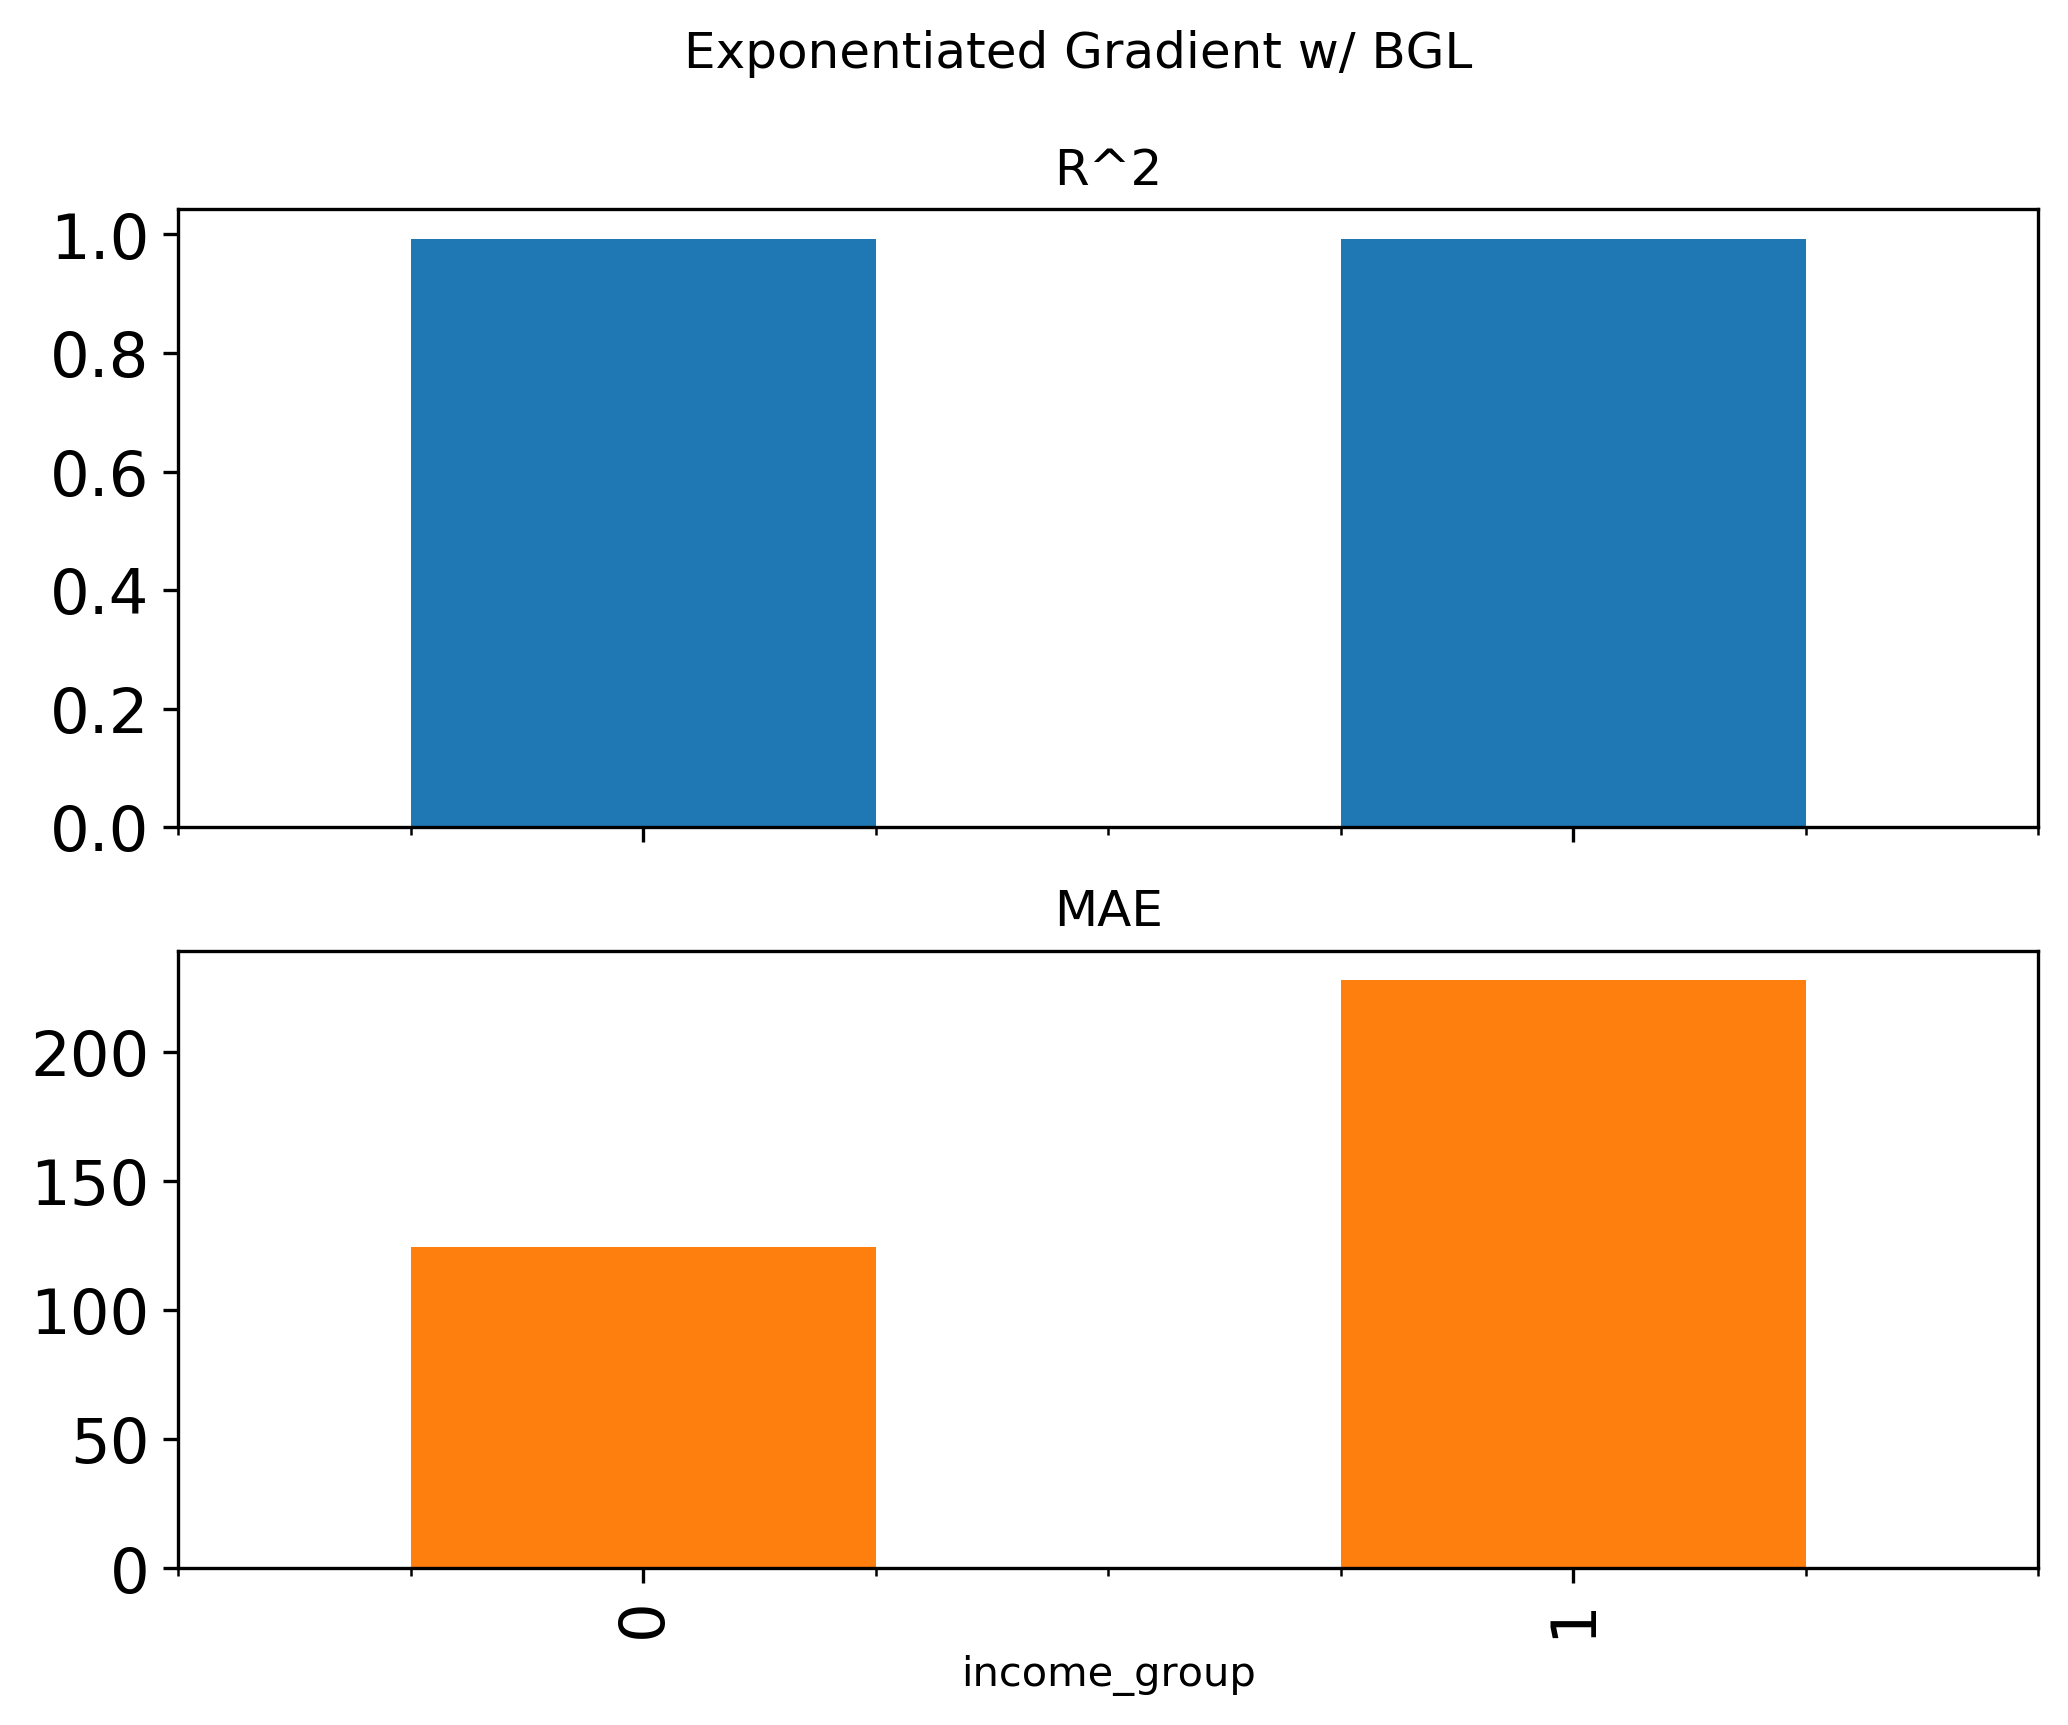

In [62]:
'''
TRAINING SET
'''
y_train_pred = eg_best.predict(X_train, random_state = 42)
metric_frame_eg_train = MetricFrame(metric = {"R^2": skm.r2_score,
                                       "MAE": skm.mean_absolute_error},
                           sensitive_features = A_train,
                           y_true = y_train,
                           y_pred = y_train_pred)

print(metric_frame_eg_train.overall)
print("-"*30)
print(metric_frame_eg_train.by_group)
print()
# print("R^2 diff:", "{:.5f}".format(metric_frame_eg.difference()["R^2"]))
print("R^2 diff:",metric_frame_eg_train.difference()["R^2"])
# print("MAE diff:", "{:.5f}".format(metric_frame_eg.difference()["MAE"]))
print("MAE diff:", metric_frame_eg_train.difference()["MAE"])
print("-"*30)
# print("RFG:", rfg_calc(y_train_pred, y_train, normalized_pop_df, y_test_cell_num))

# save model
# model_summary.loc["exp_grad", "r2"] = metric_frame_eg.overall["R^2"]
# model_summary.loc["exp_grad", "mae"] = metric_frame_eg.overall["MAE"]
# model_summary.loc["exp_grad", "r2_diff"] = metric_frame_eg.difference()["R^2"]
# model_summary.loc["exp_grad", "mae_diff"] = metric_frame_eg.difference()["MAE"]
# model_summary.loc["exp_grad", "rfg"] = rfg_calc(y_pred_eg, y_test, normalized_pop_df, y_test_cell_num)

metric_frame_eg_train.by_group.plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='Exponentiated Gradient w/ BGL', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY+"exp_grad_metric"))

R^2       0.890825
MAE    1041.656019
dtype: object
------------------------------
                   R^2          MAE
income_group                       
0             0.840763   792.253356
1             0.892502  1101.922636

R^2 diff: 0.0517388197509383
MAE diff: 309.66927960736814
------------------------------
RFG: 1270.959372251064


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ed913c4d0>],
      dtype=object)

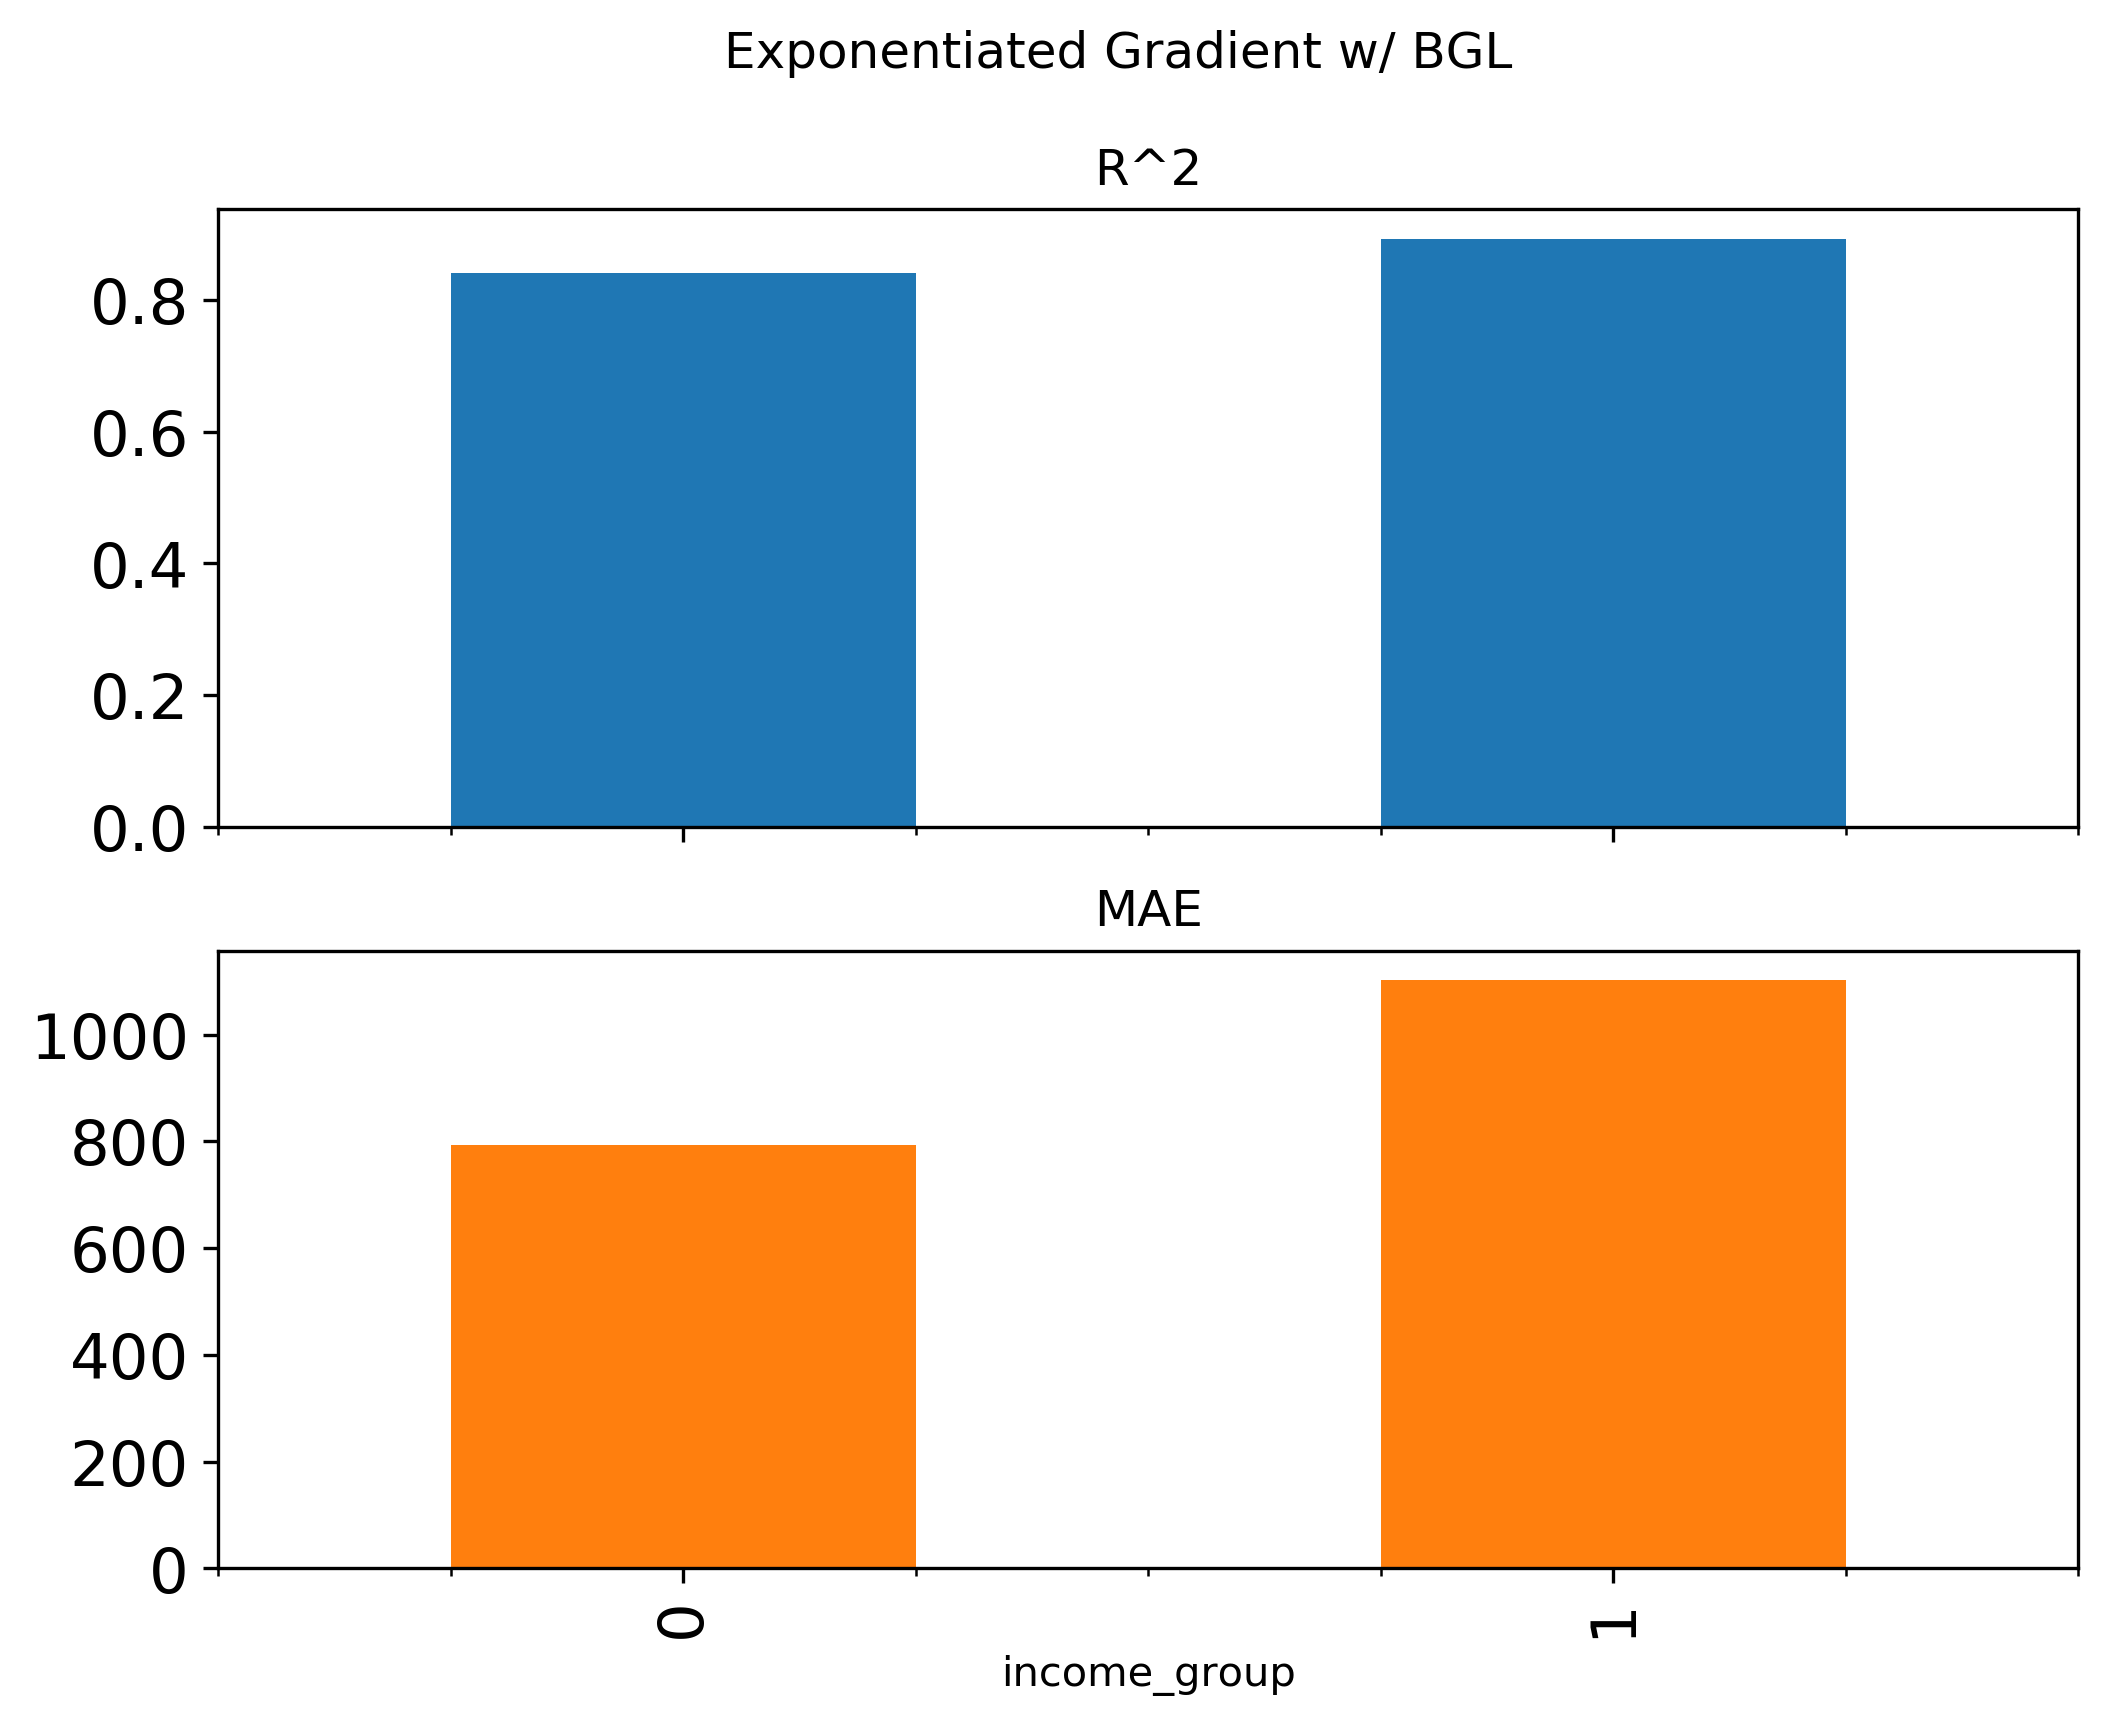

In [63]:
'''
TEST SET
'''
metric_frame_eg = MetricFrame(metric = {"R^2": skm.r2_score,
                                       "MAE": skm.mean_absolute_error},
                           sensitive_features = A_test,
                           y_true = y_test,
                           y_pred = y_pred_eg)

print(metric_frame_eg.overall)
print("-"*30)
print(metric_frame_eg.by_group)
print()
# print("R^2 diff:", "{:.5f}".format(metric_frame_eg.difference()["R^2"]))
print("R^2 diff:",metric_frame_eg.difference()["R^2"])
# print("MAE diff:", "{:.5f}".format(metric_frame_eg.difference()["MAE"]))
print("MAE diff:", metric_frame_eg.difference()["MAE"])
print("-"*30)
print("RFG:", rfg_calc(y_pred_eg, y_test, normalized_pop_df, y_test_cell_num))

# save model
model_summary.loc["exp_grad", "r2"] = metric_frame_eg.overall["R^2"]
model_summary.loc["exp_grad", "mae"] = metric_frame_eg.overall["MAE"]
model_summary.loc["exp_grad", "r2_diff"] = metric_frame_eg.difference()["R^2"]
model_summary.loc["exp_grad", "mae_diff"] = metric_frame_eg.difference()["MAE"]
model_summary.loc["exp_grad", "rfg"] = rfg_calc(y_pred_eg, y_test, normalized_pop_df, y_test_cell_num)

metric_frame_eg.by_group.plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='Exponentiated Gradient w/ BGL', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY +"exp_grad_metric"))

### 3) Grid Search (constraint: BGL)

In [64]:
# def calc_dominant_avg_res(predictors, X_valid, y_valid, A_valid):
    
#     # Loop through all predictors
#     r2_all = []
#     mae_diff_all = []

#     for i in range(len(predictors)):
#         metric_frame = MetricFrame(metric = {"R^2": skm.r2_score, "MAE": skm.mean_absolute_error}, sensitive_features = A_valid,
#                                    y_true = y_valid, y_pred = predictors[i].predict(X_valid))
#         mae_diff_all.append(metric_frame.difference()['MAE'])
#         r2_all.append(metric_frame.overall["R^2"])
    
#     # get dominant models
#     all_results = pd.DataFrame({"predictors:": predictors, "r2": r2_all, "diff": mae_diff_all})
#     dominated = []
#     for row in all_results.itertuples():
#         '''
#         want the models that have the high R^2 with low difference
#         thus, we select model M if all of other models with higher R^2 than M also have higher difference than M.
#         # i.e. M has the lowest difference among all of the models that have higher R^2 than it.
#         '''
#         difference = all_results["diff"][all_results["r2"] >= row.r2]
#         if row.diff <= difference.min():
#             dominated.append(row[1])
    
#     # loop all of the dominated models
#     r2_dominated = []
#     r2_diff_dominated = []
#     mae_dominated = []
#     mae_diff_dominated = []
    
#     for i in range(len(dominated)):
#         metric_frame_dominated = MetricFrame(metric={"R^2": skm.r2_score,
#                                            "MAE": skm.mean_absolute_error
#                                            },
#                                    sensitive_features = A_valid,
#                                    y_true = y_valid,
#                                    y_pred = dominated[i].predict(X_valid))

#         r2_dominated.append(metric_frame.overall["R^2"])
#         r2_diff_dominated.append(metric_frame_dominated.difference()['R^2'])
#         mae_dominated.append(metric_frame_dominated.overall["MAE"])
#         mae_diff_dominated.append(metric_frame_dominated.difference()['MAE'])
        
#     r2_dominated = np.array(r2_dominated)
#     r2_diff_dominated = np.array(r2_diff_dominated)
#     mae_dominated = np.array(mae_dominated)
#     mae_diff_dominated = np.array(mae_diff_dominated)

#     return np.nanmean(r2_dominated), np.nanmean(r2_diff_dominated), np.nanmean(mae_dominated), np.nanmean(mae_diff_dominated), dominated

In [65]:
# # cross validation for grid search 
# # implement K-fold cross validation
# grid_size_ls = np.arange(0, 22, 2)[1:]

# grid_search_result = pd.DataFrame({"grid_size": grid_size_ls})

# for i in np.arange(len(grid_size_ls)):
#     print(i)
#     g_size = grid_size_ls[i]
    
#     # train-valid split
#     kfold = KFold(3, shuffle = True, random_state = 42)
#     for train, valid in kfold.split(X_train):
#         # print("CV")
#         X_train_gs = X_train.loc[train]
#         y_train_gs = y_train.loc[train]
#         A_train_gs = A_train.loc[train]

#         X_valid = X_train.loc[valid]
#         y_valid = y_train.loc[valid]
#         A_valid = A_train.loc[valid]

#         # avoid failure of optimization
#         try:
#             # train
#             mitigator = GridSearch(estimator = rf_best,
#                        constraints = BoundedGroupLoss(loss = AbsoluteLoss(-np.inf, np.inf), upper_bound = diff_bound_l[best_eg_index]),
#                        grid_size = g_size)

#             mitigator.fit(X_train_gs, y_train_gs, sensitive_features = A_train_gs)
#             predictors = mitigator.predictors_

#             # calculate dominant models res
#             dominant_res = calc_dominant_avg_res(predictors, X_valid, y_valid, A_valid)

#             grid_search_result.loc[i, "cv_avg_r2"] = dominant_res[0]
#             grid_search_result.loc[i, "cv_avg_r2_diff"] = dominant_res[1]
#             grid_search_result.loc[i, "cv_avg_mae"] = dominant_res[2]
#             grid_search_result.loc[i, "cv_avg_mae_diff"] = dominant_res[3]

#         except:
#             grid_search_result.loc[i, "cv_avg_r2"] = np.nan
#             grid_search_result.loc[i, "cv_avg_r2_diff"] = np.nan
#             grid_search_result.loc[i, "cv_avg_mae"] = np.nan
#             grid_search_result.loc[i, "cv_avg_mae_diff"] = np.nan

#     grid_search_result.to_csv(os.path.join(save_dir_models, CITY +"grid_search_valid_res.csv"))

In [66]:
# grid_search_result

In [67]:
# best_gs_index = grid_search_result[grid_search_result.cv_avg_mae_diff == grid_search_result.cv_avg_mae_diff.min()].index[0]
# print("best grid size for Grid Search:", grid_size_ls[best_gs_index])

# # plot
# plt.figure(figsize = (25, 8))
# plt.plot(grid_search_result.grid_size, grid_search_result.cv_avg_mae_diff)
# plt.scatter(grid_search_result.iloc[grid_search_result.cv_avg_mae_diff.argmin()].grid_size, grid_search_result.iloc[grid_search_result.cv_avg_mae_diff.argmin()].cv_avg_mae_diff, color = "red")
# # plt.scatter(x = eg_result.diff_bound, y = eg_result.MSE_diff)
# plt.xlabel("upper bound in BGL", fontsize = 15)
# plt.ylabel("MAE difference", fontsize = 15)
# plt.text(x = grid_search_result.iloc[grid_search_result.cv_avg_mae_diff.argmin()].grid_size+0.0005, y = grid_search_result.iloc[grid_search_result.cv_avg_mae_diff.argmin()].cv_avg_mae_diff, s = 'min', color = "red")
# plt.title("Cross Validation MAE diff for parameter 'upper_bound' \nin Bounded Group Loss for Exponentiated Gradient", fontsize = 18)
# plt.title("Grid Search cross validation result: MAE difference vs. 'grid_size'", fontsize = 18)
# plt.savefig(os.path.join(save_dir_models, CITY +"grid_search_valid_res"))

In [68]:
# # get all predictors according to best grid size
# mitigator = GridSearch(estimator = rf_best,
#                        constraints = BoundedGroupLoss(loss = AbsoluteLoss(-np.inf, np.inf), upper_bound = diff_bound_l[best_eg_index]),
#                        grid_size = grid_size_ls[best_gs_index])

In [69]:
kfold = KFold(2, shuffle = True, random_state = 42)

# randomly get train valid set
for train, valid in kfold.split(X_train):
    # print("CV")
    X_train_gs = X_train.loc[train]
    y_train_gs = y_train.loc[train]
    A_train_gs = A_train.loc[train]

    X_valid = X_train.loc[valid]
    y_valid = y_train.loc[valid]
    A_valid = A_train.loc[valid]

In [70]:
# len(predictors)

In [72]:
# # get all predictors according to best grid size
# mae_diff_all = []
# r2_all = []

# mitigator = GridSearch(estimator = rf_best,
#                        constraints = BoundedGroupLoss(loss = AbsoluteLoss(-np.inf, np.inf), upper_bound = exp_grad_result_sorted.diff_bound[0]),
#                        grid_size = 200)

# mitigator.fit(X_train_gs, y_train_gs, sensitive_features = A_train_gs)
# predictors = mitigator.predictors_

In [73]:
# # get dominant model on valid set
# for i in range(len(predictors)):
#     metric_frame = MetricFrame(metric = {"R^2": skm.r2_score, "MAE": skm.mean_absolute_error}, 
#                                sensitive_features = A_valid,
#                                y_true = y_valid, 
#                                y_pred = predictors[i].predict(X_valid))
#     mae_diff_all.append(metric_frame.difference()['MAE'])
#     r2_all.append(metric_frame.overall["R^2"])


# # get dominant models
# all_results = pd.DataFrame({"predictors:": predictors, "r2": r2_all, "diff": mae_diff_all})
# gs_dominant_final = []

# for row in all_results.itertuples():
#     '''
#     want the models that have the high R^2 with low difference
#     thus, we select model M if all of other models with higher R^2 than M also have higher difference than M.
#     # i.e. M has the lowest difference among all of the models that have higher R^2 than it.
#     '''
#     difference = all_results["diff"][all_results["r2"] >= row.r2]
#     if row.diff <= difference.min():
#         gs_dominant_final.append(row[1])

In [74]:
# # loop all of the dominant models on test set
# r2_dominated = []
# mae_diff_dominated = []

# for i in range(len(gs_dominant_final)):
#     metric_frame_dominant = MetricFrame(metric={"R^2": skm.r2_score,
#                                        "MAE": skm.mean_absolute_error},
#                                sensitive_features = A_test,
#                                y_true = y_test,
#                                y_pred = gs_dominant_final[i].predict(X_test))

#     mae_diff_dominated.append(metric_frame_dominant.difference()['MAE'])
#     r2_dominated.append(metric_frame_dominant.overall["R^2"])

In [75]:
# # calculate gs model with lowest MAE diff
# gs_least_mae_idx = np.argmin(np.array(mae_diff_dominated))
# gs_least_mae_idx

In [76]:
gs_dominant_model = pickle.load(open(os.path.join(save_dir_models, CITY + "grid_search.pkl"), 'rb'))

#### Selected Grid Search model

R^2      0.966463
MAE    447.545529
dtype: object
------------------------------
                  R^2         MAE
income_group                     
0             0.94977  318.927629
1             0.96655  478.087564

R^2 diff: 0.01678
MAE diff: 159.15993
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f00601590>],
      dtype=object)

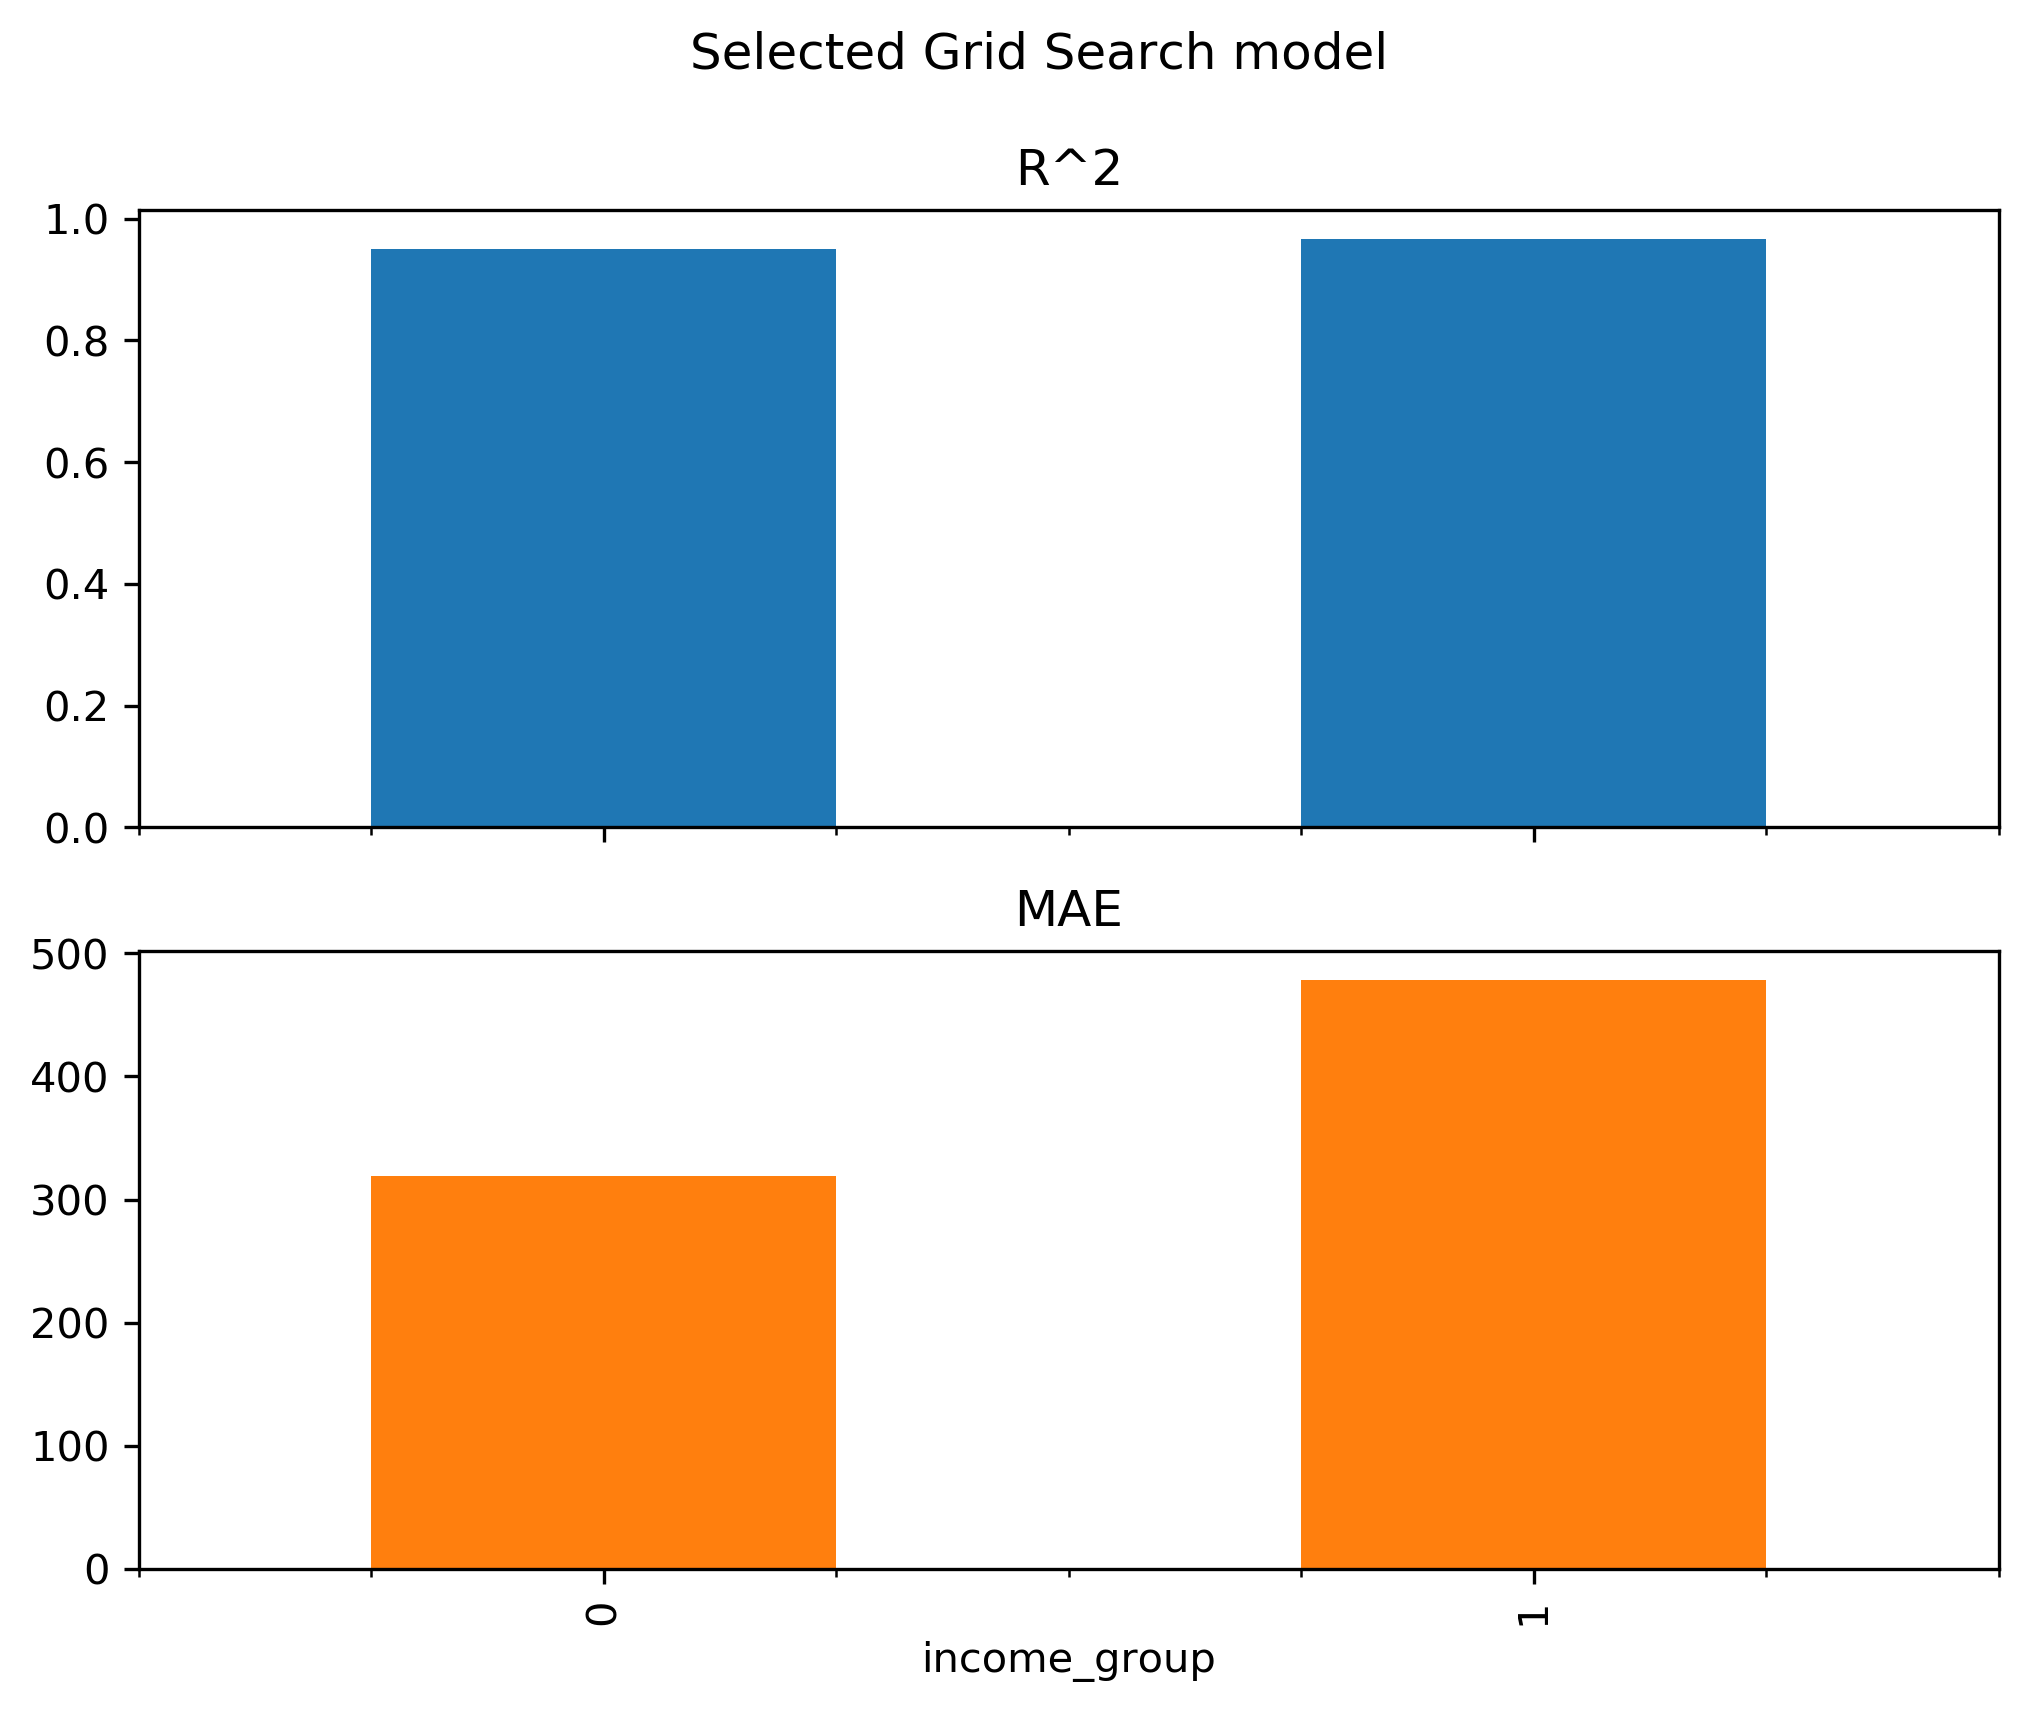

In [77]:
'''
Train set
'''
# gs_dominant_model = gs_dominant_final[gs_least_mae_idx]
y_pred_gs_train = gs_dominant_model.predict(X_train)
metric_frame_gs_train = MetricFrame(metric = {"R^2": skm.r2_score,
                                       "MAE": skm.mean_absolute_error},
                               sensitive_features = A_train,
                               y_true = y_train,
                               y_pred = y_pred_gs_train)

print(metric_frame_gs_train.overall)
print("-"*30)
print(metric_frame_gs_train.by_group)
print()
print("R^2 diff:", "{:.5f}".format(metric_frame_gs_train.difference()["R^2"]))
print("MAE diff:", "{:.5f}".format(metric_frame_gs_train.difference()["MAE"]))
print("-"*30)

# # save model
# model_summary.loc["grid_search", "r2"] = metric_frame_gs_train.overall["R^2"]
# model_summary.loc["grid_search", "mae"] = metric_frame_gs_train.overall["MAE"]
# model_summary.loc["grid_search", "r2_diff"] = metric_frame_gs_train.difference()["R^2"]
# model_summary.loc["grid_search", "mae_diff"] = metric_frame_gs_train.difference()["MAE"]
# model_summary.loc["grid_search", "rfg"] = rfg_calc(y_pred_gs, y_test, normalized_pop_df, y_test_cell_num)

# print("RFG:", rfg_calc(y_pred_gs, y_test, normalized_pop_df, y_test_cell_num))
metric_frame_gs_train.by_group.plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='Selected Grid Search model')

# plt.savefig(os.path.join(save_dir_models, CITY+"grid_search_metric"))

R^2       0.893809
MAE    1009.824303
dtype: object
------------------------------
                   R^2          MAE
income_group                       
0              0.84711   760.603061
1             0.895276  1070.047079

R^2 diff: 0.04817
MAE diff: 309.44402
------------------------------
RFG: 1206.0802455991757


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f27c51950>],
      dtype=object)

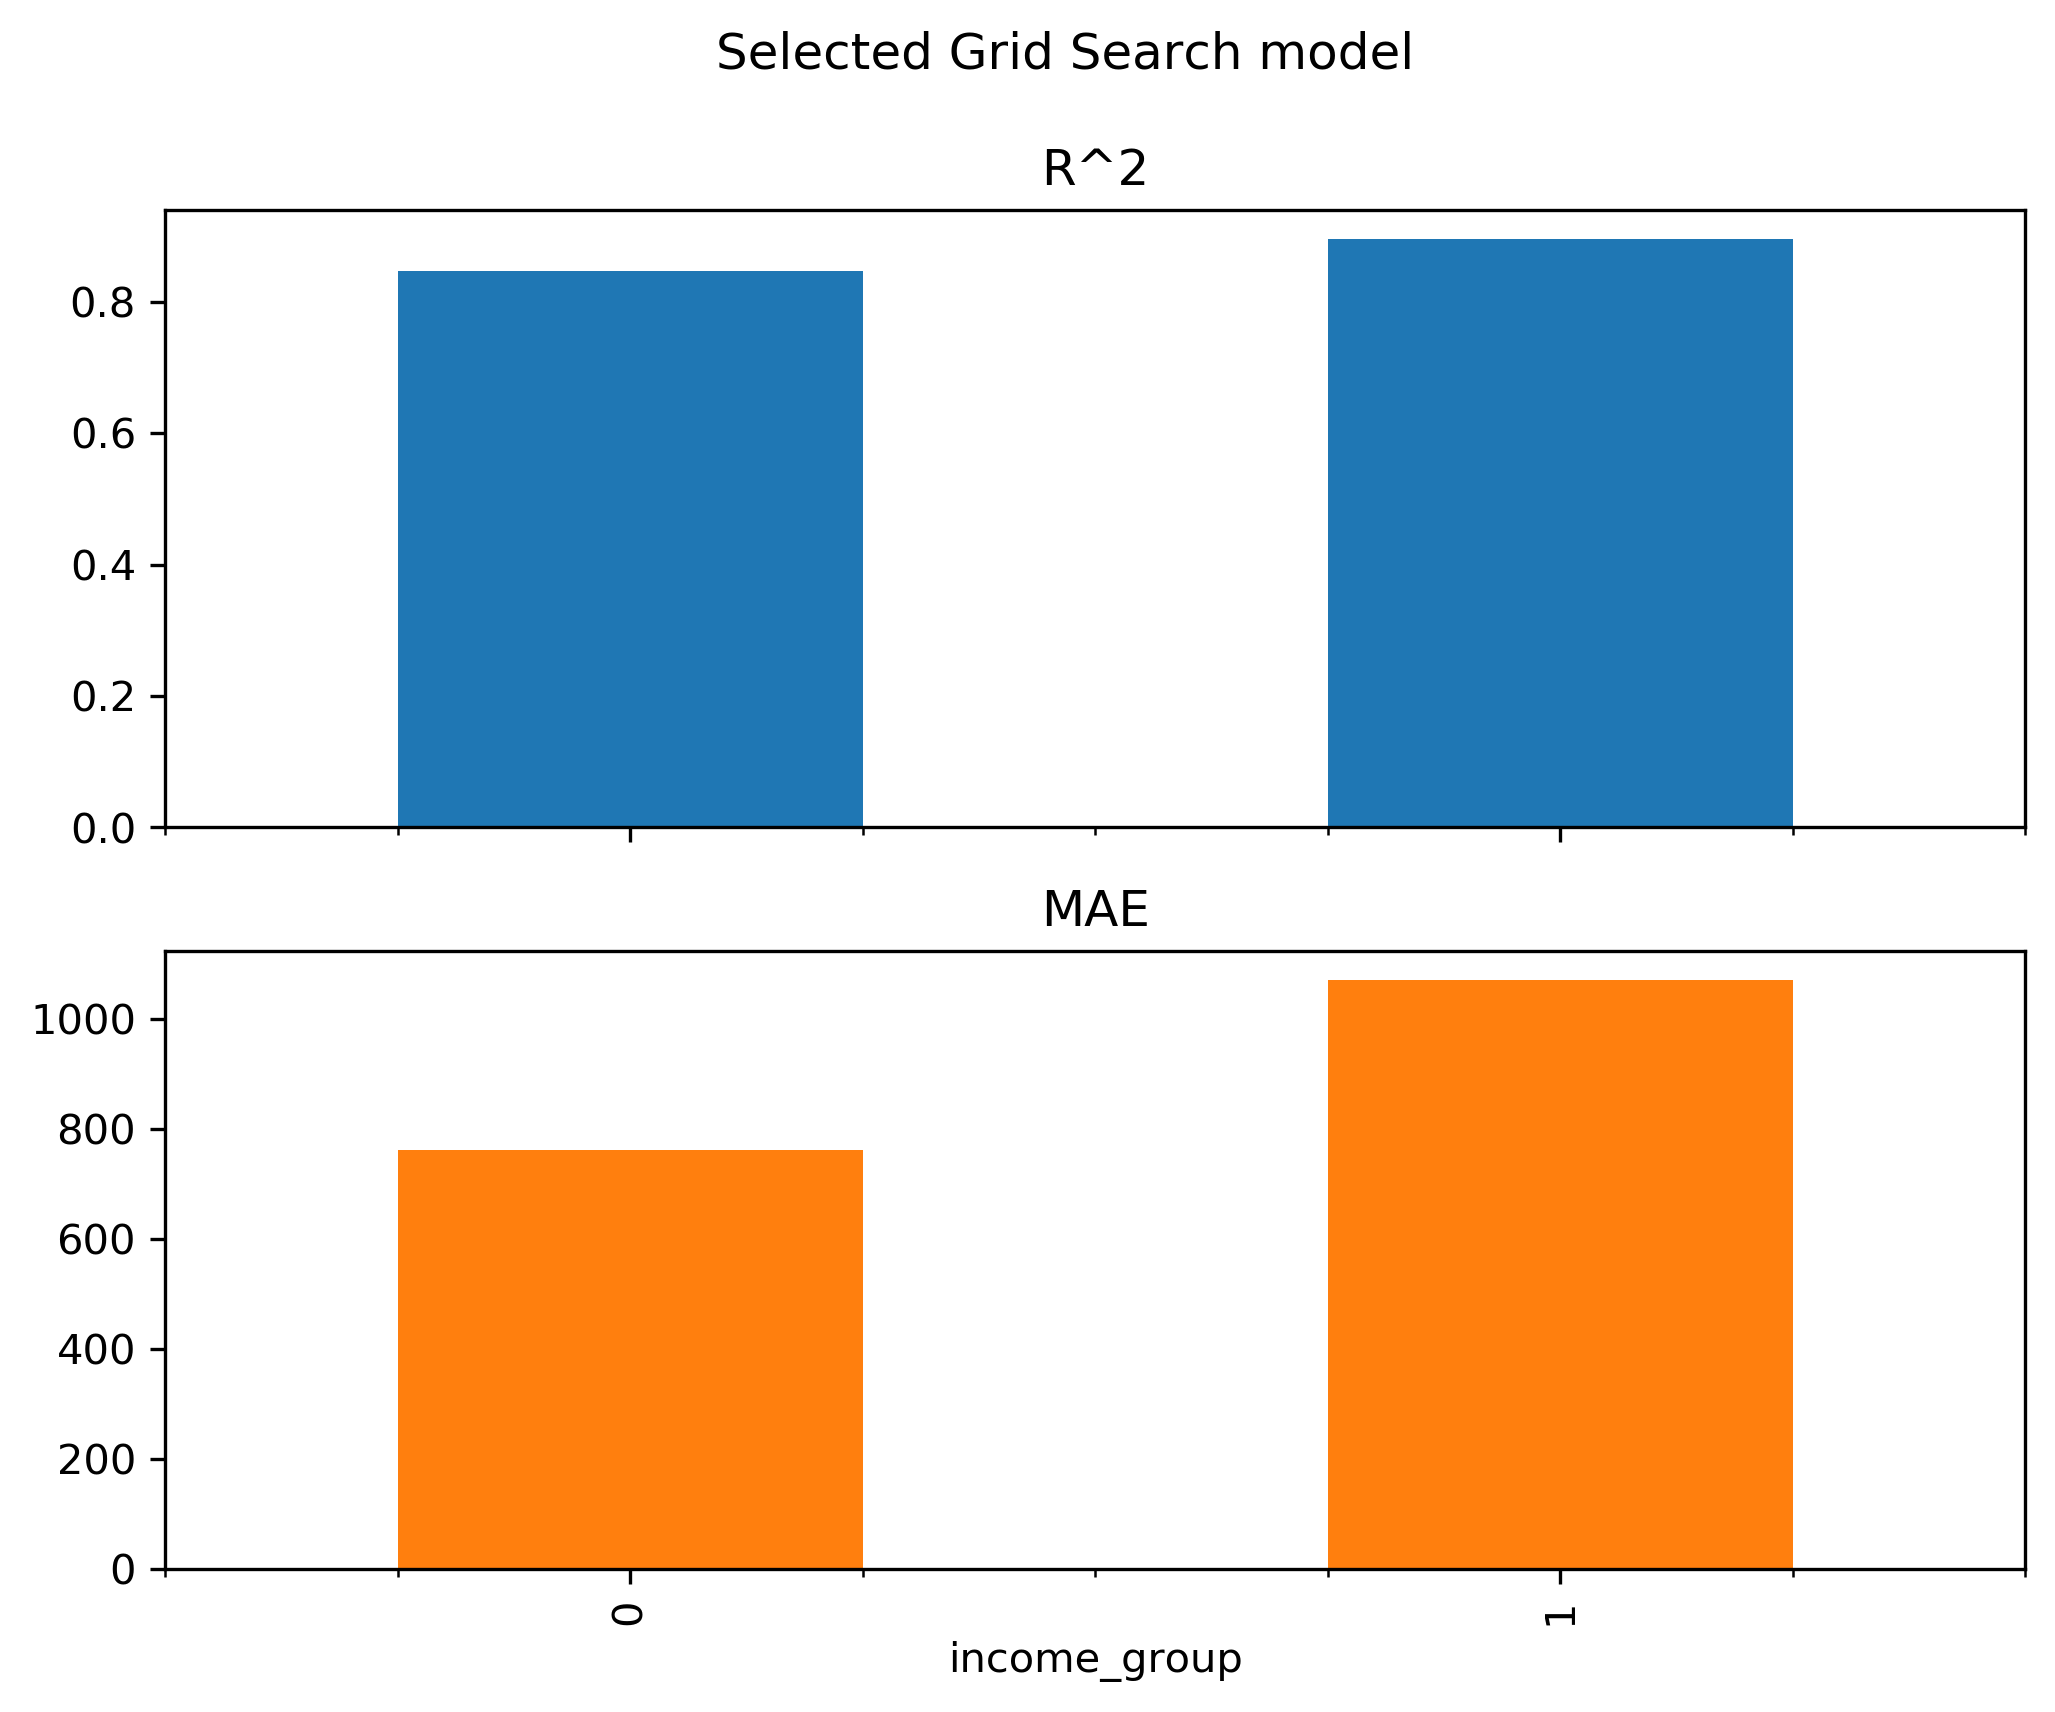

In [78]:
'''
TEST SET
'''
# gs_dominant_model = gs_dominant_final[gs_least_mae_idx]
y_pred_gs = gs_dominant_model.predict(X_test)
metric_frame_gs = MetricFrame(metric = {"R^2": skm.r2_score,
                                       "MAE": skm.mean_absolute_error},
                               sensitive_features = A_test,
                               y_true = y_test,
                               y_pred = y_pred_gs)

print(metric_frame_gs.overall)
print("-"*30)
print(metric_frame_gs.by_group)
print()
print("R^2 diff:", "{:.5f}".format(metric_frame_gs.difference()["R^2"]))
print("MAE diff:", "{:.5f}".format(metric_frame_gs.difference()["MAE"]))
print("-"*30)

# save model
model_summary.loc["grid_search", "r2"] = metric_frame_gs.overall["R^2"]
model_summary.loc["grid_search", "mae"] = metric_frame_gs.overall["MAE"]
model_summary.loc["grid_search", "r2_diff"] = metric_frame_gs.difference()["R^2"]
model_summary.loc["grid_search", "mae_diff"] = metric_frame_gs.difference()["MAE"]
model_summary.loc["grid_search", "rfg"] = rfg_calc(y_pred_gs, y_test, normalized_pop_df, y_test_cell_num)

print("RFG:", rfg_calc(y_pred_gs, y_test, normalized_pop_df, y_test_cell_num))
metric_frame_gs.by_group.plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='Selected Grid Search model')

# plt.savefig(os.path.join(save_dir_models, CITY +"grid_search_metric"))

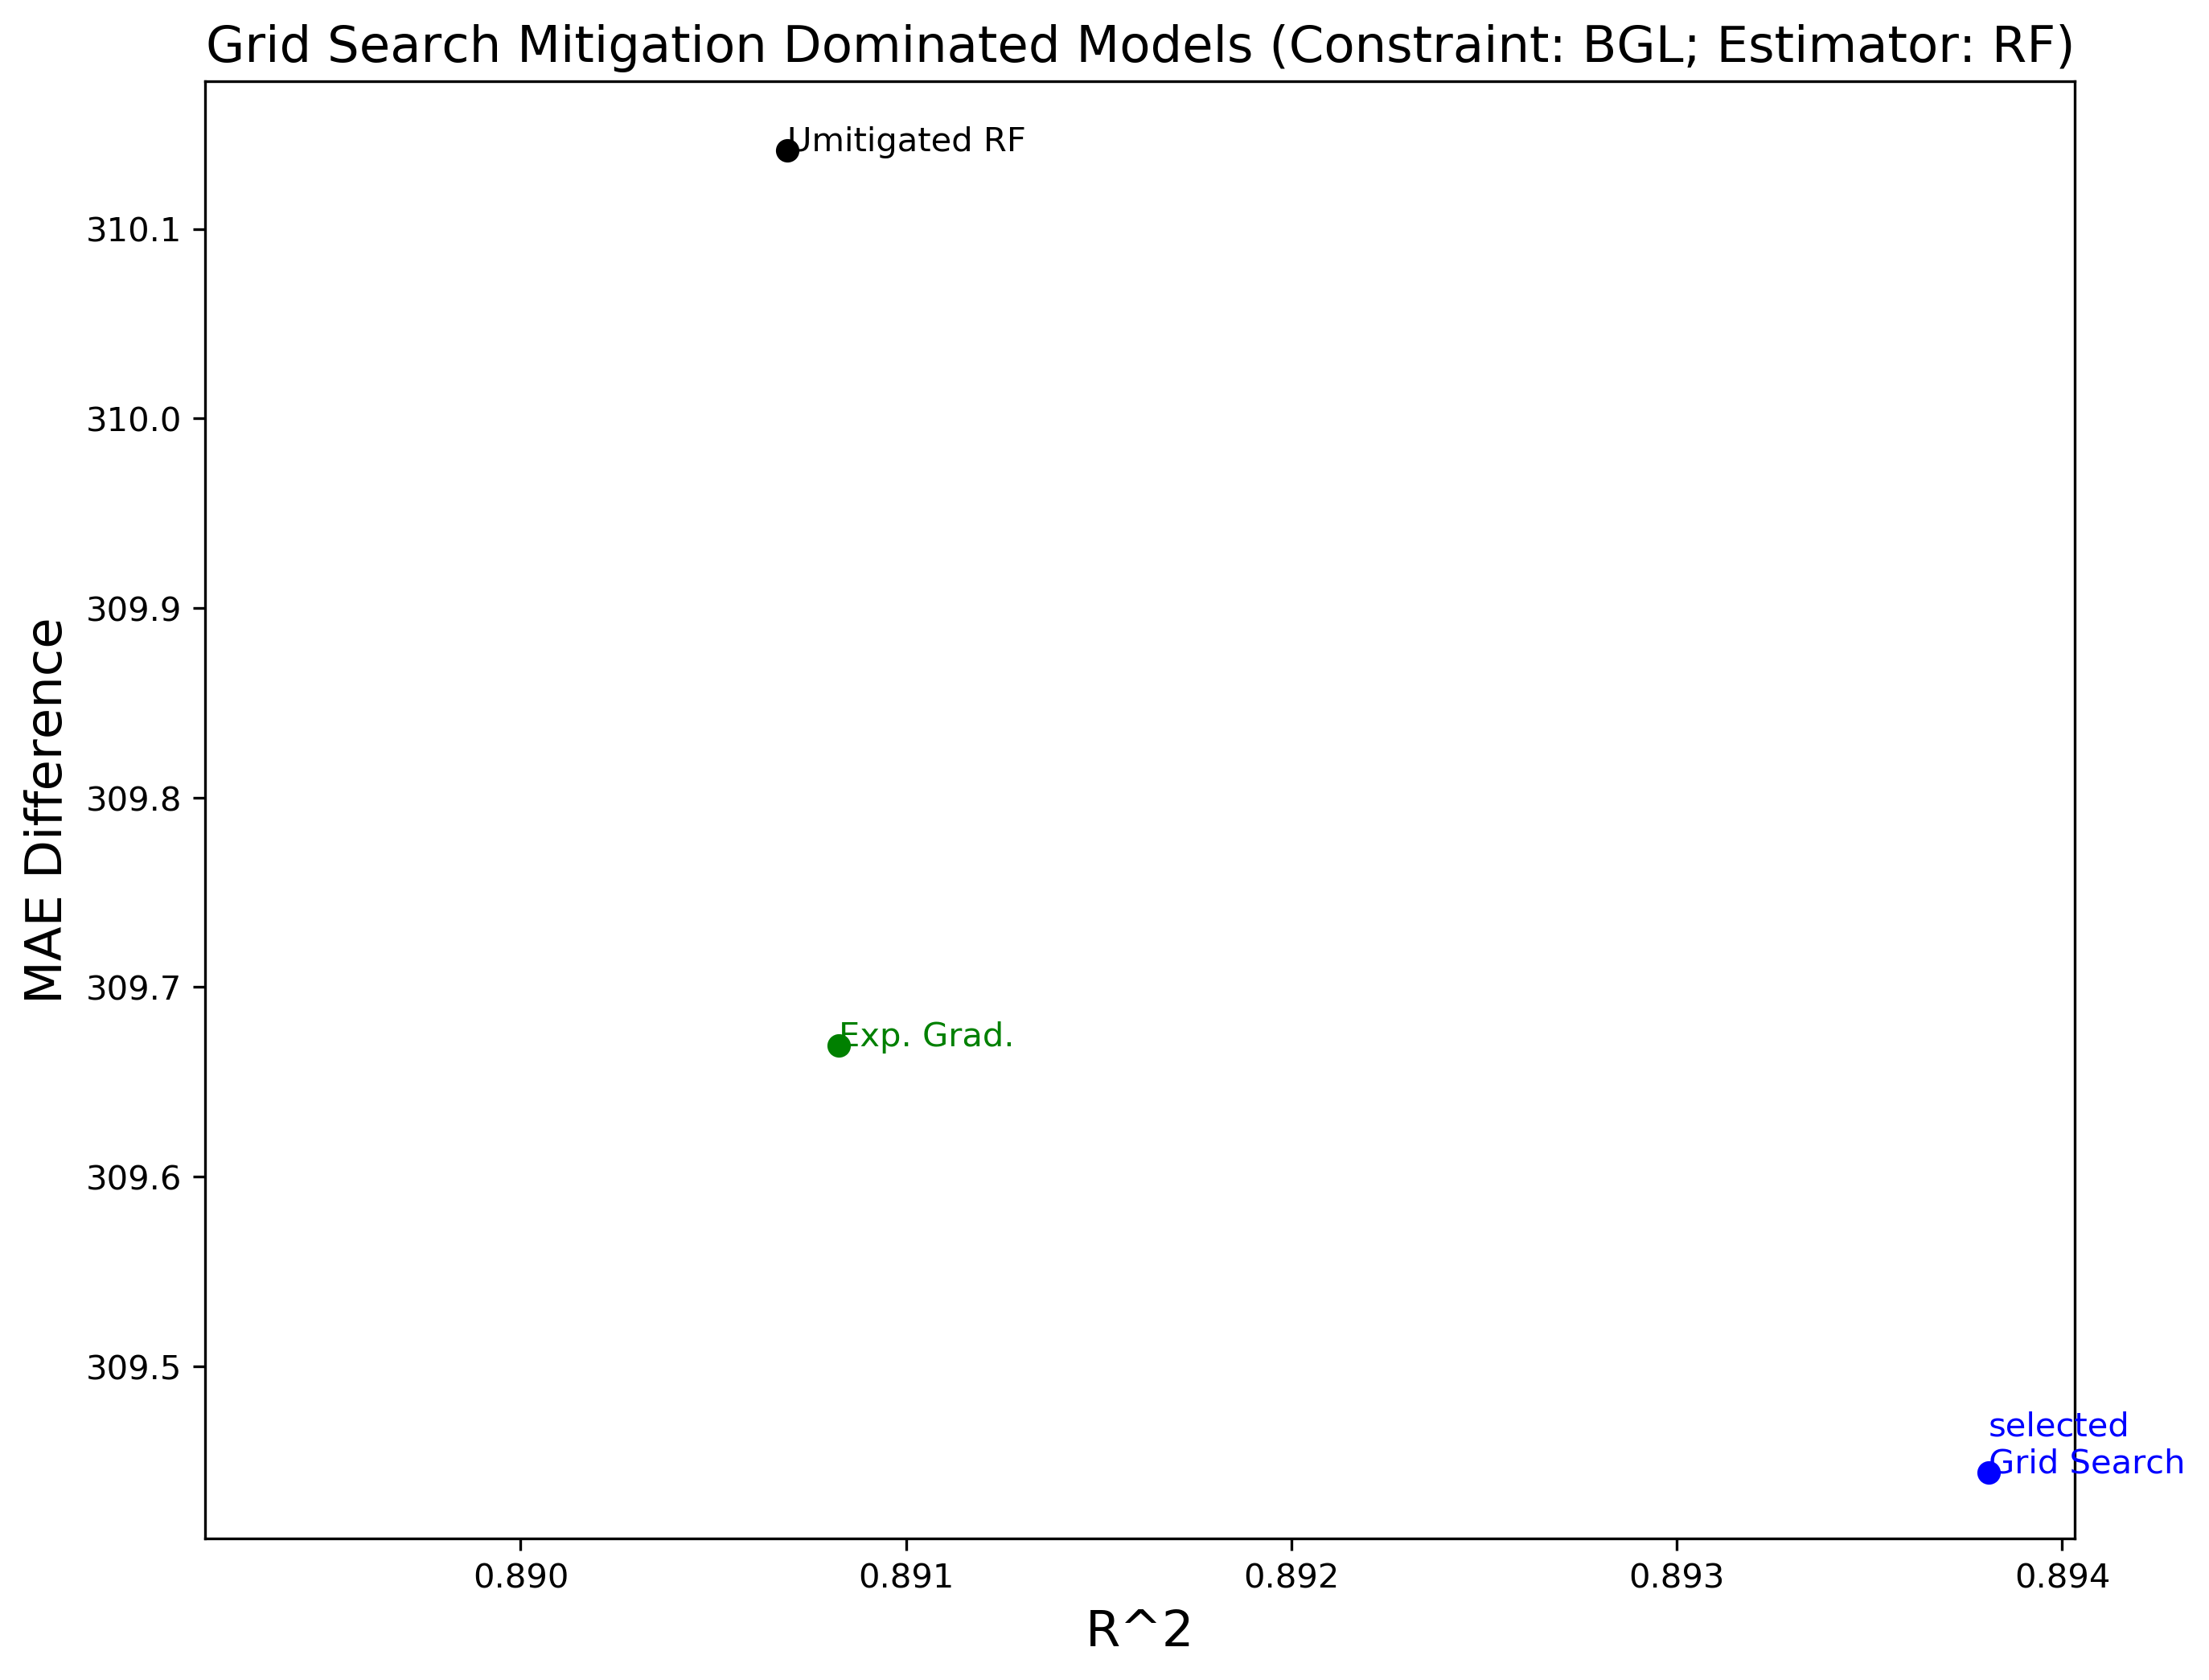

In [79]:
# plot only the dominated models

plt.figure(figsize = (10, 8))
# plt.scatter(r2_dominated, mae_diff_dominated)

# Label previous fair-unaware model
plt.scatter(metric_frame_rf_gs.overall["R^2"], metric_frame_rf_gs.difference()['MAE'], color = 'black')
plt.text(metric_frame_rf_gs.overall["R^2"], metric_frame_rf_gs.difference()['MAE'], "Umitigated RF", color = 'black')

# Selected grid search model
plt.scatter(metric_frame_gs.overall["R^2"], metric_frame_gs.difference()['MAE'], color = 'blue')
plt.text(metric_frame_gs.overall["R^2"], metric_frame_gs.difference()['MAE'], "selected\nGrid Search", color = 'blue')

# exponentiated gradient
plt.scatter(metric_frame_eg.overall['R^2'], metric_frame_eg.difference()['MAE'], color = 'green')
plt.text(metric_frame_eg.overall['R^2'], metric_frame_eg.difference()['MAE'], "Exp. Grad.", color = 'green')

plt.xlabel("R^2", fontsize = 15)
plt.ylabel("MAE Difference", fontsize = 15)
plt.title("Grid Search Mitigation Dominated Models (Constraint: BGL; Estimator: RF)", fontsize = 15)
# plt.xlim((0.806, 0.811))
plt.savefig(os.path.join(save_dir_models, CITY +"models_scatter_res"))

In [80]:
# # save grid search model
# Pkl_Filename = "grid_search.pkl"  
# with open(os.path.join(save_dir_models, CITY + Pkl_Filename), 'wb') as file:  
#     pickle.dump(gs_dominant_final[gs_least_mae_idx], file)

In [3]:
# save model statistics
model_summary.to_csv(os.path.join(save_dir_models, CITY +"model_summary.csv"))

### Visualize

In [83]:
df_geo = df_census[["cell_num", "geometry", "centroid"]]

Text(0.5, 1, 'Outflow Ground Truth in 2019')

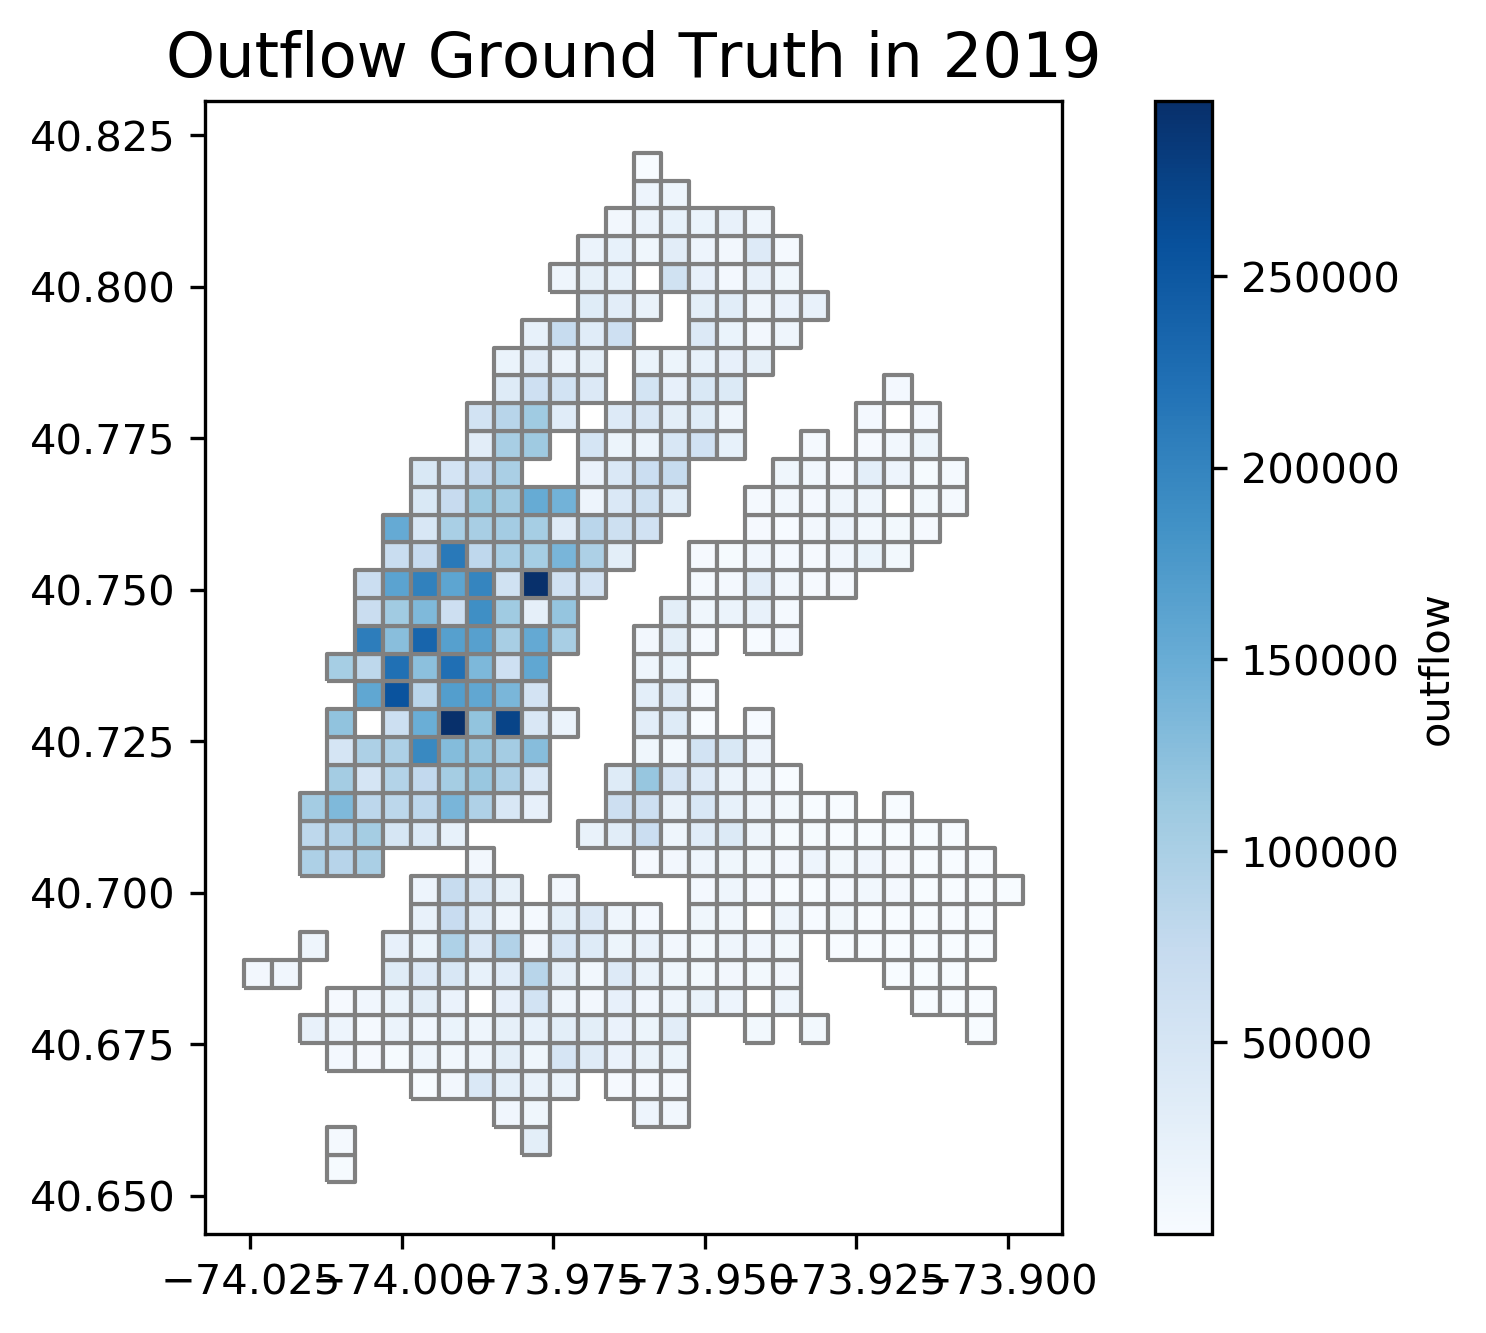

In [84]:
unmitigated_df = pd.DataFrame({ "cell_num": df_19.cell_num.values,
                                "y_pred": y_pred_rf_gs,
                                "y_true": df_19.outflow.values})
# sum within a cell
unmitigated_df = unmitigated_df.groupby("cell_num").sum()
unmitigated_df_plot = unmitigated_df.merge(df_geo, how='left', on = 'cell_num')

geo_cells_unmitigated = gpd.GeoDataFrame(unmitigated_df_plot, crs='EPSG:2956', geometry='geometry')
geo_cells_unmitigated.plot(column="y_true", cmap='Blues',edgecolor = "grey", figsize=(8, 5),  
                    legend = True, legend_kwds={'label': "outflow",'orientation': "vertical"})
plt.title("Outflow Ground Truth in 2019", fontsize = 15)

Text(0.5, 1, 'Unmitigated random forest outflow in 2019')

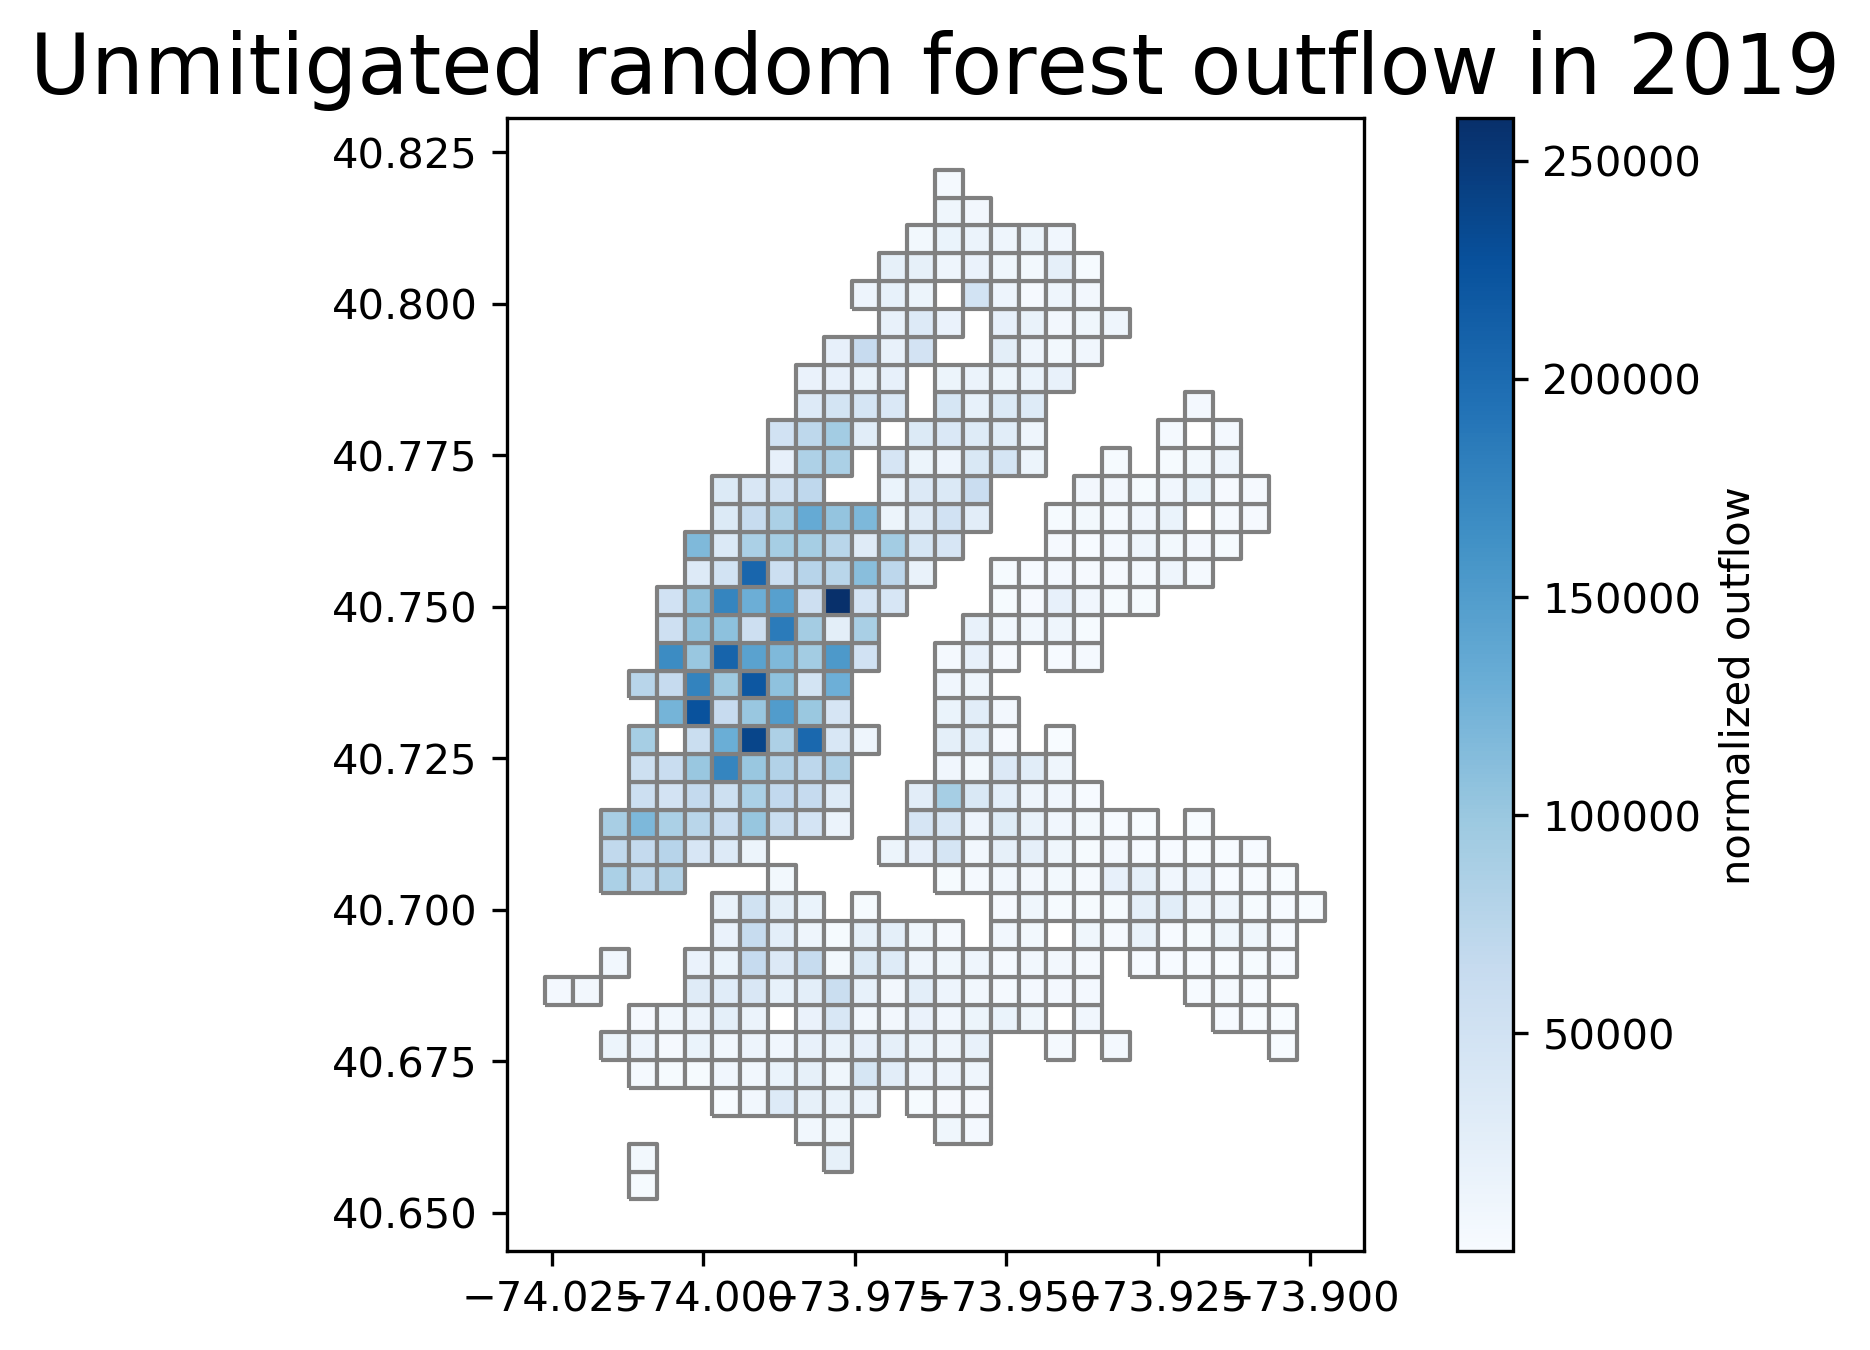

In [85]:
geo_cells_unmitigated.plot(column="y_pred", cmap='Blues',edgecolor = "grey", figsize=(8, 5),  
                    legend = True, legend_kwds={'label': "normalized outflow",'orientation': "vertical"})
plt.title("Unmitigated random forest outflow in 2019", fontsize = 20)

Text(0.5, 1, 'Exp Grad prediction in 2019')

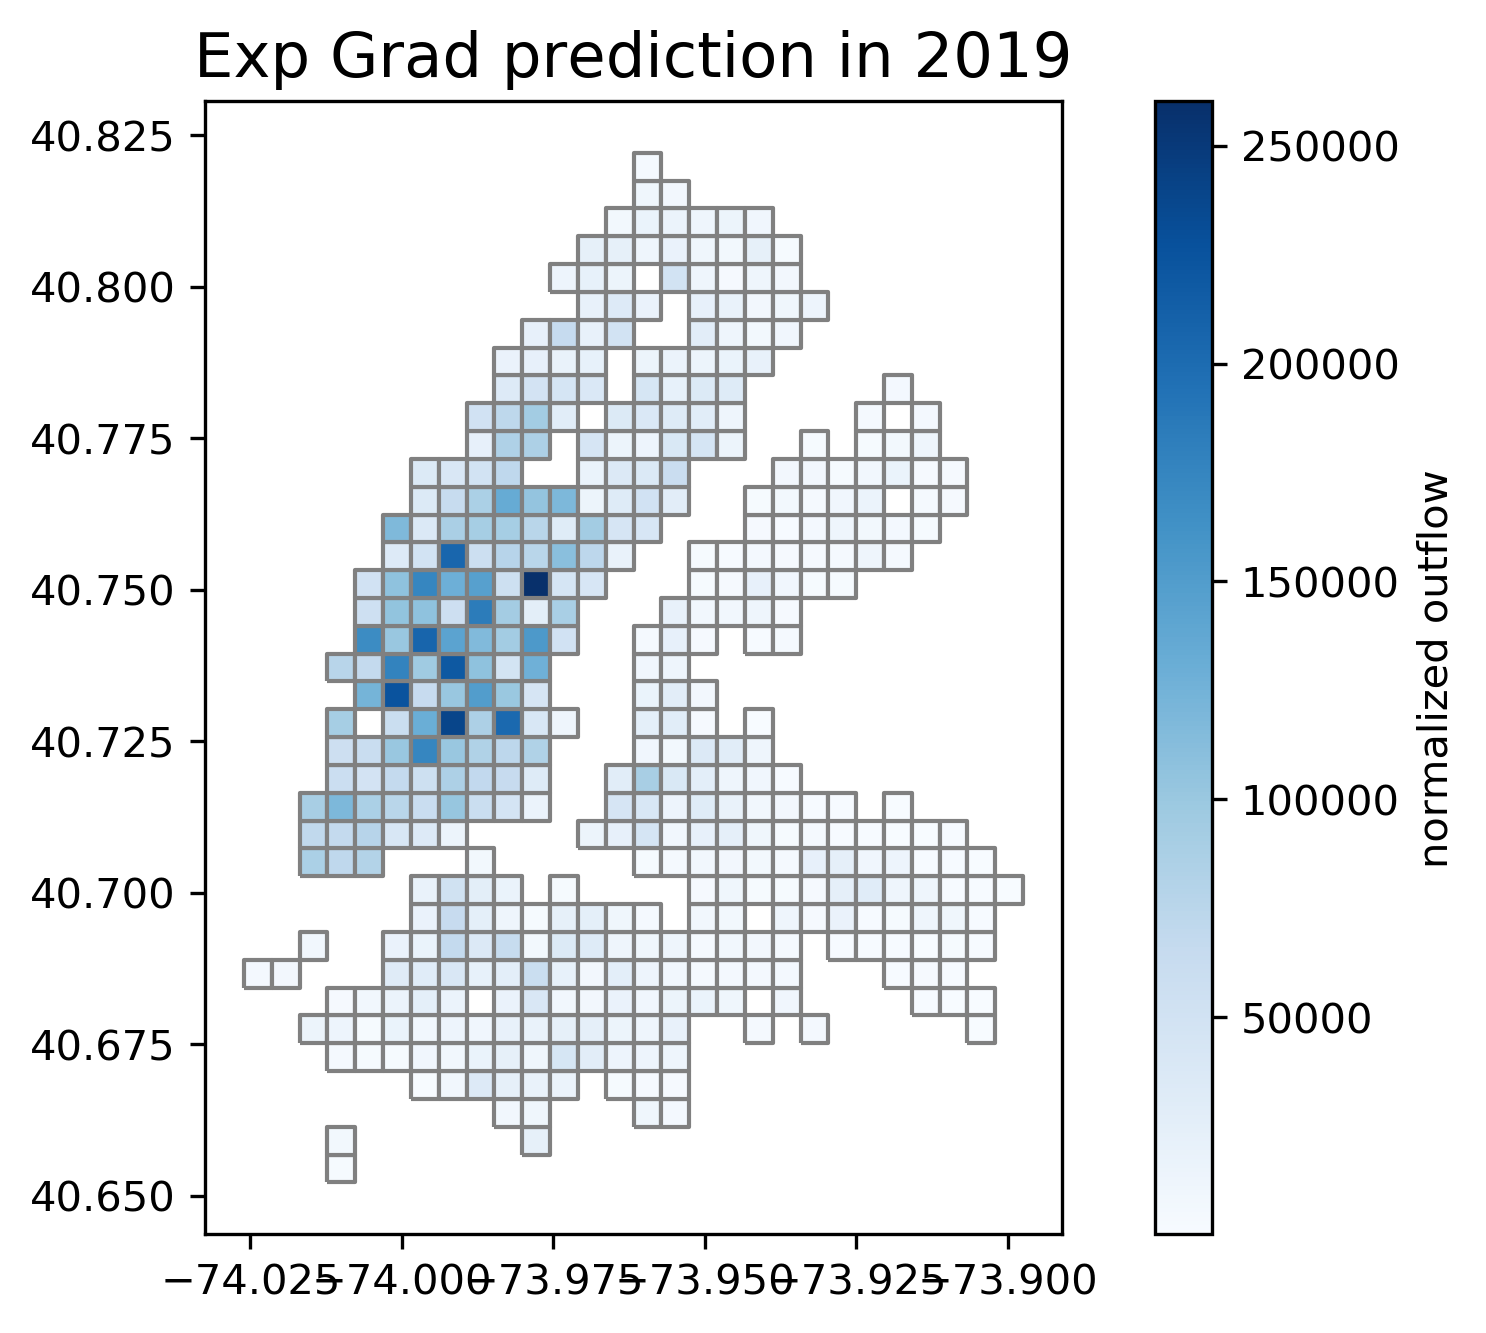

In [86]:
mitigated_eg_df = pd.DataFrame({"cell_num": df_19.cell_num.values,
                                "y_pred": y_pred_eg,
                                "y_true": y_test})
mitigated_eg_df = mitigated_eg_df.groupby("cell_num").sum()
mitigated_eg_df_plot = mitigated_eg_df.merge(df_geo, how='left', on = 'cell_num')
geo_cells_mitigated_eg = gpd.GeoDataFrame(mitigated_eg_df_plot, crs='EPSG:2956', geometry='geometry')

geo_cells_mitigated_eg.plot(column="y_pred", cmap='Blues',edgecolor = "grey", figsize=(8, 5),  
                    legend = True, legend_kwds={'label': "normalized outflow",'orientation': "vertical"})
# plt.title("Mitigated with Exponentiated Gradient (low accuracy, low disparity)")
plt.title("Exp Grad prediction in 2019", fontsize = 15)

Text(0.5, 1, 'Grid Search prediction 2019')

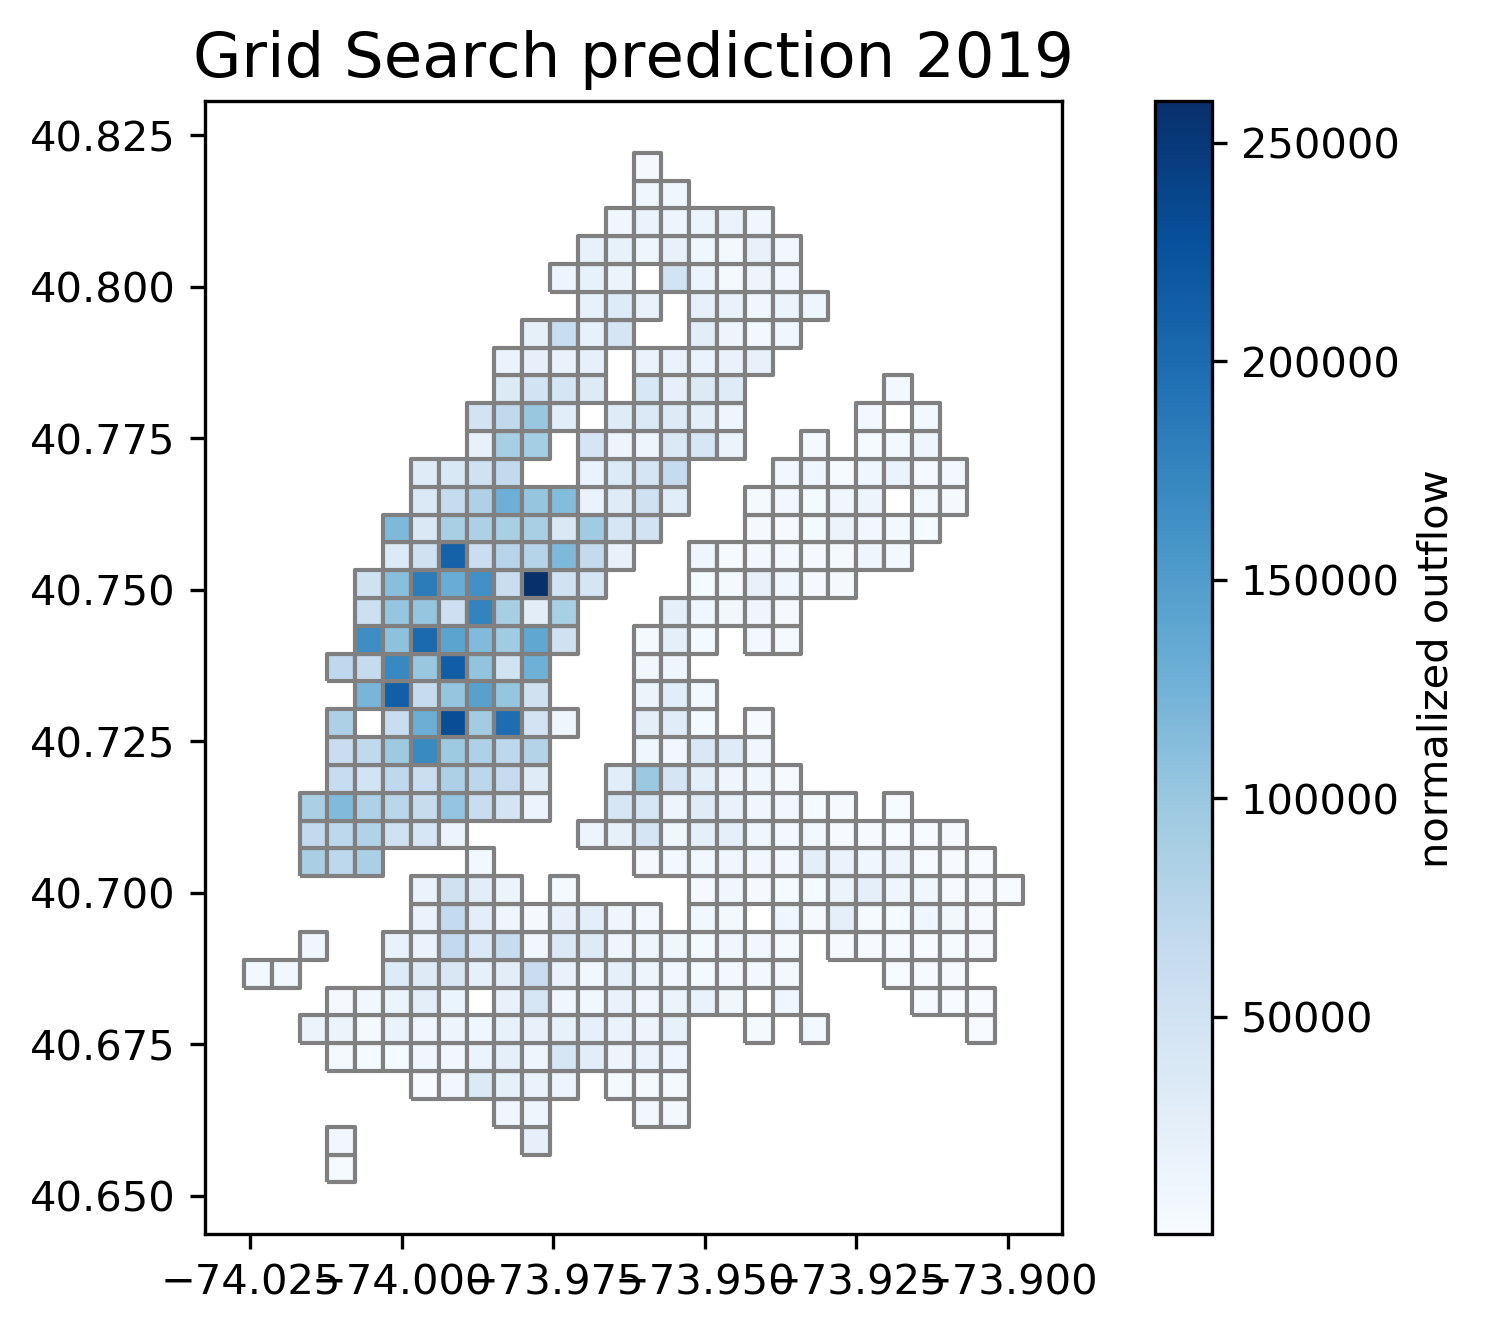

In [87]:
mitigated_gs_df = pd.DataFrame({
    # "index": y_test.index,
    "cell_num": df_19.cell_num.values,
    "y_pred": y_pred_gs,
    "y_true": y_test})
mitigated_gs_df = mitigated_gs_df.groupby("cell_num").sum()
mitigated_gs_df_plot = mitigated_gs_df.merge(df_geo, how='left', on = 'cell_num')
geo_cells_mitigated_gs = gpd.GeoDataFrame(mitigated_gs_df_plot, crs='EPSG:2956', geometry='geometry')

geo_cells_mitigated_gs.plot(column="y_pred", cmap='Blues',edgecolor = "grey", figsize=(8, 5),  
                    legend = True, legend_kwds={'label': "normalized outflow",'orientation': "vertical"})
plt.title("Grid Search prediction 2019", fontsize = 15)

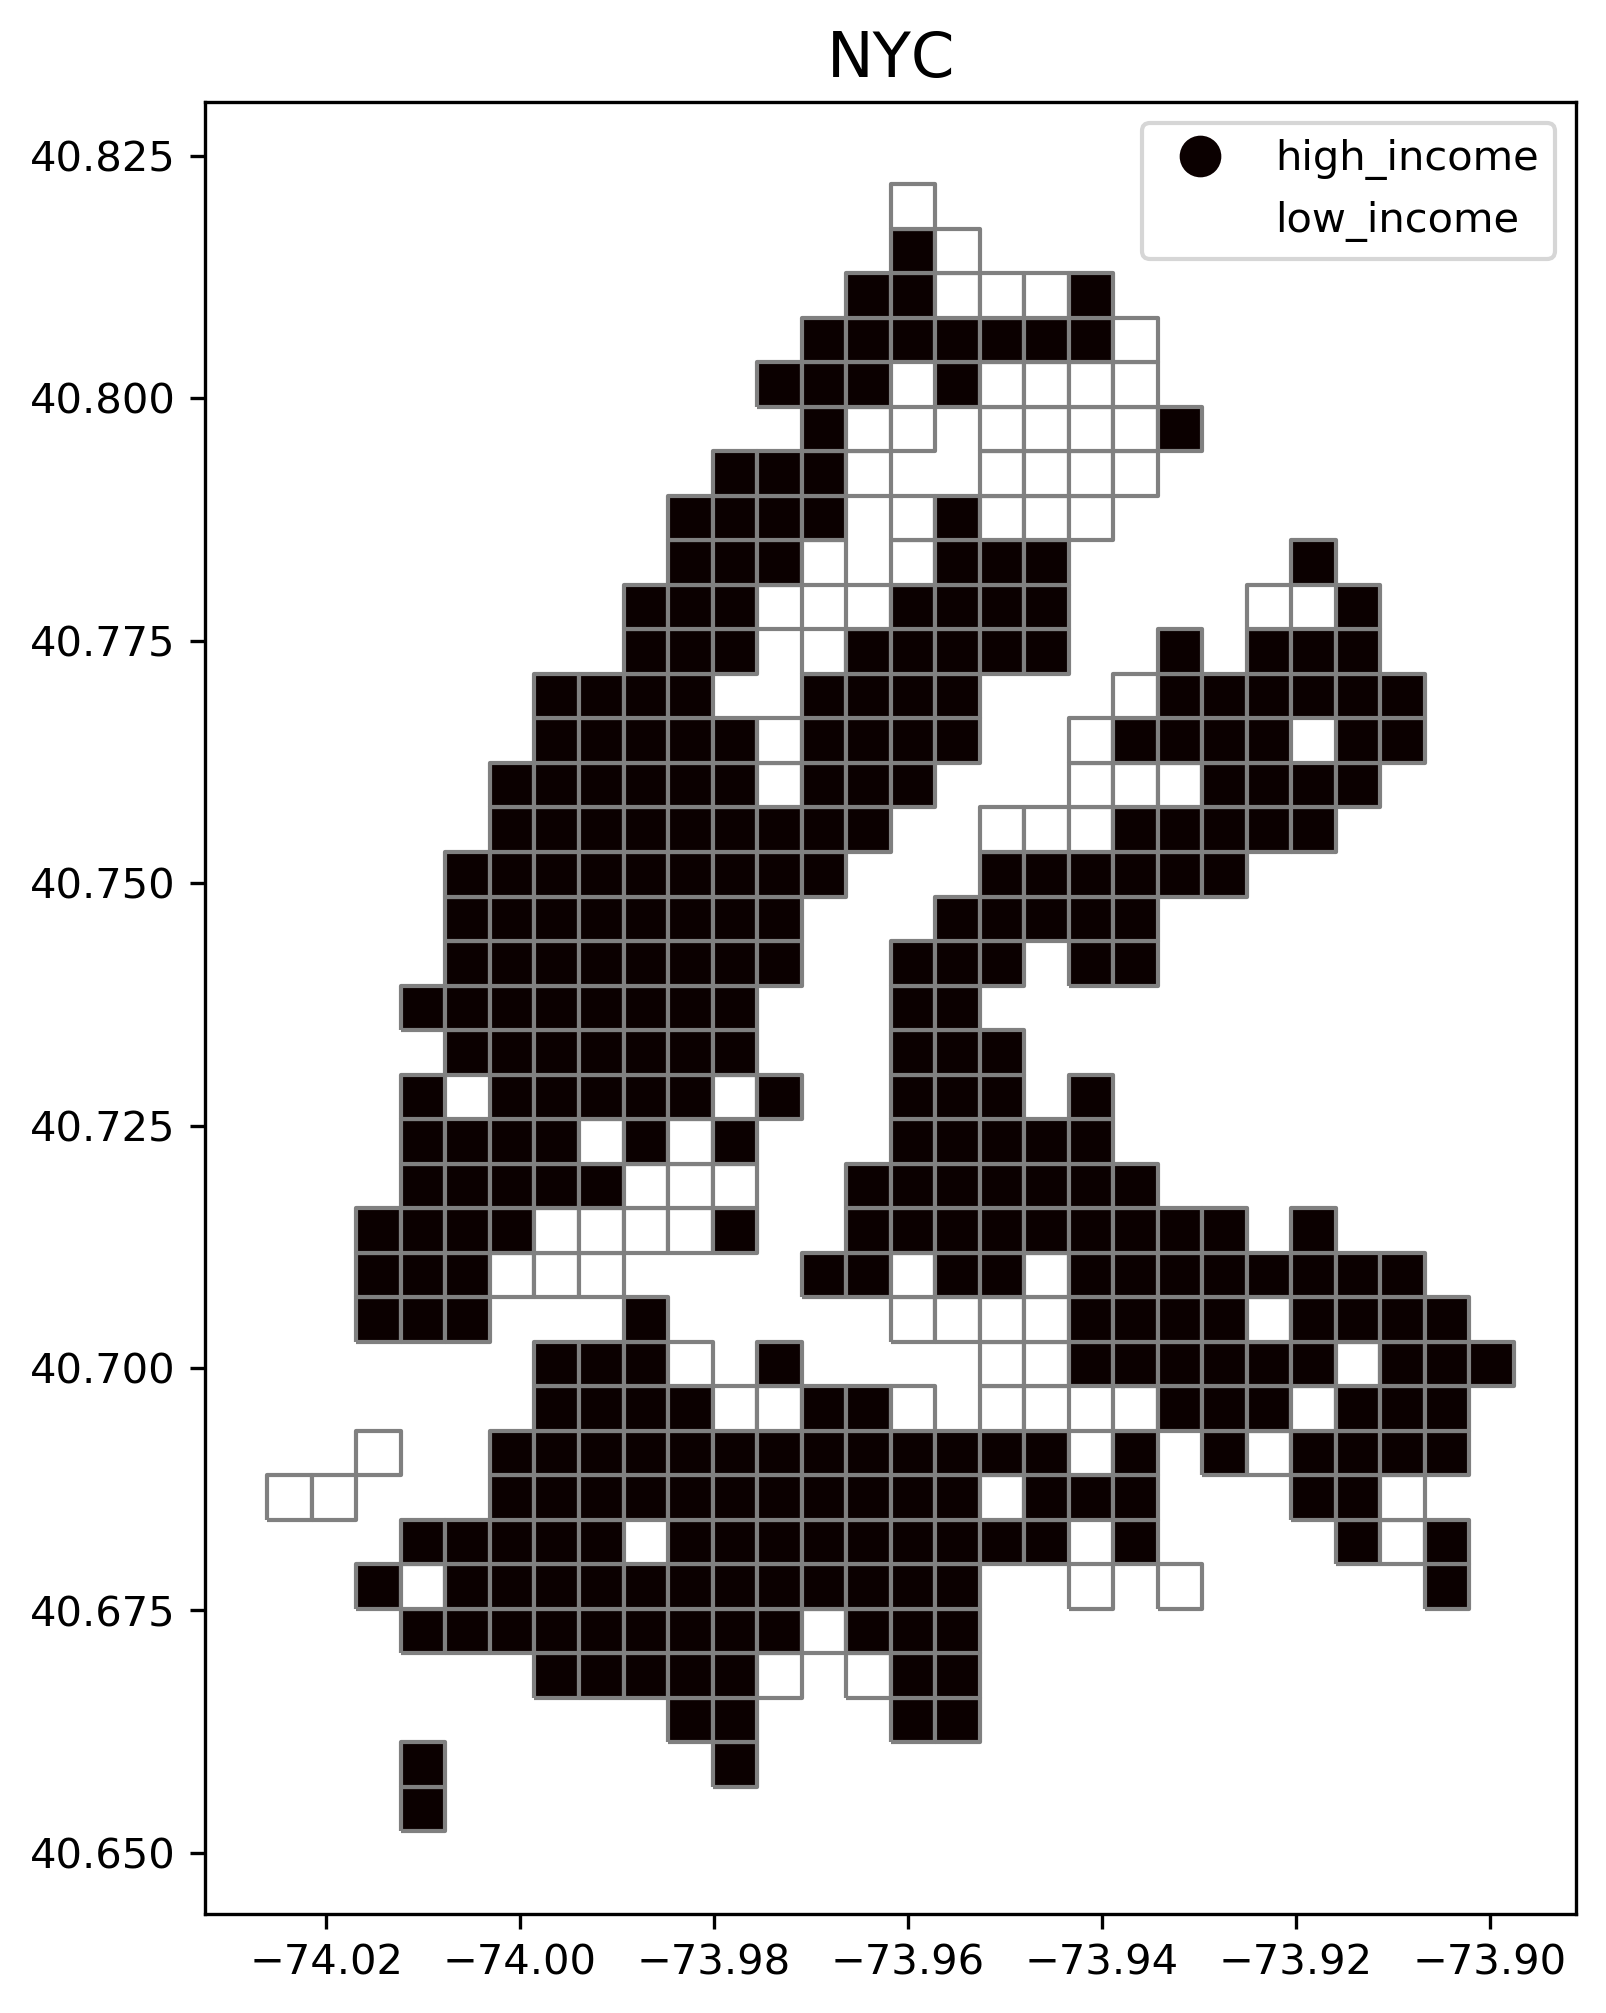

In [88]:
income_df = pd.DataFrame({"cell_num": df_19.cell_num.values,
                            "income": df_19.income_group.values})
income_df = income_df.groupby("cell_num").sum()
income_df_plot = income_df.merge(df_geo, how='left', on = 'cell_num')
geo_cells_income = gpd.GeoDataFrame(income_df_plot, crs='EPSG:2956', geometry='geometry')
# type(pgh_grid_income.loc[0]['geometry'])
geo_cells_income["bi_income"] = geo_cells_income["income"].apply(lambda x: "high_income" if x > 0 else "low_income")
geo_cells_income.plot(column="bi_income", cmap='hot', edgecolor = "grey", figsize=(10, 8),  
                    legend = True, categorical = True)
plt.title("NYC", fontsize = 15)
plt.savefig("nyc_income")

In [89]:
income_df_plot.bi_income.describe()

count             448
unique              2
top       high_income
freq              362
Name: bi_income, dtype: object

### fairst

In [ ]:
fairst_pred = pd.read_csv(os.path.join(save_dir_fairst, "fairst_pred.csv"), index_col = 0)
for row, col in fairst_pred.iterrows():
    fairst_pred.at[row, 'geometry'] = shapely.wkt.loads(fairst_pred.loc[row]['geometry'])

Text(0.5, 1, 'fairST(lambda: 0.1) prediction in 2019')

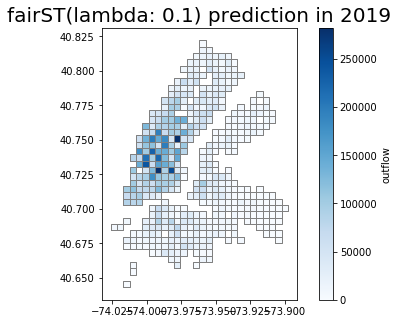

In [91]:
fairst_pred = gpd.GeoDataFrame(fairst_pred, crs='EPSG:2956', geometry='geometry')
# type(pgh_grid_income.loc[0]['geometry'])

fairst_pred.plot(column="outflow", cmap='Blues',edgecolor = "grey", figsize=(8, 5),  
                    legend = True, legend_kwds={'label': "outflow", 'orientation': "vertical"})
plt.title("fairST(lambda: {}) prediction in 2019".format(str(0.1)), fontsize=20)

## View all

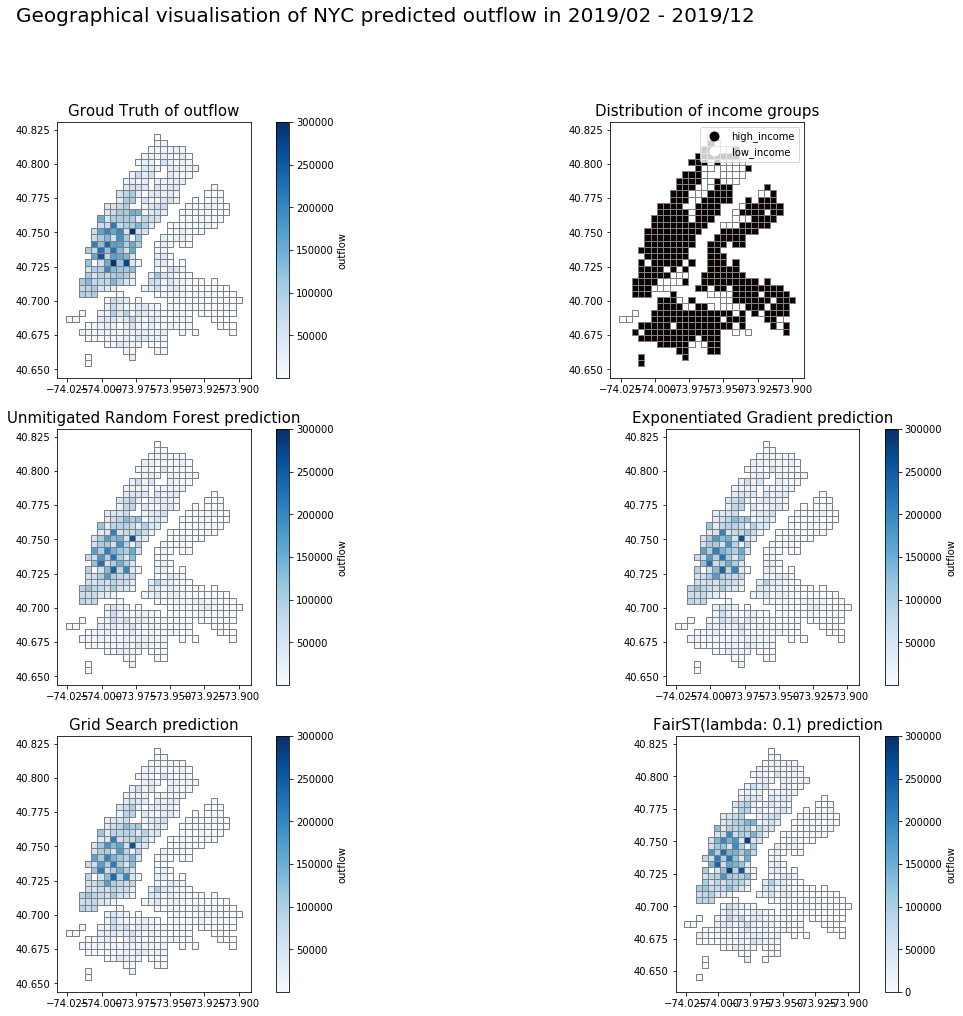

In [92]:
fig, axes = plt.subplots(3,2, figsize = (20, 16))

ax1=axes[0,0]
ax2=axes[0,1]
ax3=axes[1,0]
ax4=axes[1,1]
ax5=axes[2,0]
ax6=axes[2,1]

geo_cells_unmitigated.plot(column="y_true", cmap='Blues',edgecolor = "grey", figsize=(8,5), legend = True, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = ax1, vmax = 300000)
ax1.set_title("Groud Truth of outflow", size = 15)

geo_cells_income.plot(column="bi_income", cmap='hot', edgecolor = "grey", figsize=(5, 3), legend = True, categorical = True, ax = ax2)
ax2.set_title("Distribution of income groups", size = 15)

geo_cells_unmitigated.plot(column="y_pred", cmap='Blues',edgecolor = "grey", figsize=(8,5), legend = True, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = ax3, vmax = 300000)
ax3.set_title("Unmitigated Random Forest prediction", size = 15)

geo_cells_mitigated_eg.plot(column="y_pred", cmap='Blues',edgecolor = "grey", figsize=(8,5), legend = True, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = ax4, vmax = 300000)
ax4.set_title("Exponentiated Gradient prediction", size = 15)

geo_cells_mitigated_gs.plot(column="y_pred", cmap='Blues',edgecolor = "grey", figsize=(8,5), legend = True, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = ax5, vmax = 300000)
ax5.set_title("Grid Search prediction", size = 15)

fairst_pred.plot(column="outflow", cmap='Blues',edgecolor = "grey", figsize=(8, 5), legend = True, legend_kwds={'label': "outflow", 'orientation': "vertical"}, ax = ax6, vmax = 300000)
ax6.set_title("FairST(lambda: {}) prediction".format(str(0.1)), size = 15)

fig.suptitle('Geographical visualisation of NYC predicted outflow in 2019/02 - 2019/12', fontsize = 20)

plt.savefig(os.path.join(save_dir_models, CITY + "geographical_visualization"))
